In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 116]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/coronal/t1c", t2f_dir="PED_Sliced/coronal/t2f", seg_dir="PED_Sliced/coronal/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



6048
189
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])
Data shape: torch.Size([32, 2, 240, 155])
Labels shape: torch.Size([32, 240, 155])


In [12]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

class AttnUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttnUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim=1)
        c6 = self.conv6(merge6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim=1)
        c7 = self.conv7(merge7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim=1)
        c8 = self.conv8(merge8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim=1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [13]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [14]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [15]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "Attnunet_PED_coronal_comb.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = AttnUNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = AttnUNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "Attnunet_PED_coronal_comb.pth")

    
    return model


In [16]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


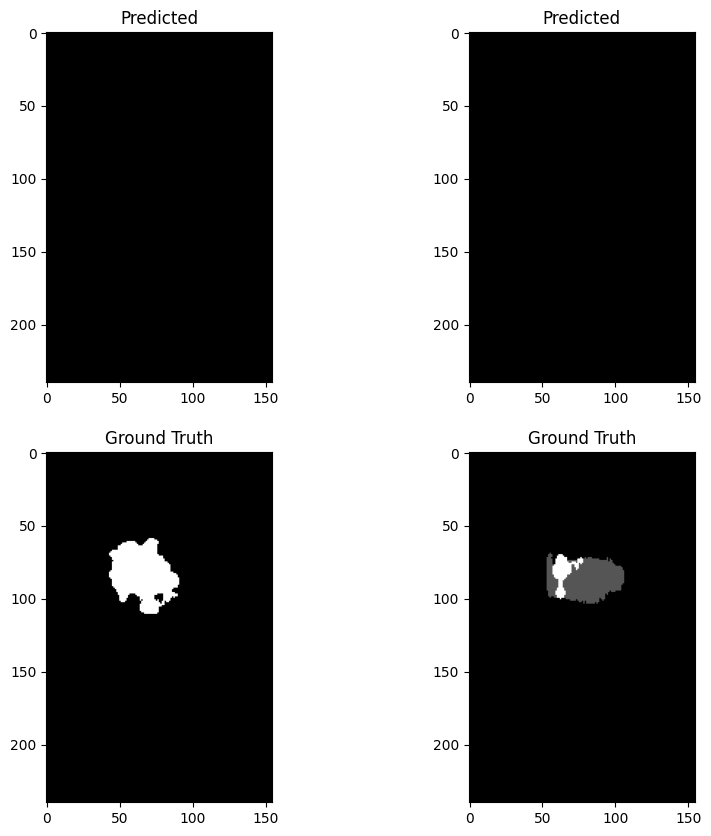

100%|██████████| 189/189 [22:55<00:00,  7.28s/it]



Average Training Loss: 0.28292008617488795

Average Training DSC: [0.89582908 0.46081376 0.74884259 0.04689485]
Average Training ASSD: [ 31.52423556 195.12766838  90.91898148 269.47052919]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


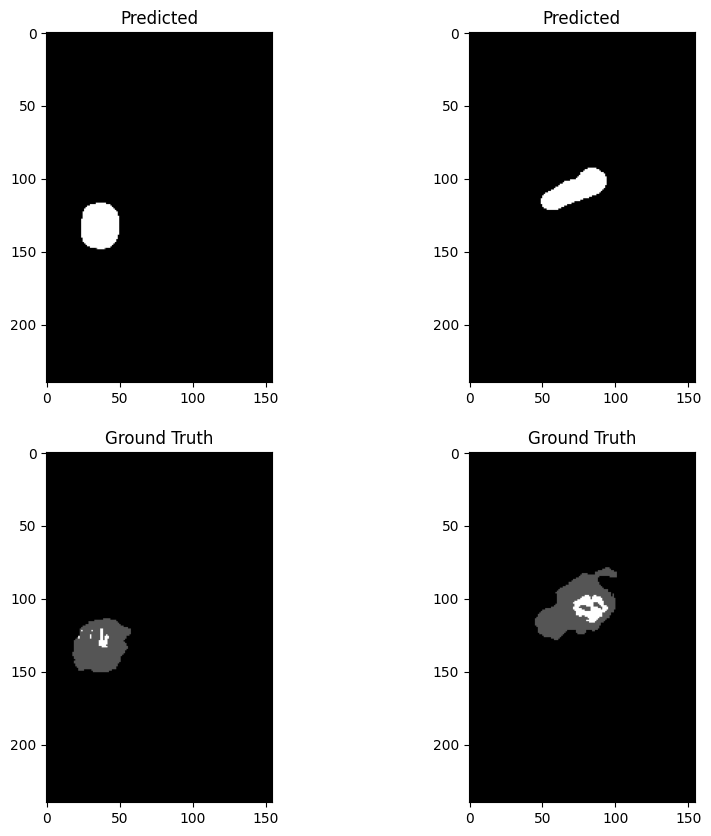

100%|██████████| 48/48 [05:53<00:00,  7.36s/it]


Average Validation Loss: 0.07943985882836084

Average Validation DSC: [0.98895116 0.42494426 0.73430266 0.24119595]
Average Validation ASSD: [  1.58598657 200.98782286  96.18243634 112.19720525]
Epoch 2/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


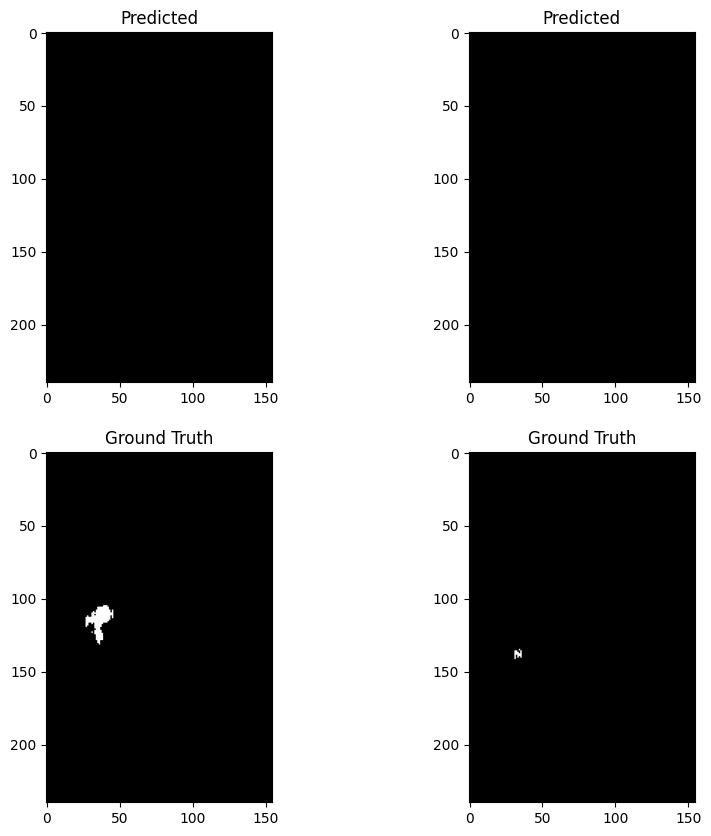

100%|██████████| 189/189 [24:08<00:00,  7.66s/it]



Average Training Loss: 0.06696281319967022

Average Training DSC: [0.99180369 0.22720153 0.74884259 0.30912149]
Average Training ASSD: [  1.03892435 140.252202    90.91898148  76.459411  ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


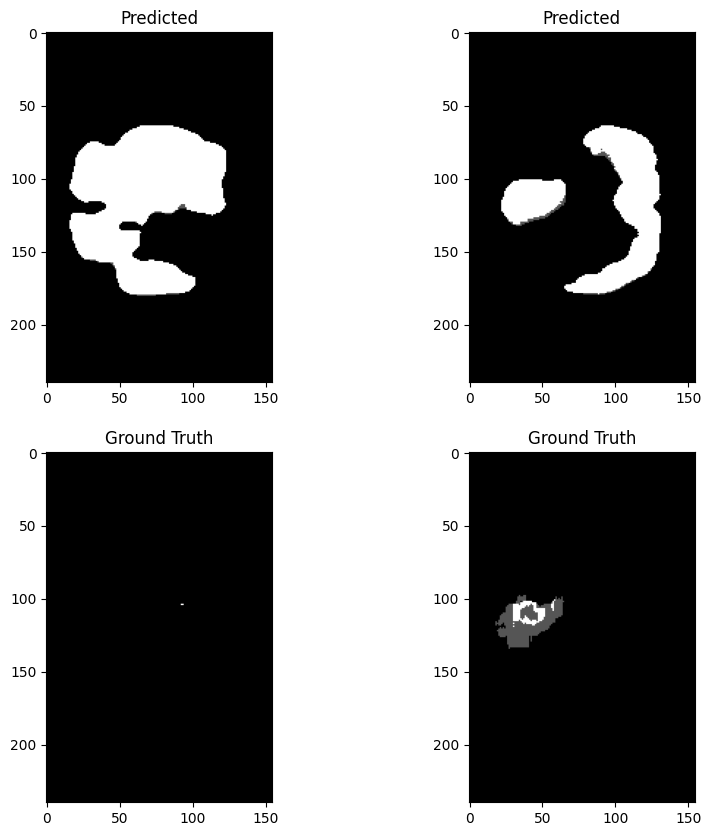

100%|██████████| 48/48 [05:56<00:00,  7.43s/it]


Average Validation Loss: 0.17893811656783024

Average Validation DSC: [0.97406618 0.01901383 0.73763021 0.29377028]
Average Validation ASSD: [  2.25356327 166.18343309  94.97786458  18.56487562]
Epoch 3/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


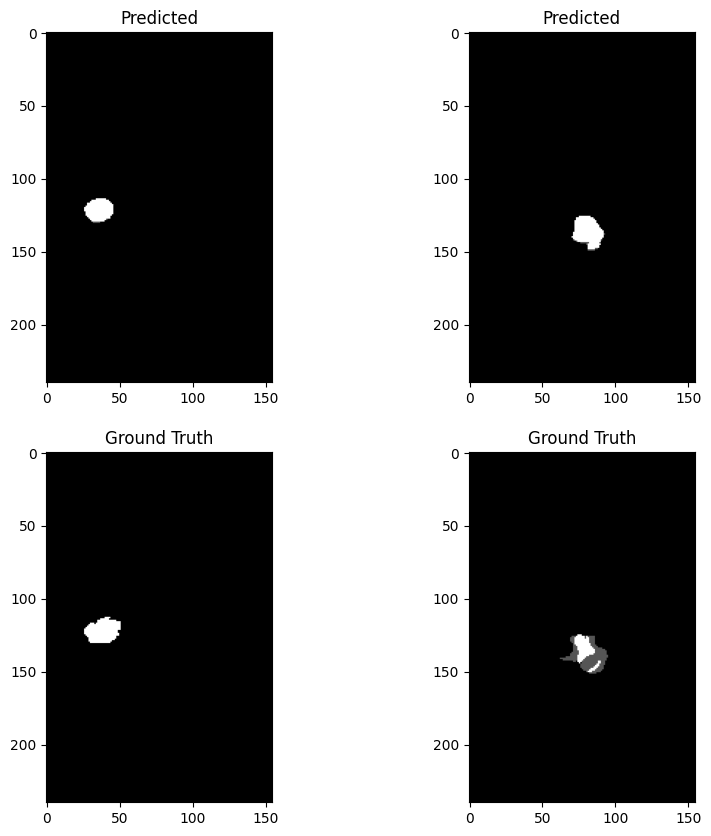

100%|██████████| 189/189 [24:28<00:00,  7.77s/it]



Average Training Loss: 0.0571440759277533

Average Training DSC: [0.99348165 0.24253013 0.74884259 0.34836755]
Average Training ASSD: [  0.78800992 129.44740727  90.91898148  61.13599765]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


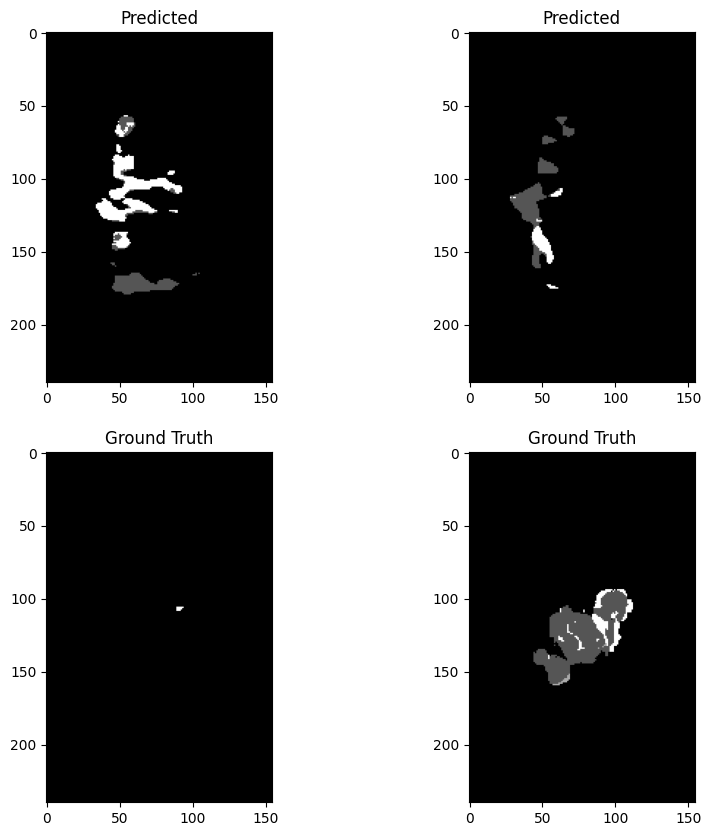

100%|██████████| 48/48 [06:34<00:00,  8.21s/it]


Average Validation Loss: 0.19311727738628784

Average Validation DSC: [0.98144596 0.13258039 0.73263889 0.21525143]
Average Validation ASSD: [  3.4521113  163.64071869  96.78472222  35.77041436]
Epoch 4/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


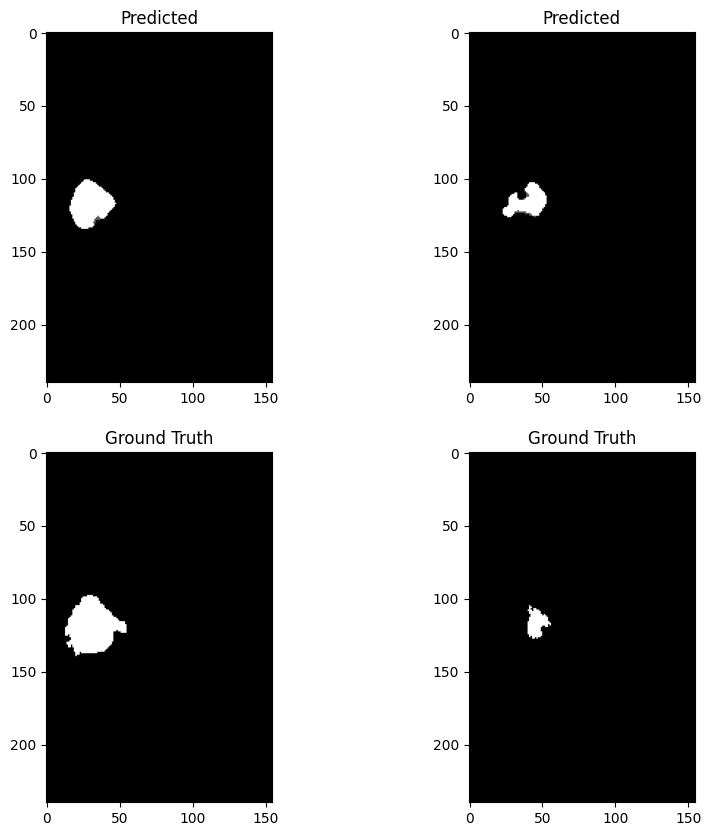

100%|██████████| 189/189 [23:59<00:00,  7.62s/it]



Average Training Loss: 0.052110894962593364

Average Training DSC: [0.99449719 0.33047449 0.74884259 0.35229001]
Average Training ASSD: [  0.64260017 120.57515056  90.91898148  50.61807255]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


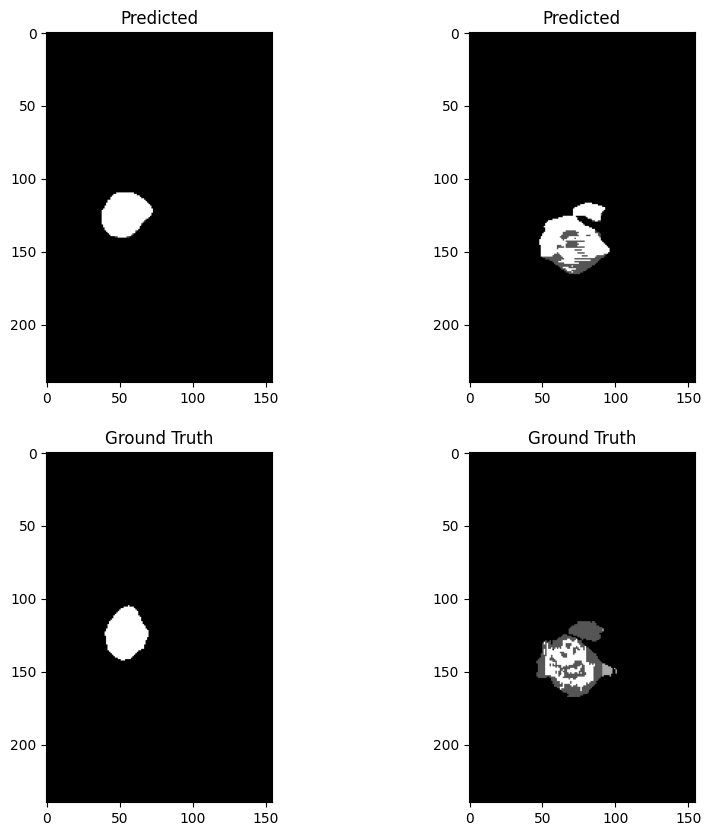

100%|██████████| 48/48 [05:49<00:00,  7.28s/it]


Average Validation Loss: 0.05084045960878333

Average Validation DSC: [0.99515949 0.34129447 0.73596644 0.35394038]
Average Validation ASSD: [  0.55481802 116.6411244   95.58015046  44.32347188]
Epoch 5/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


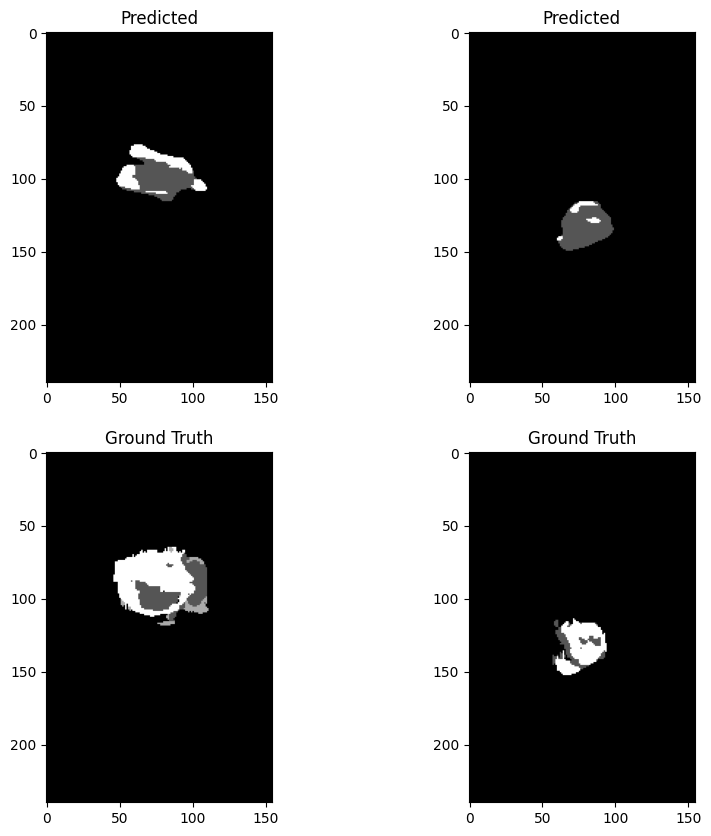

100%|██████████| 189/189 [24:24<00:00,  7.75s/it]



Average Training Loss: 0.0488902106486931

Average Training DSC: [0.99515165 0.36841381 0.74884259 0.38015829]
Average Training ASSD: [  0.56530001 113.95613952  90.91898148  43.0721062 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


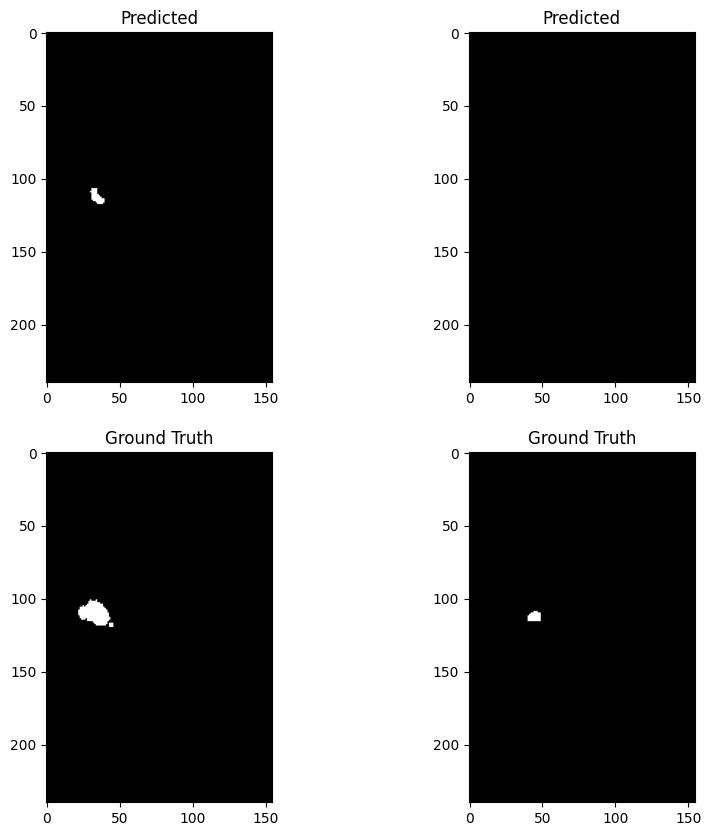

100%|██████████| 48/48 [06:08<00:00,  7.67s/it]


Average Validation Loss: 0.07543559799281259

Average Validation DSC: [0.99013357 0.41141402 0.73430266 0.24273789]
Average Validation ASSD: [  1.26261967 121.85847633  96.18243634  94.2304941 ]
Epoch 6/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


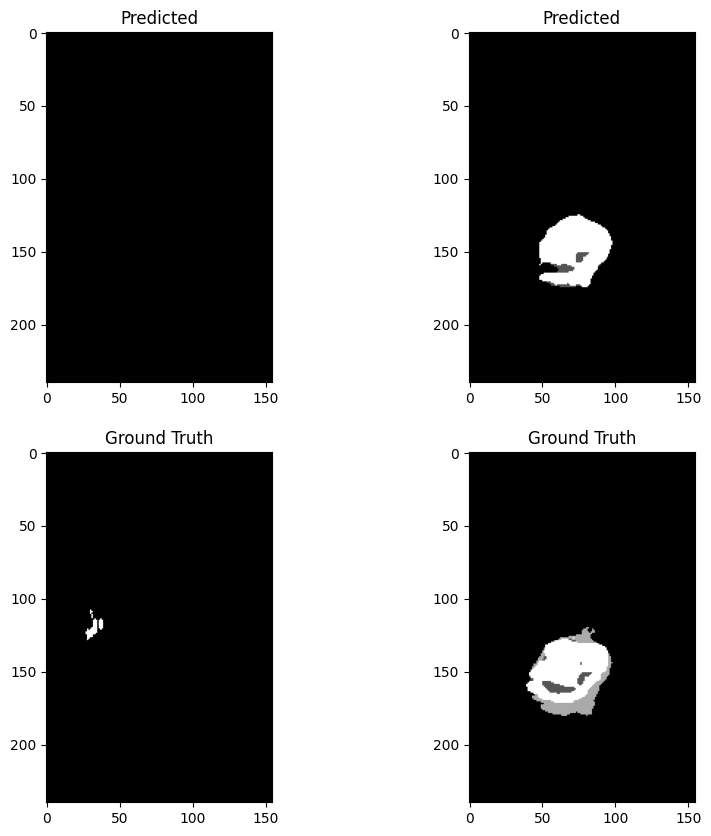

100%|██████████| 189/189 [24:34<00:00,  7.80s/it]



Average Training Loss: 0.04696013332004585

Average Training DSC: [0.99553094 0.40555807 0.74884259 0.38542867]
Average Training ASSD: [  0.52041207 112.19554533  90.91898148  42.13293115]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


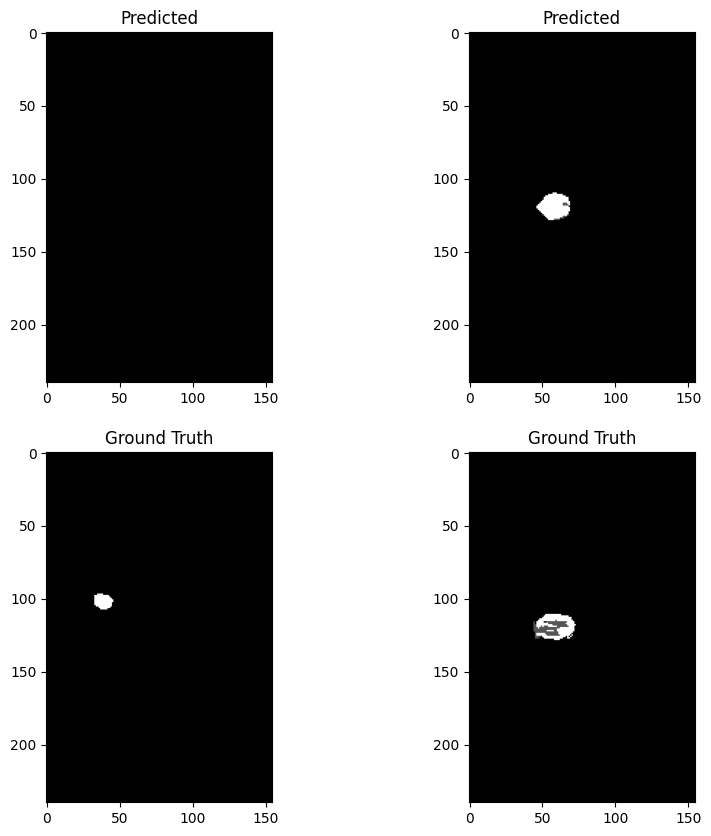

100%|██████████| 48/48 [05:37<00:00,  7.04s/it]


Average Validation Loss: 0.08374291829143961

Average Validation DSC: [0.99034861 0.43932718 0.73097512 0.25885902]
Average Validation ASSD: [  1.39691845 151.13312336  97.3870081  113.22993967]
Epoch 7/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


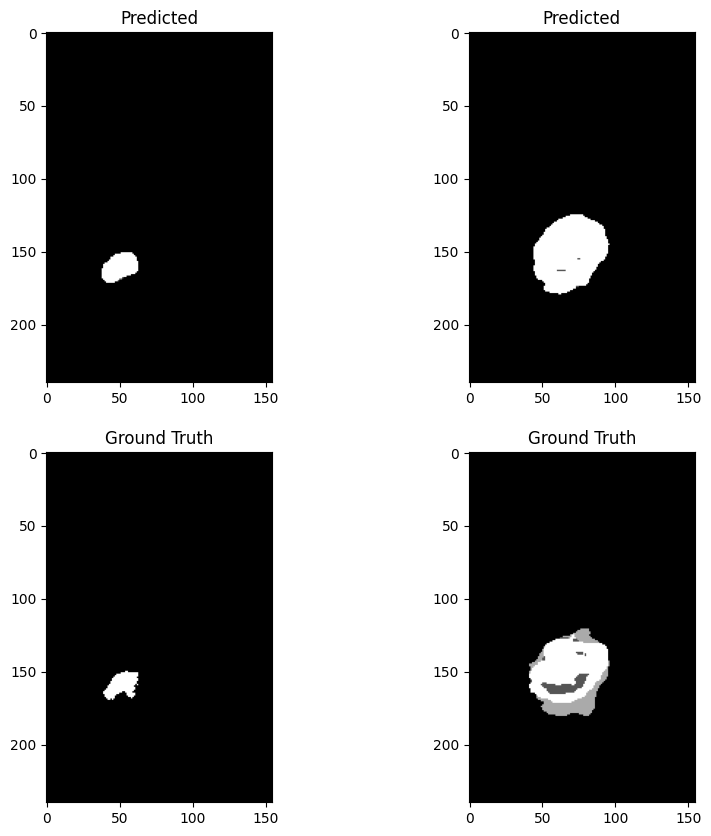

100%|██████████| 189/189 [24:39<00:00,  7.83s/it]



Average Training Loss: 0.04458699288664671

Average Training DSC: [0.99594711 0.40095953 0.74884259 0.39734685]
Average Training ASSD: [  0.4794527  113.58557112  90.91898148  40.19678441]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


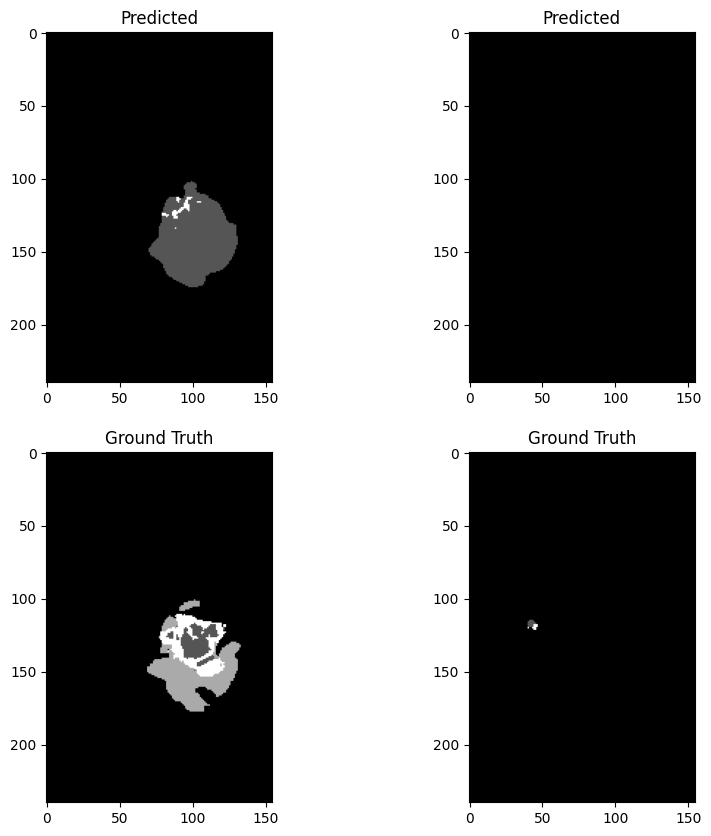

100%|██████████| 48/48 [06:04<00:00,  7.60s/it]


Average Validation Loss: 0.0558360677678138

Average Validation DSC: [0.99531653 0.36013872 0.73097512 0.29951468]
Average Validation ASSD: [  0.55516057 133.11160795  97.3870081   25.96241418]
Epoch 8/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


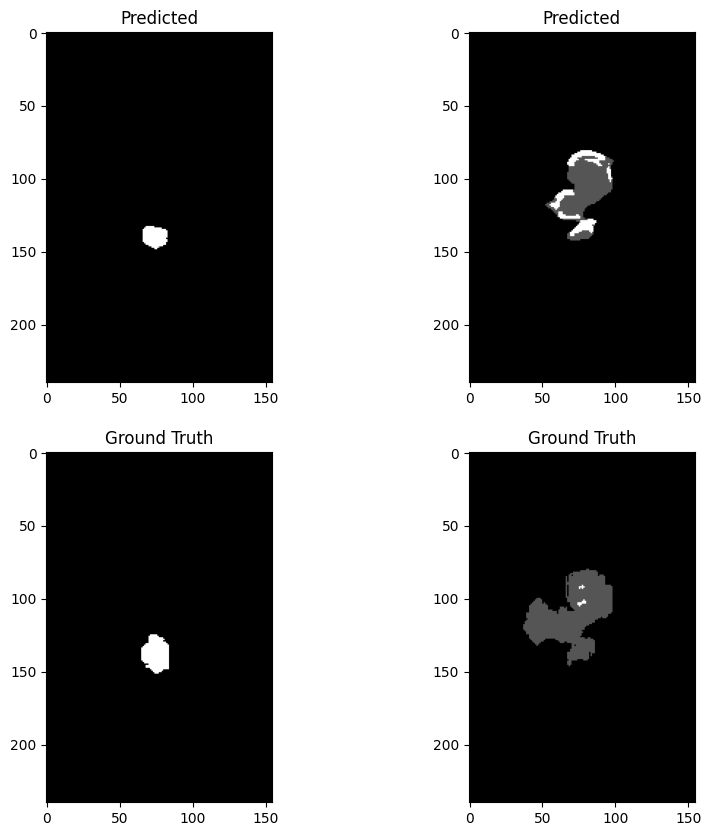

100%|██████████| 189/189 [24:35<00:00,  7.81s/it]



Average Training Loss: 0.04301845089153007

Average Training DSC: [0.99624262 0.40529042 0.74884259 0.39749817]
Average Training ASSD: [  0.44397265 113.60330133  90.91898148  39.10021315]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


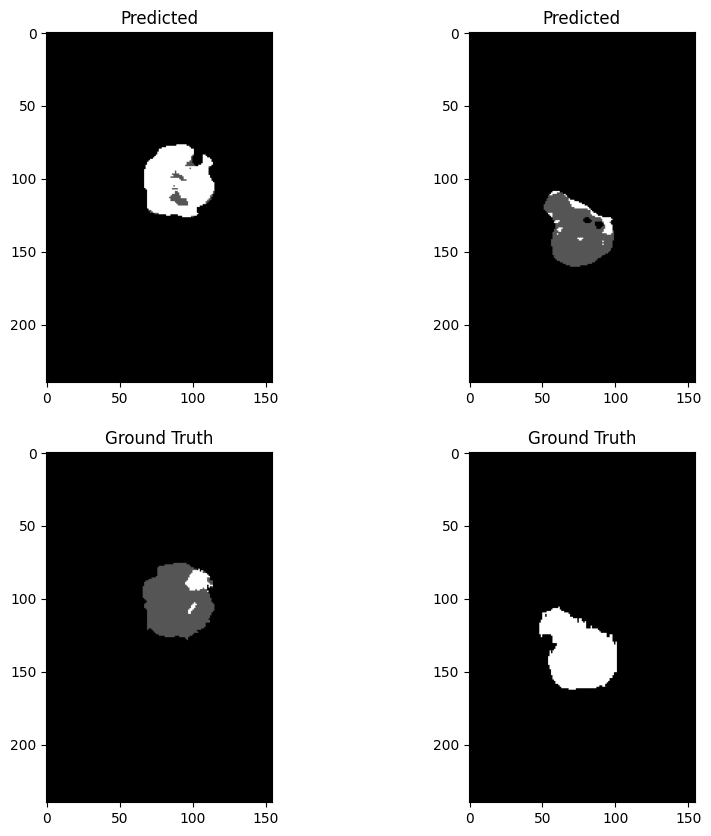

100%|██████████| 48/48 [05:49<00:00,  7.29s/it]


Average Validation Loss: 0.045153466518968344

Average Validation DSC: [0.9952708  0.36074538 0.73263889 0.42193205]
Average Validation ASSD: [  0.50595522 101.61794478  96.78472222  36.47387465]
Epoch 9/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


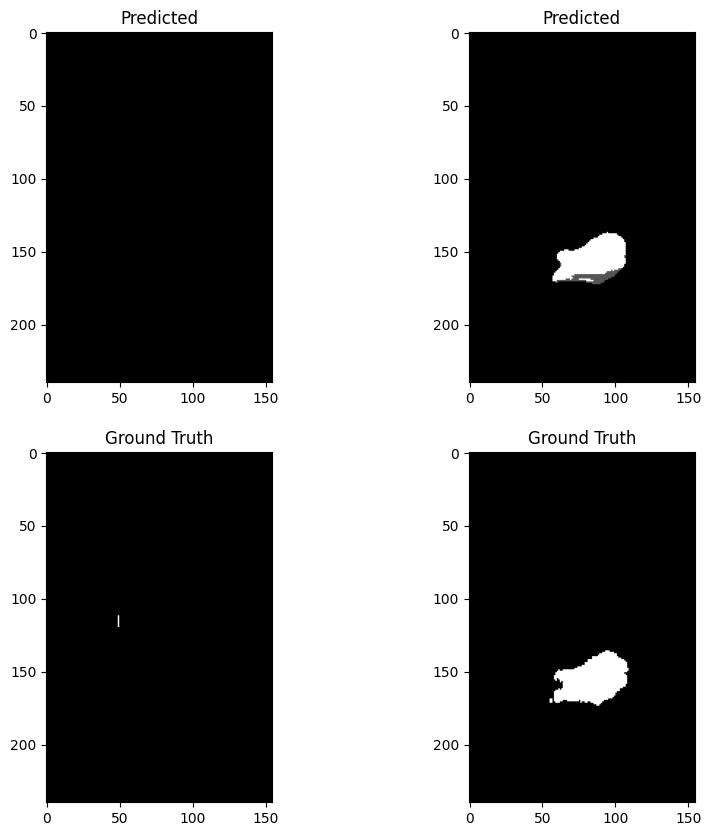

100%|██████████| 189/189 [24:18<00:00,  7.72s/it]



Average Training Loss: 0.04097623423372627

Average Training DSC: [0.99650072 0.41049057 0.73775997 0.41446569]
Average Training ASSD: [  0.41407779 114.12686555  88.64608468  37.44866941]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


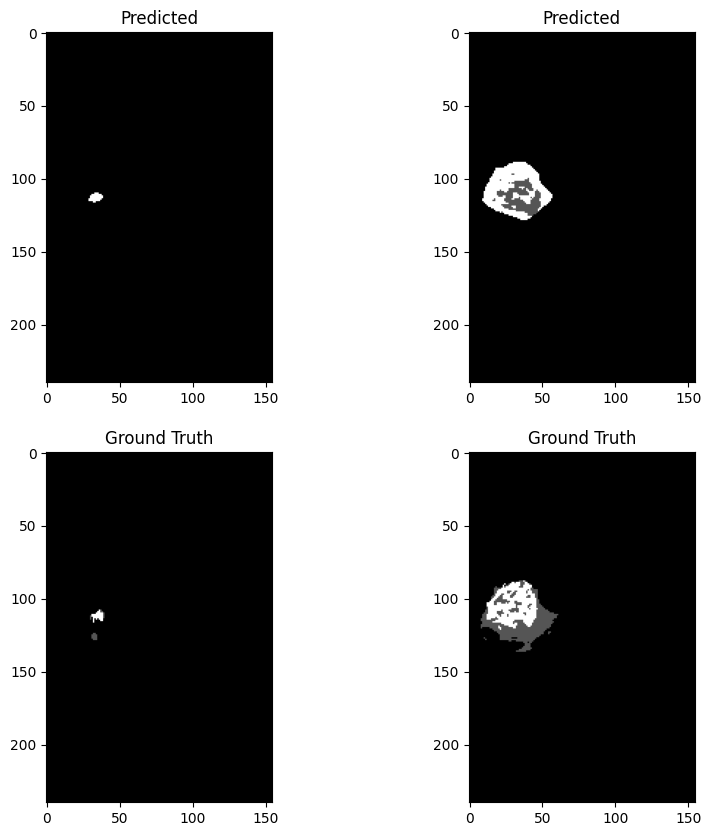

100%|██████████| 48/48 [06:09<00:00,  7.70s/it]


Average Validation Loss: 0.04695059785929819

Average Validation DSC: [0.99583162 0.38022658 0.72088048 0.37817122]
Average Validation ASSD: [  0.52123421 123.15197303  94.08741437  26.51617123]
Epoch 10/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


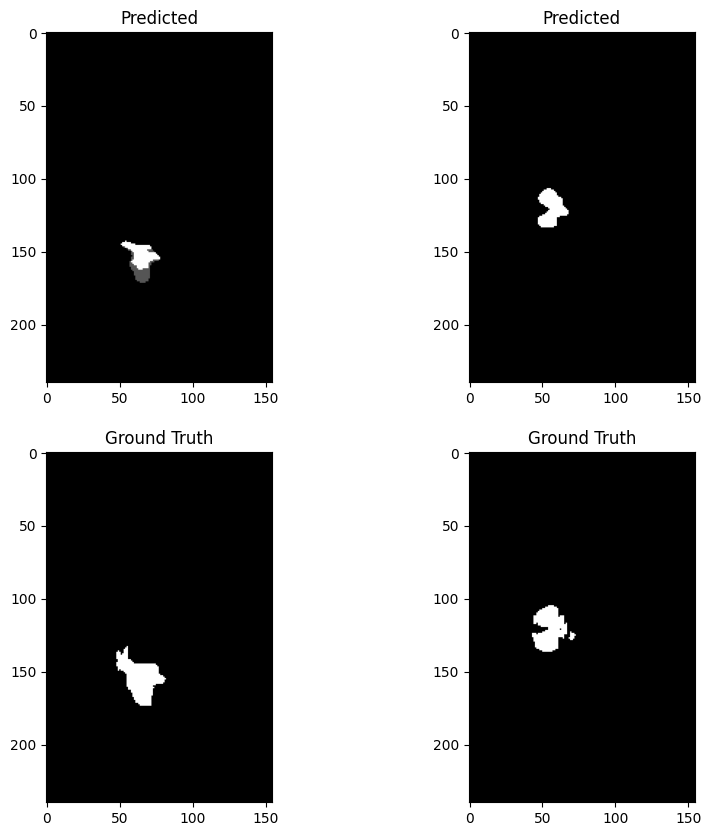

100%|██████████| 189/189 [25:00<00:00,  7.94s/it]



Average Training Loss: 0.03992149004190372

Average Training DSC: [0.99660124 0.41731818 0.6495061  0.43152284]
Average Training ASSD: [  0.39497279 111.41518977  83.0326902   35.43679576]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


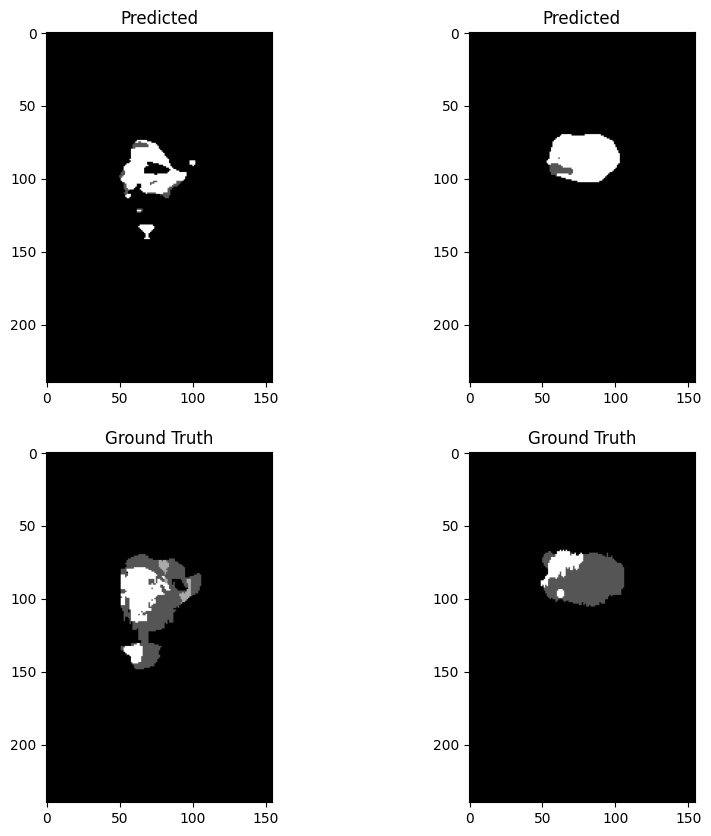

100%|██████████| 48/48 [05:52<00:00,  7.34s/it]


Average Validation Loss: 0.09443511969099443

Average Validation DSC: [0.98943271 0.4494229  0.67149297 0.1922596 ]
Average Validation ASSD: [  1.54093295 105.94346913  83.136815   137.10431681]
Epoch 11/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


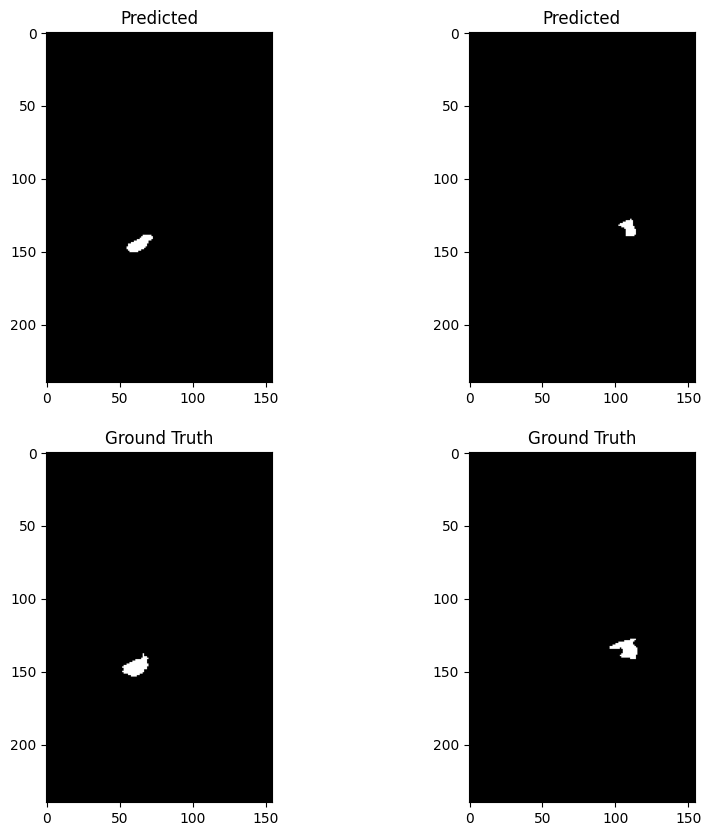

100%|██████████| 189/189 [24:14<00:00,  7.69s/it]



Average Training Loss: 0.03852835595213547

Average Training DSC: [0.99670131 0.43456745 0.60668709 0.44507016]
Average Training ASSD: [  0.38822076 108.1652941   92.51252625  34.97982007]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


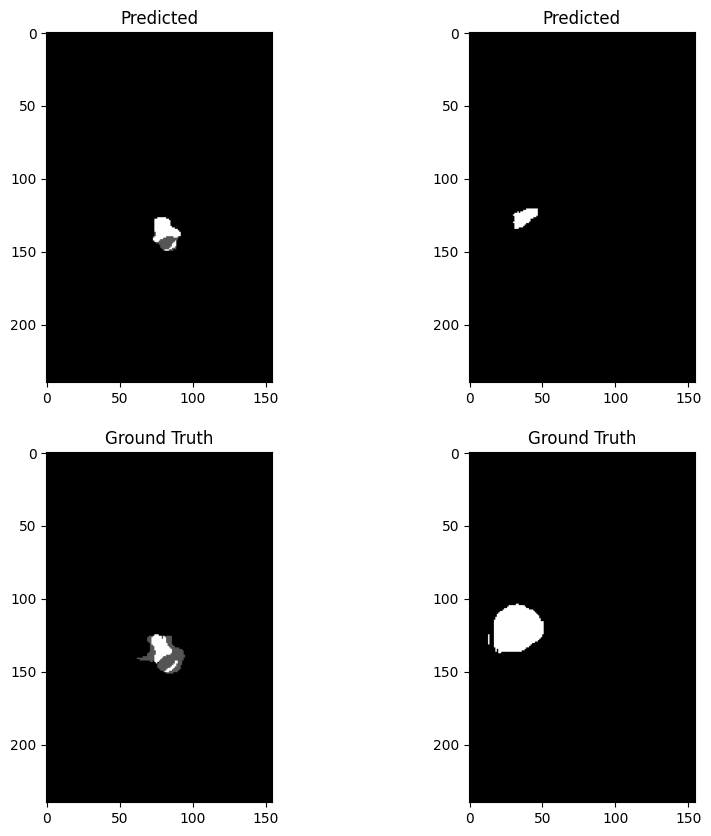

100%|██████████| 48/48 [05:49<00:00,  7.28s/it]


Average Validation Loss: 0.04605237526508669

Average Validation DSC: [0.99599763 0.45413721 0.62956188 0.45305113]
Average Validation ASSD: [ 0.455991   92.43322468 83.00455895 33.14865178]
Epoch 12/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


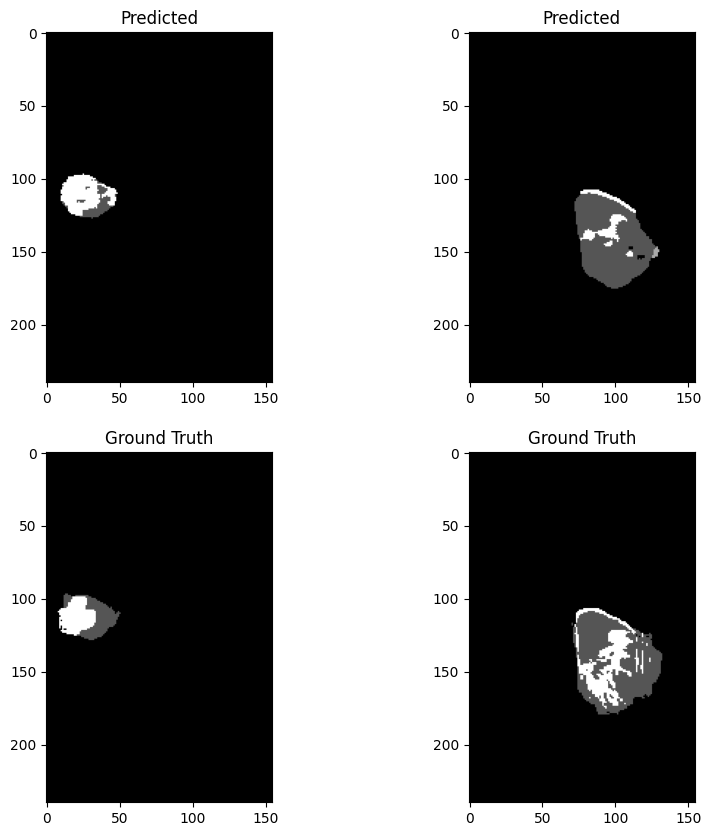

100%|██████████| 189/189 [23:04<00:00,  7.33s/it]



Average Training Loss: 0.03617864000615935

Average Training DSC: [0.9968533  0.46467252 0.63230122 0.47006905]
Average Training ASSD: [  0.36416656 101.64210632  89.42383042  31.86091577]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


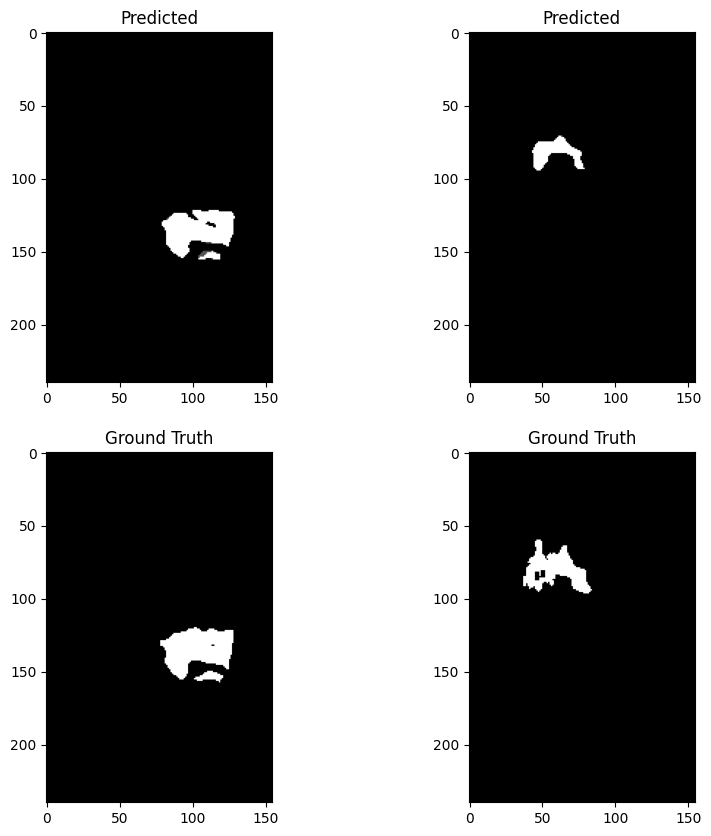

100%|██████████| 48/48 [05:47<00:00,  7.23s/it]


Average Validation Loss: 0.0421124161221087

Average Validation DSC: [0.99557958 0.4629534  0.67574729 0.46452156]
Average Validation ASSD: [ 0.46604026 85.60349726 72.1794197  33.78065988]
Epoch 13/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


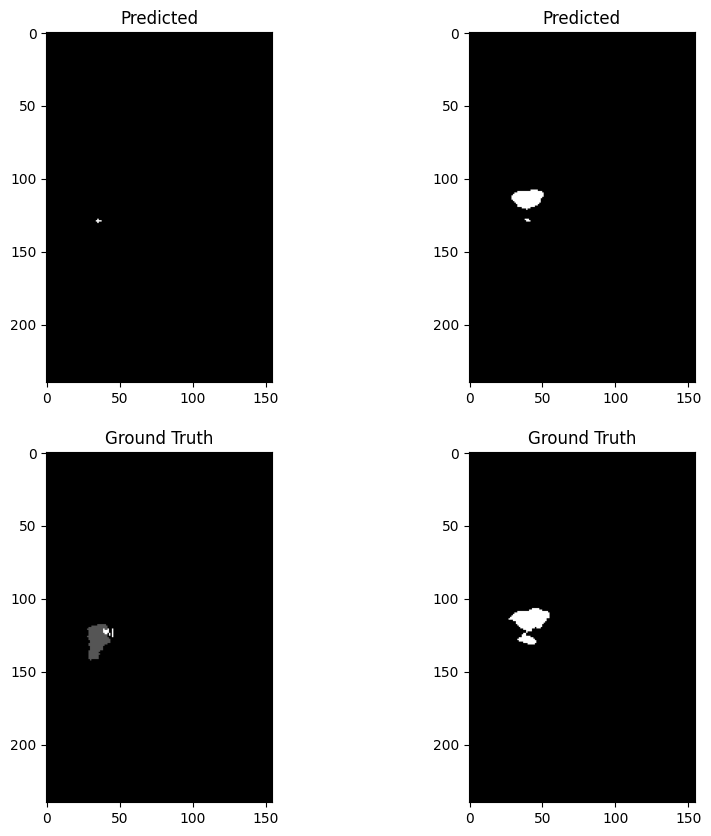

100%|██████████| 189/189 [23:02<00:00,  7.32s/it]



Average Training Loss: 0.03516246000965121

Average Training DSC: [0.99685887 0.48575011 0.6770988  0.47380873]
Average Training ASSD: [ 0.35940199 98.07562566 78.90224984 31.35010261]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


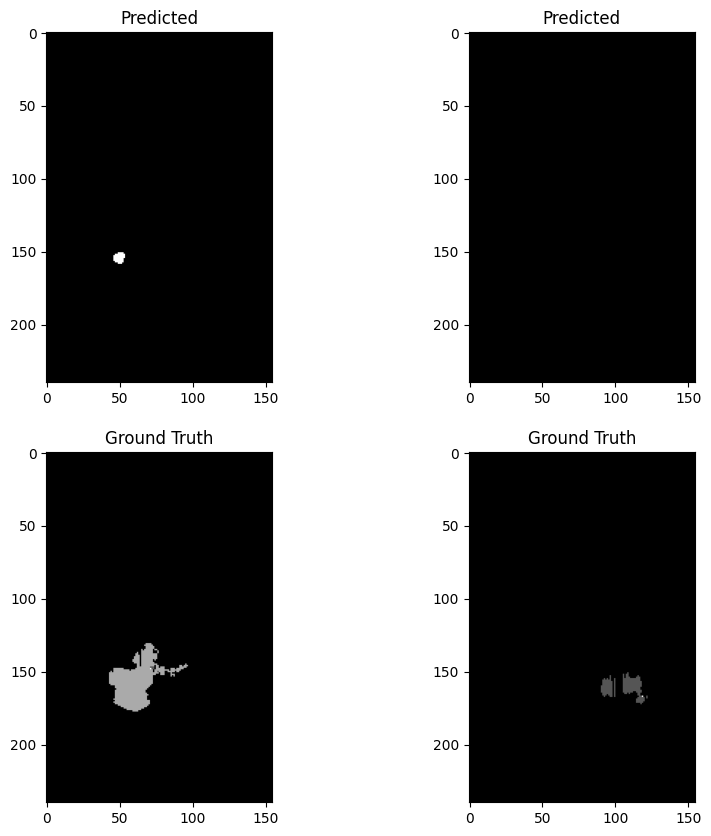

100%|██████████| 48/48 [05:40<00:00,  7.10s/it]


Average Validation Loss: 0.040142372638608016

Average Validation DSC: [0.9961267  0.50026424 0.70029023 0.47410884]
Average Validation ASSD: [ 0.48625162 75.30868547 69.01471927 45.83013958]
Epoch 14/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


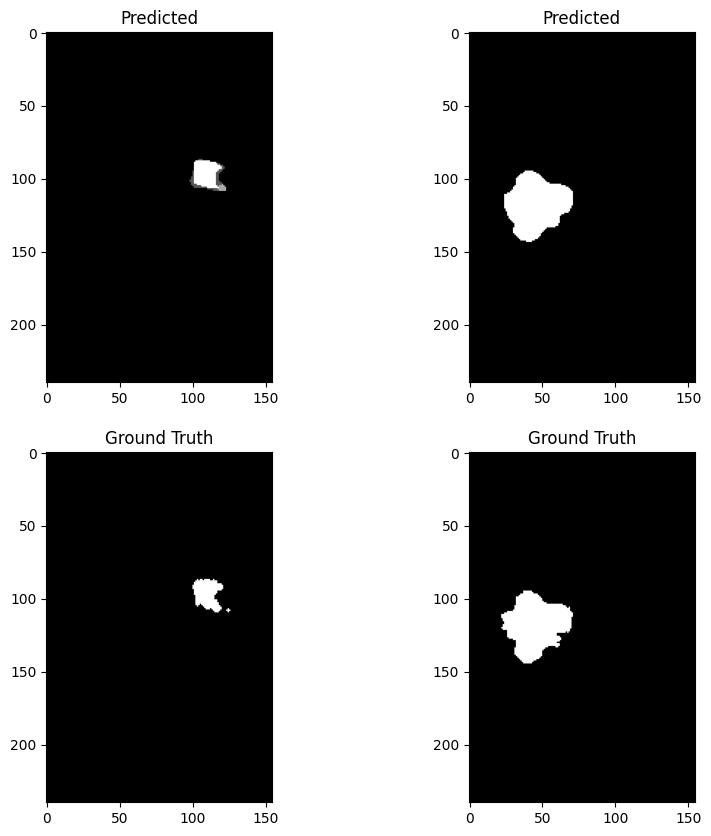

100%|██████████| 189/189 [25:06<00:00,  7.97s/it]



Average Training Loss: 0.0329876901118686

Average Training DSC: [0.99697726 0.52713207 0.713974   0.49675612]
Average Training ASSD: [ 0.3471492  90.18149574 67.41696593 30.76209983]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


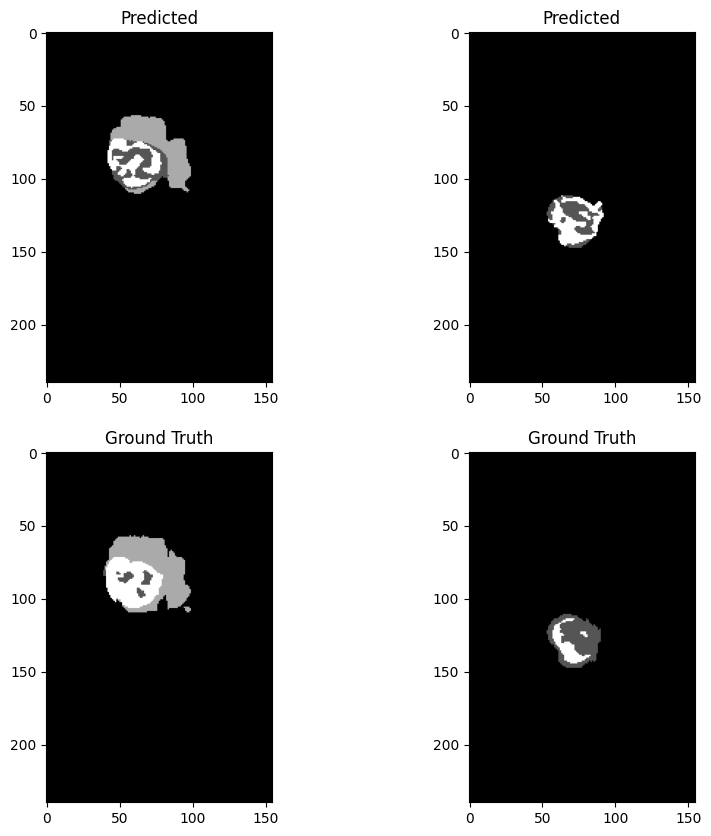

100%|██████████| 48/48 [06:18<00:00,  7.88s/it]


Average Validation Loss: 0.033215269834424056

Average Validation DSC: [0.99693659 0.51116667 0.69473407 0.51673575]
Average Validation ASSD: [ 0.32136089 93.73013536 71.65042586 26.35115532]
Epoch 15/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


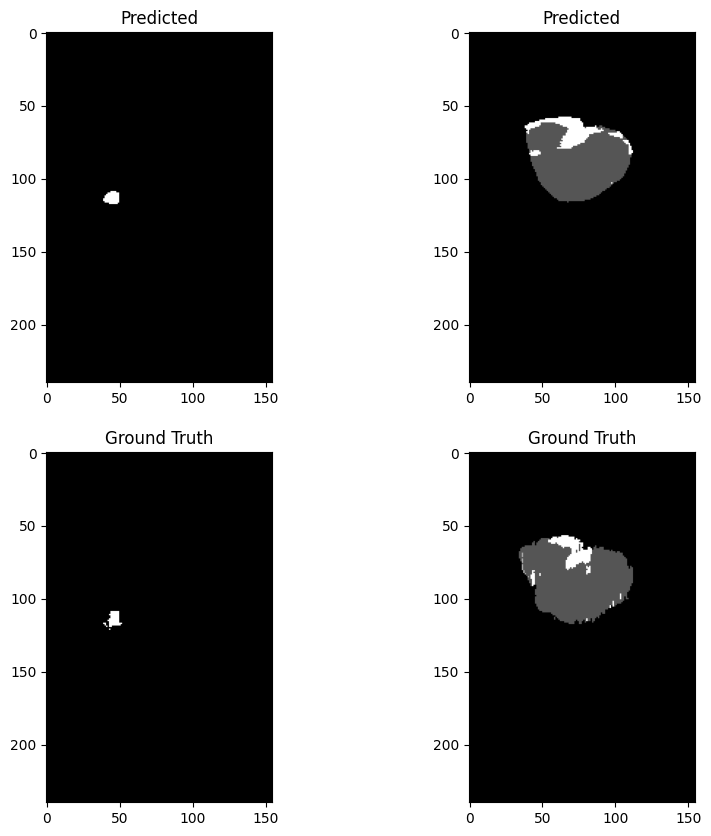

100%|██████████| 189/189 [24:35<00:00,  7.81s/it]



Average Training Loss: 0.03080197984461116

Average Training DSC: [0.99707079 0.56207715 0.74836455 0.51877806]
Average Training ASSD: [ 0.33341745 83.25348569 57.23364279 30.28235788]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


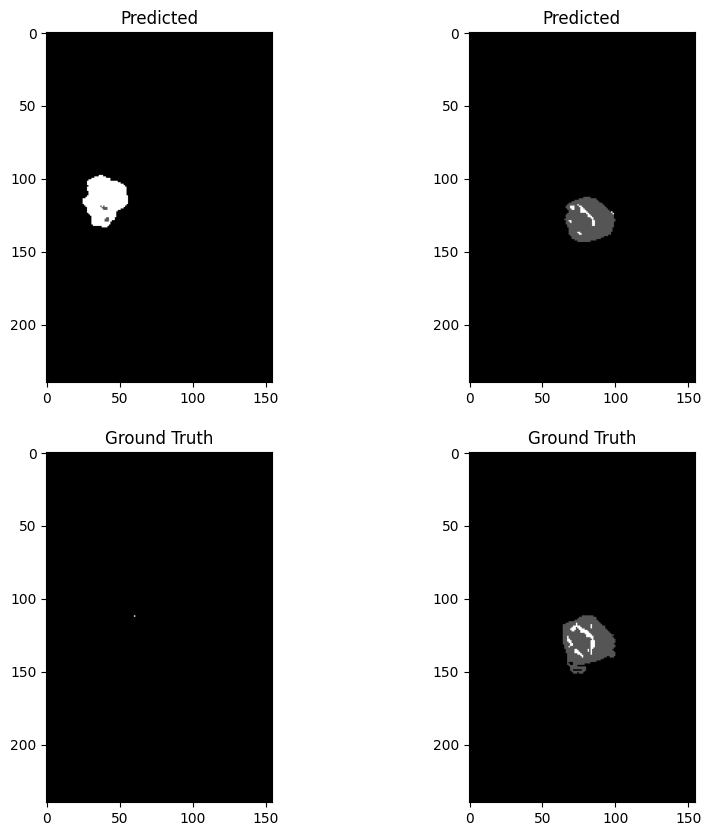

100%|██████████| 48/48 [05:43<00:00,  7.16s/it]


Average Validation Loss: 0.03251554331897447

Average Validation DSC: [0.99669418 0.56292234 0.74322408 0.45096713]
Average Validation ASSD: [ 0.40107599 91.79275424 55.17515433 46.40188661]
Epoch 16/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


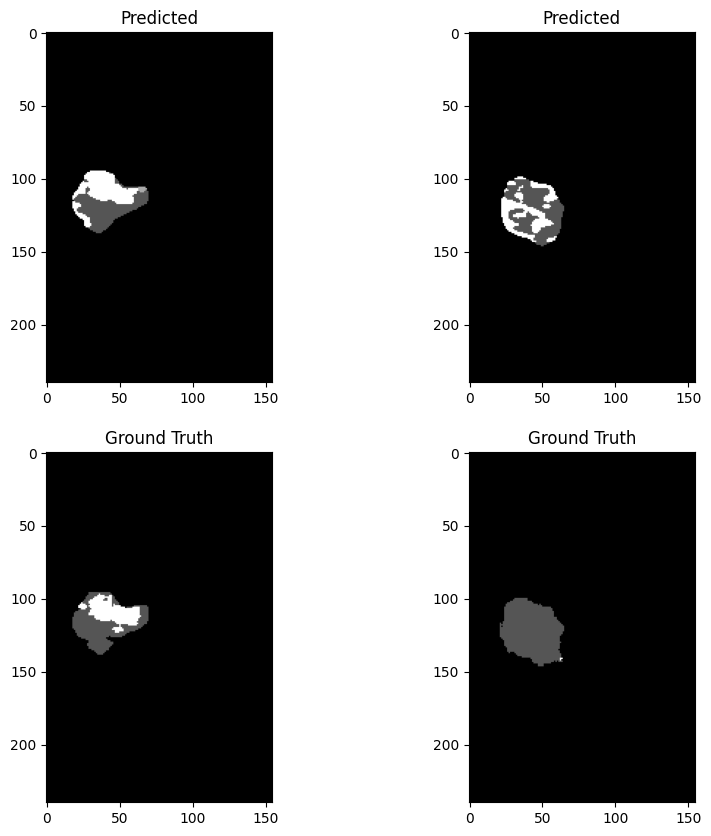

100%|██████████| 189/189 [25:07<00:00,  7.98s/it]



Average Training Loss: 0.028505955798127664

Average Training DSC: [0.99723343 0.61226175 0.76115847 0.53980383]
Average Training ASSD: [ 0.30757634 73.00688906 54.56522654 29.15616569]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


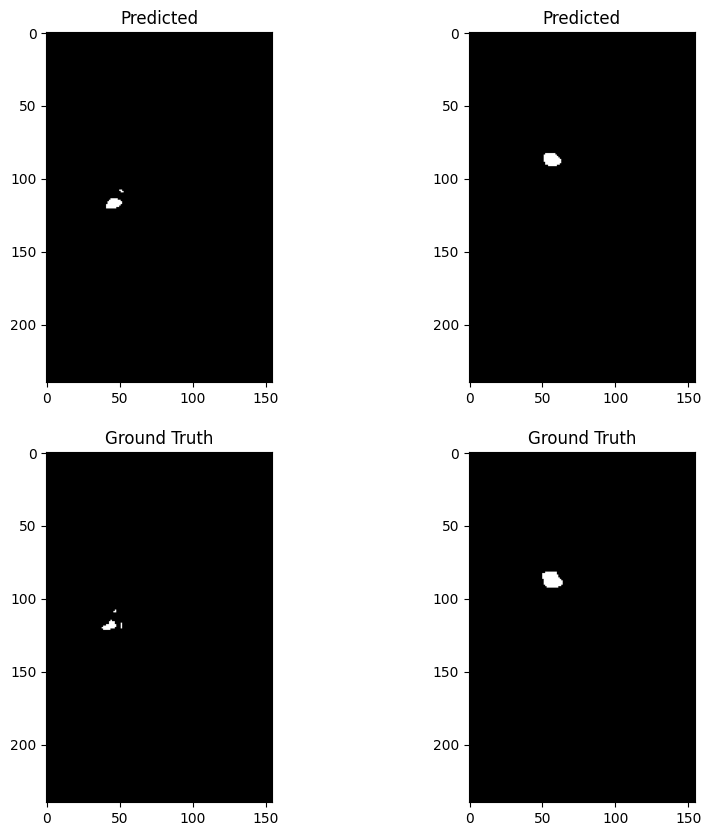

100%|██████████| 48/48 [06:15<00:00,  7.82s/it]


Average Validation Loss: 0.0318801140335078

Average Validation DSC: [0.99685668 0.53295651 0.63968096 0.52105439]
Average Validation ASSD: [  0.37362482 101.20761004  93.27025611  22.78533755]
Epoch 17/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


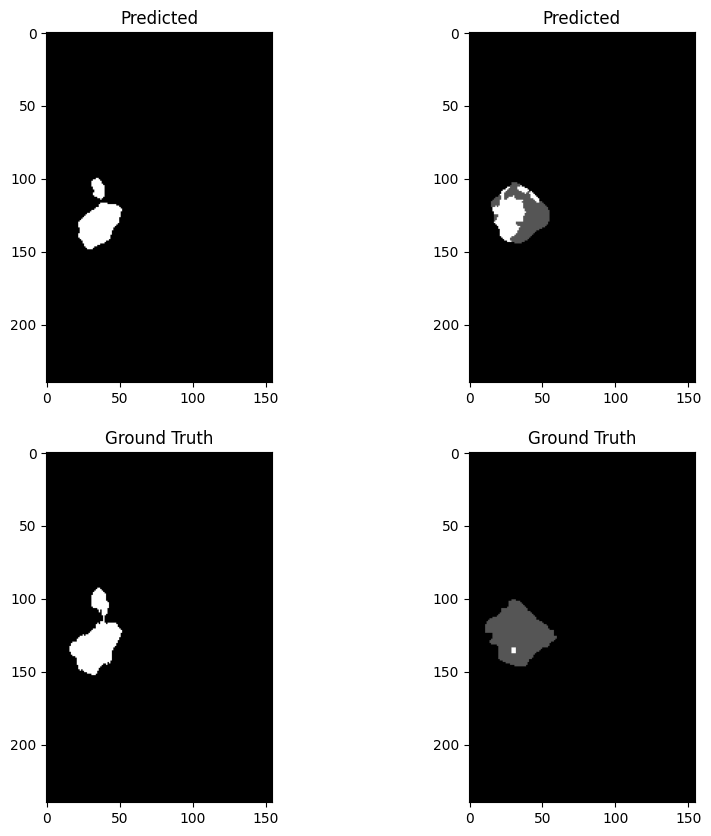

100%|██████████| 189/189 [24:31<00:00,  7.79s/it]



Average Training Loss: 0.026877022313850897

Average Training DSC: [0.99731073 0.64944914 0.78965343 0.55462008]
Average Training ASSD: [ 0.29894029 64.1068234  44.79289914 28.69829224]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


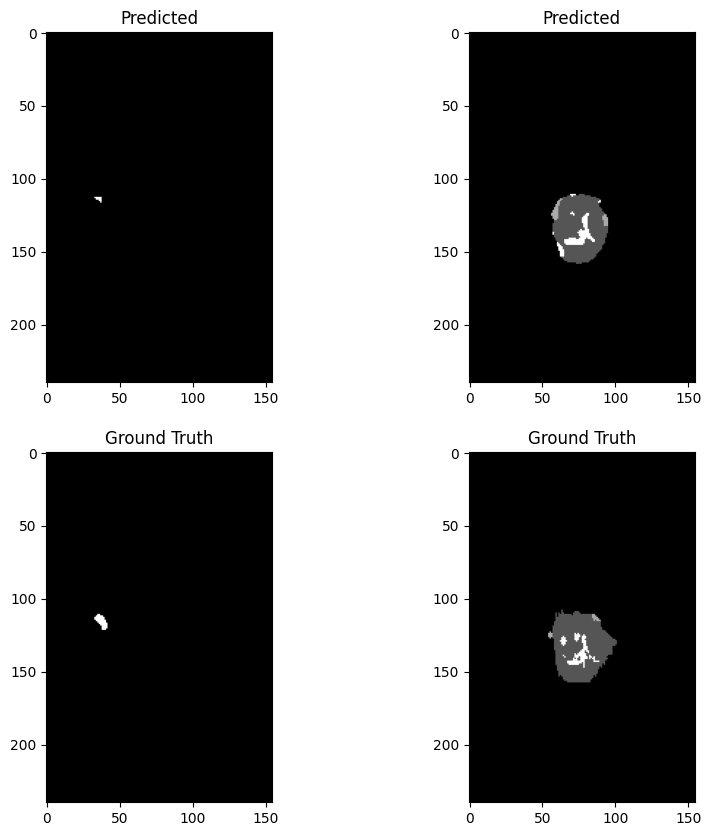

100%|██████████| 48/48 [05:58<00:00,  7.46s/it]


Average Validation Loss: 0.02829548856243491

Average Validation DSC: [0.99705049 0.62152743 0.70703875 0.51477128]
Average Validation ASSD: [ 0.32498471 75.3446612  69.8176906  37.69259745]
Epoch 18/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


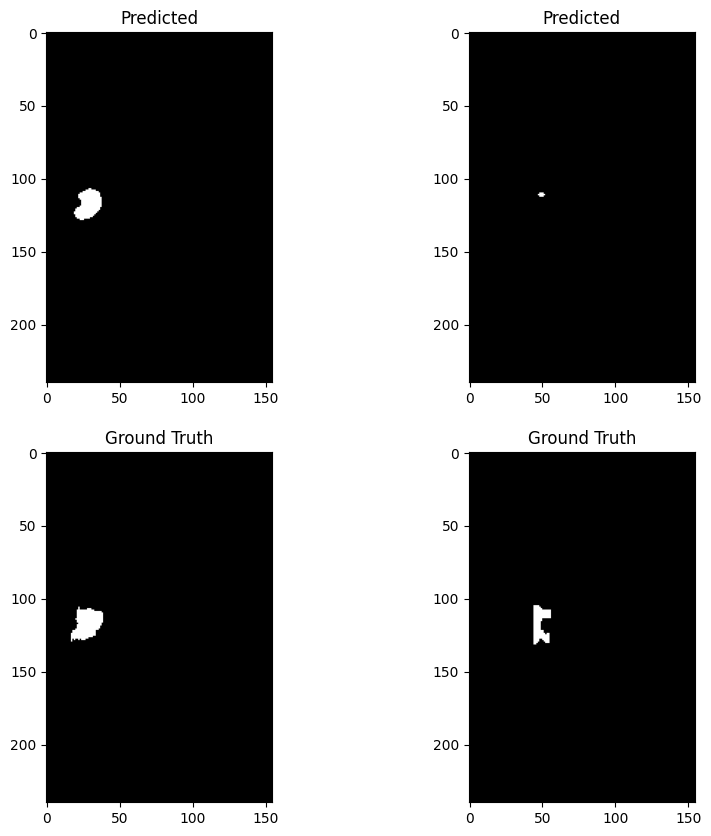

100%|██████████| 189/189 [25:22<00:00,  8.05s/it]



Average Training Loss: 0.024783302719394367

Average Training DSC: [0.99743782 0.68493863 0.80258361 0.57487177]
Average Training ASSD: [ 0.28327669 55.60085993 41.81703725 29.2797056 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


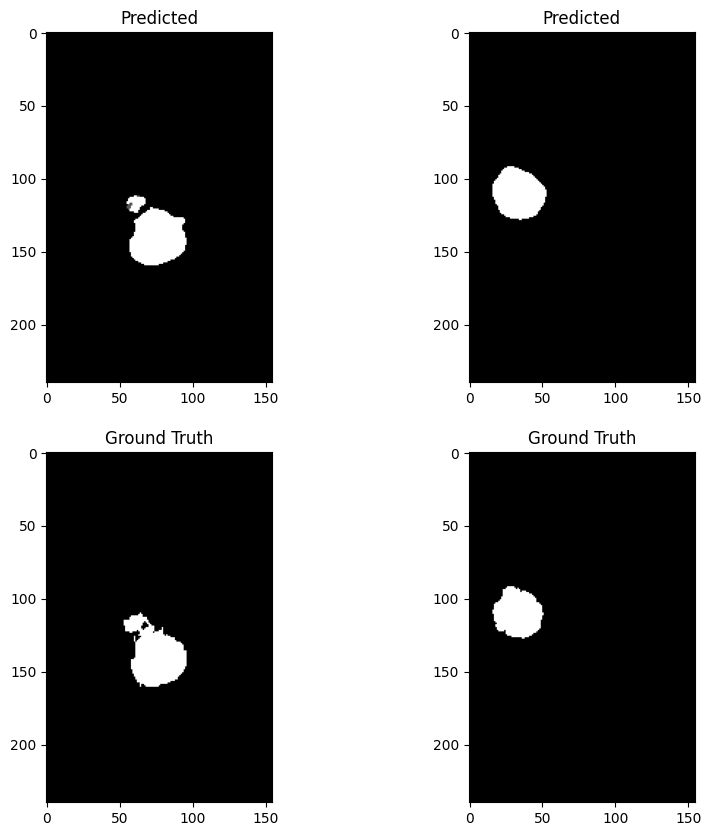

100%|██████████| 48/48 [06:22<00:00,  7.96s/it]


Average Validation Loss: 0.02530554379336536

Average Validation DSC: [0.99746323 0.68457061 0.83577307 0.59103673]
Average Validation ASSD: [ 0.25278561 56.93293036 35.16888799 20.91498576]
Epoch 19/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


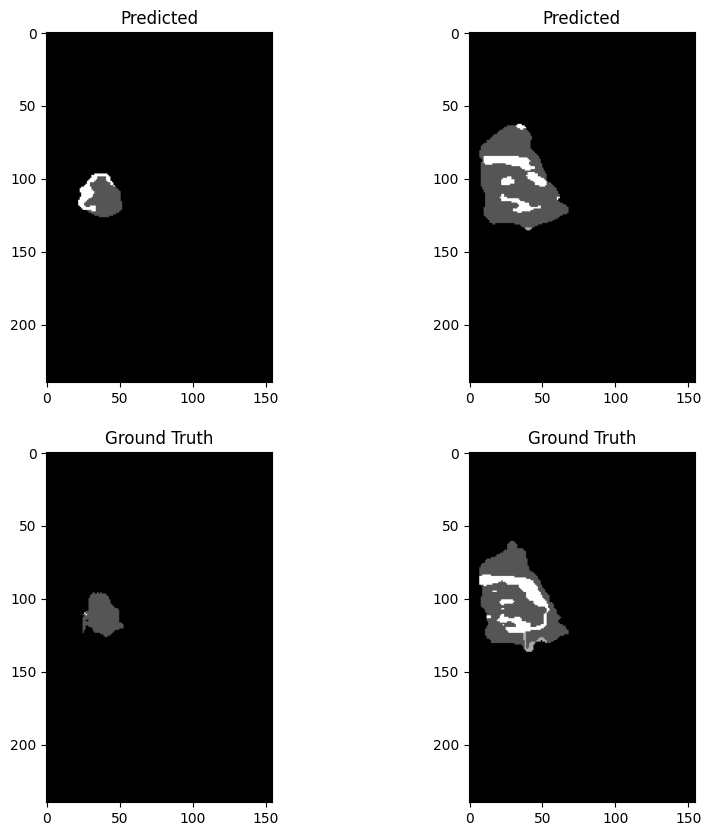

100%|██████████| 189/189 [25:04<00:00,  7.96s/it]



Average Training Loss: 0.02395747322589159

Average Training DSC: [0.99751282 0.70403408 0.81405799 0.57989995]
Average Training ASSD: [ 0.27056153 50.72009044 39.20862071 29.38382147]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


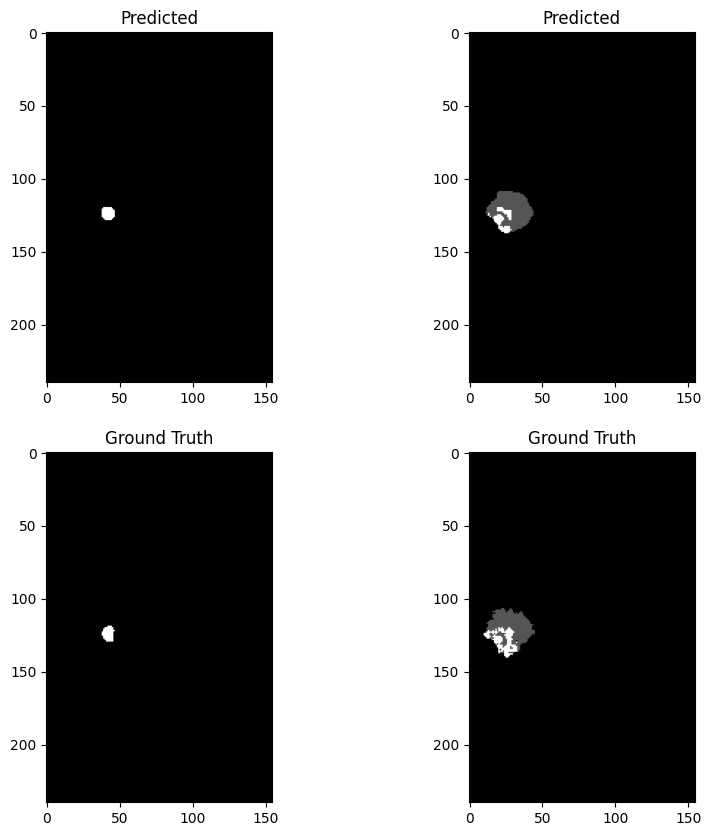

100%|██████████| 48/48 [06:05<00:00,  7.62s/it]


Average Validation Loss: 0.02498792977227519

Average Validation DSC: [0.99725935 0.65218217 0.79906564 0.57228792]
Average Validation ASSD: [ 0.27456063 69.031893   44.07885017 31.29090804]
Epoch 20/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


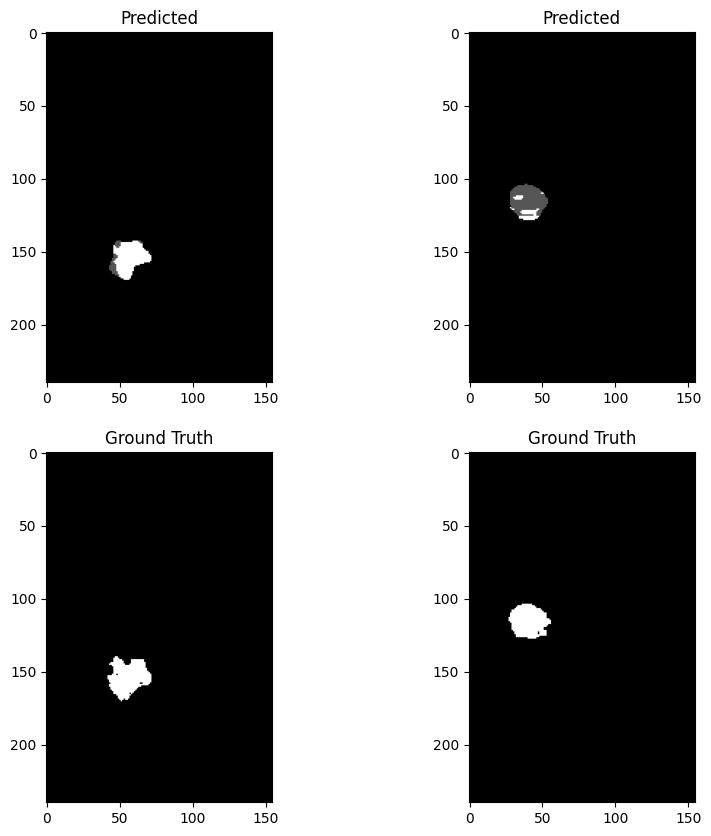

100%|██████████| 189/189 [24:52<00:00,  7.90s/it]



Average Training Loss: 0.02214134707258492

Average Training DSC: [0.99762161 0.73086549 0.83153299 0.59935051]
Average Training ASSD: [ 0.25914294 44.56760827 34.00439699 29.41875623]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


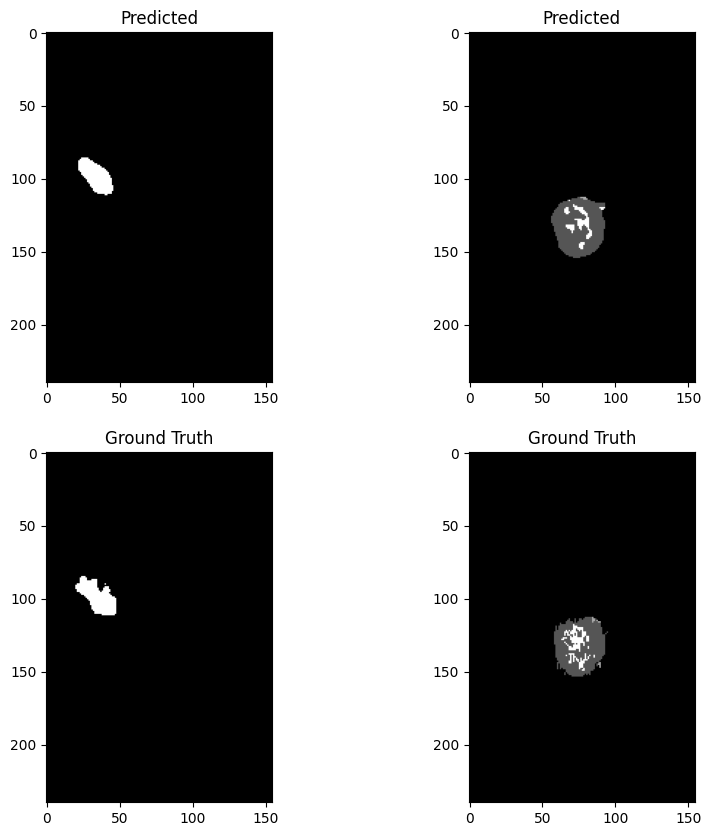

100%|██████████| 48/48 [06:03<00:00,  7.57s/it]


Average Validation Loss: 0.023801635368727148

Average Validation DSC: [0.99759219 0.71229484 0.79472251 0.57517674]
Average Validation ASSD: [ 0.24875051 50.1870337  48.36169103 22.36031925]
Epoch 21/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


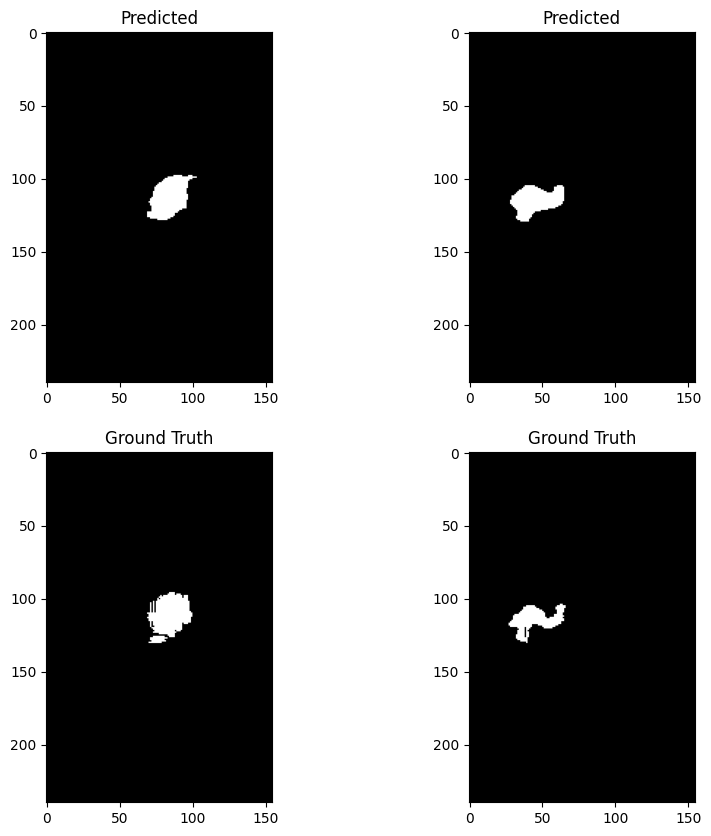

100%|██████████| 189/189 [23:54<00:00,  7.59s/it]



Average Training Loss: 0.021107916296435096

Average Training DSC: [0.99771718 0.7468752  0.85150967 0.61122574]
Average Training ASSD: [ 0.25090554 41.1028003  27.65308913 29.956934  ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


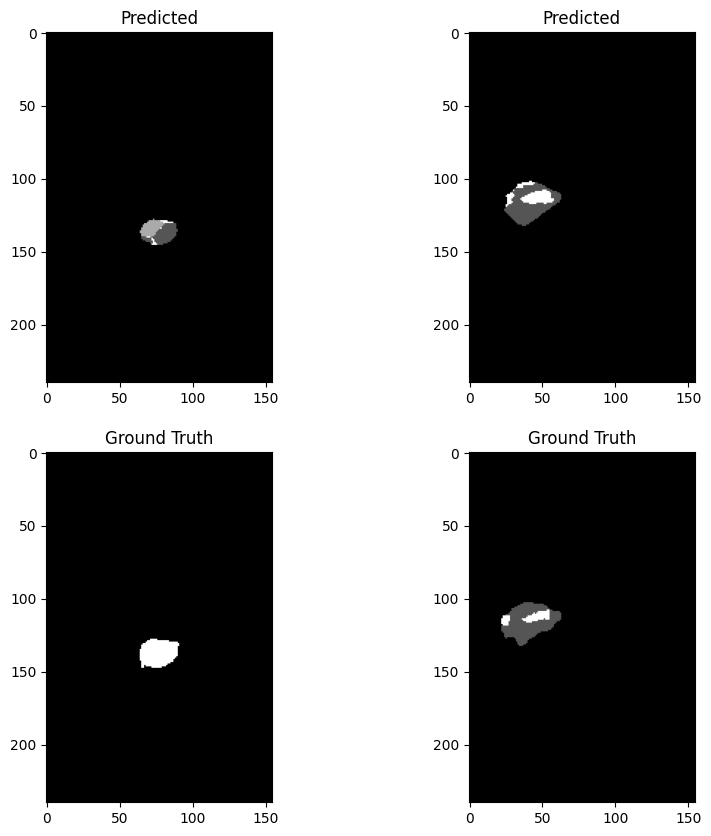

100%|██████████| 48/48 [06:29<00:00,  8.12s/it]


Average Validation Loss: 0.022721658344380558

Average Validation DSC: [0.99752356 0.73797336 0.78253589 0.60941191]
Average Validation ASSD: [ 0.26357738 41.54954131 50.58814228 27.86744727]
Epoch 22/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


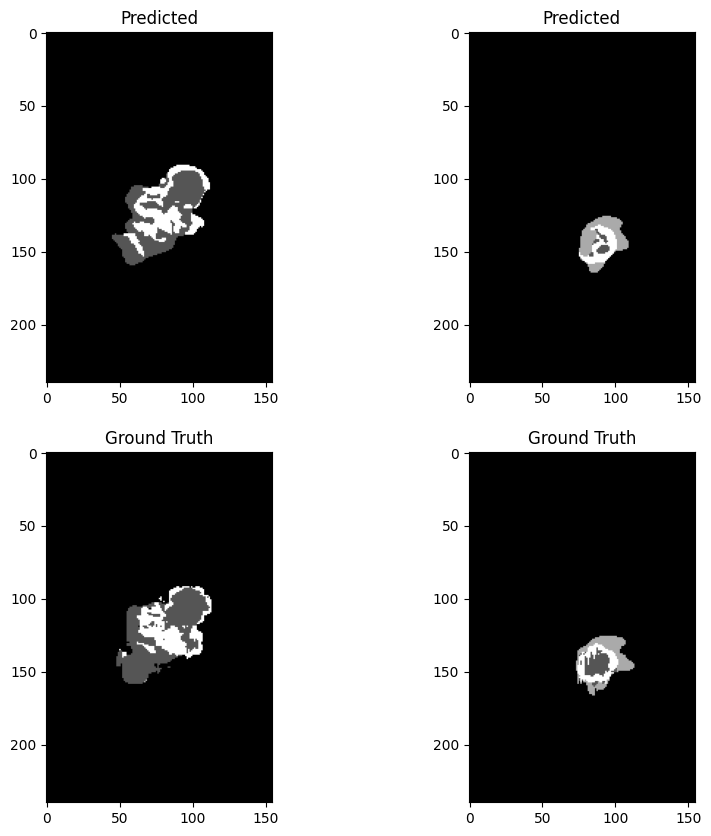

100%|██████████| 189/189 [24:34<00:00,  7.80s/it]



Average Training Loss: 0.019901229177044812

Average Training DSC: [0.99777625 0.76838645 0.86137119 0.62299202]
Average Training ASSD: [ 0.2407896  35.87445212 26.61351025 29.76148049]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


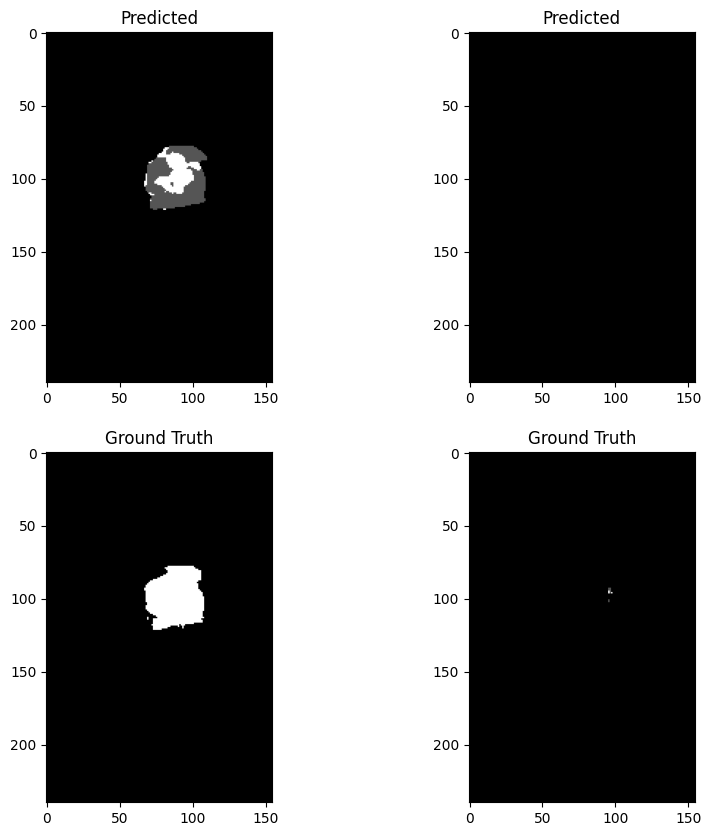

100%|██████████| 48/48 [05:49<00:00,  7.29s/it]


Average Validation Loss: 0.022512598234849673

Average Validation DSC: [0.99764251 0.69292168 0.83019292 0.6384878 ]
Average Validation ASSD: [ 0.22820961 57.33231065 37.37198515 18.10864656]
Epoch 23/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


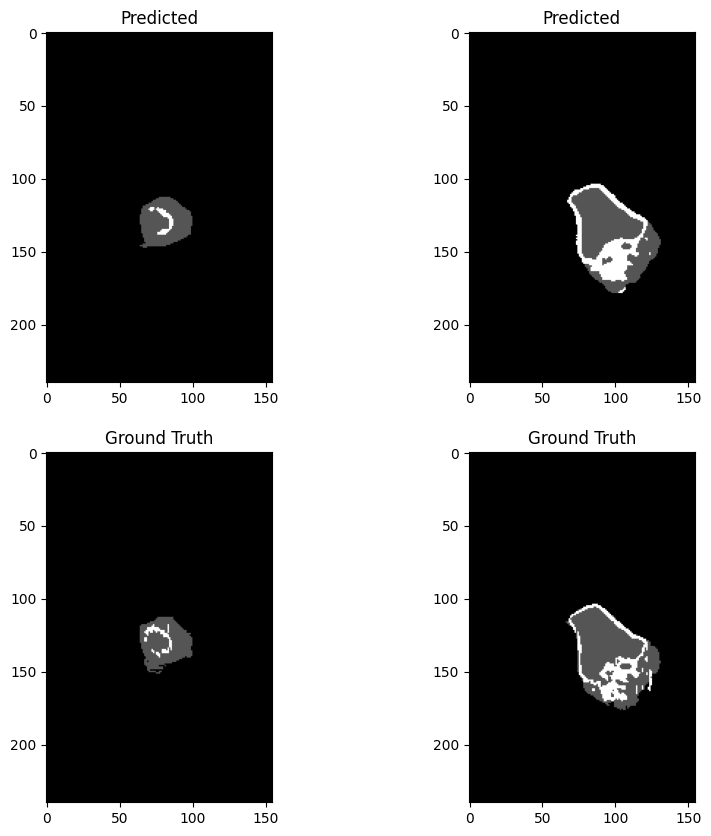

100%|██████████| 189/189 [25:15<00:00,  8.02s/it]



Average Training Loss: 0.019197735866462742

Average Training DSC: [0.99782616 0.78006559 0.86352393 0.63225342]
Average Training ASSD: [ 0.23385712 33.72477075 25.98752766 28.2821666 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


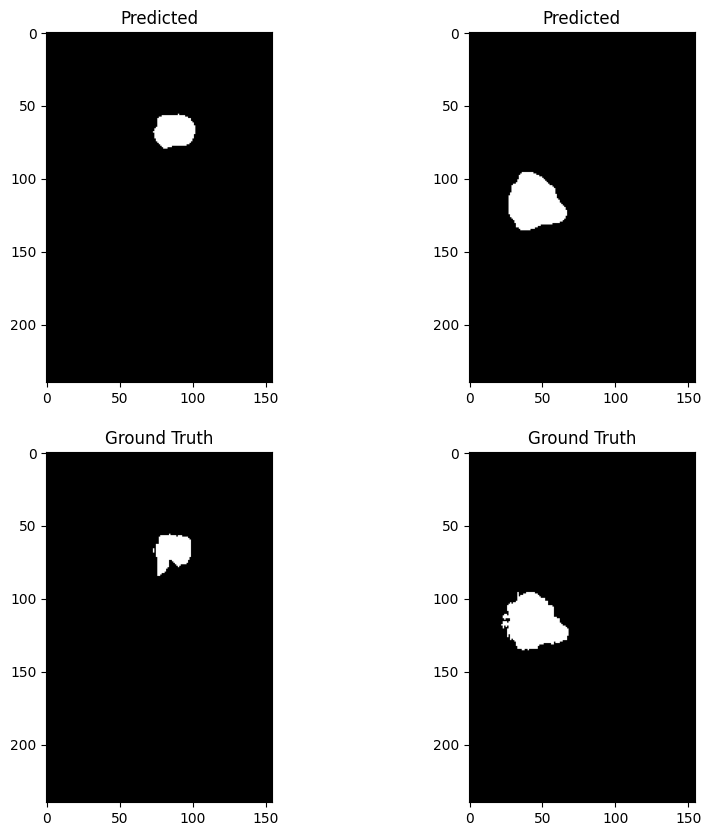

100%|██████████| 48/48 [06:11<00:00,  7.75s/it]


Average Validation Loss: 0.02098919920778523

Average Validation DSC: [0.99767545 0.76638901 0.85660194 0.63555548]
Average Validation ASSD: [ 0.25032724 29.30276017 29.2912421  26.55006453]
Epoch 24/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


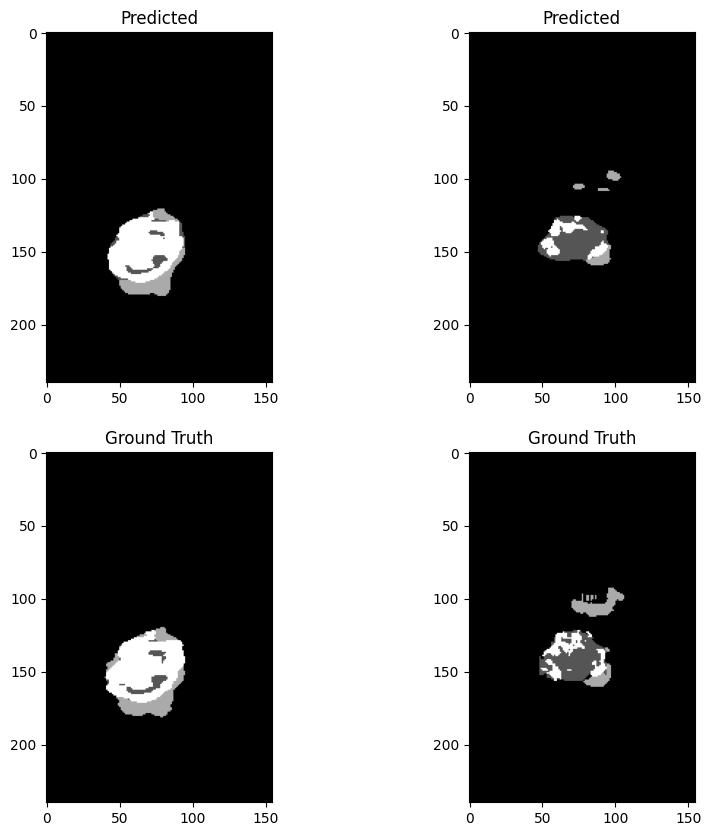

100%|██████████| 189/189 [24:37<00:00,  7.82s/it]



Average Training Loss: 0.017965211592141598

Average Training DSC: [0.99793391 0.80328235 0.87563434 0.64386615]
Average Training ASSD: [ 0.22036676 27.87542739 23.3689172  29.30479049]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


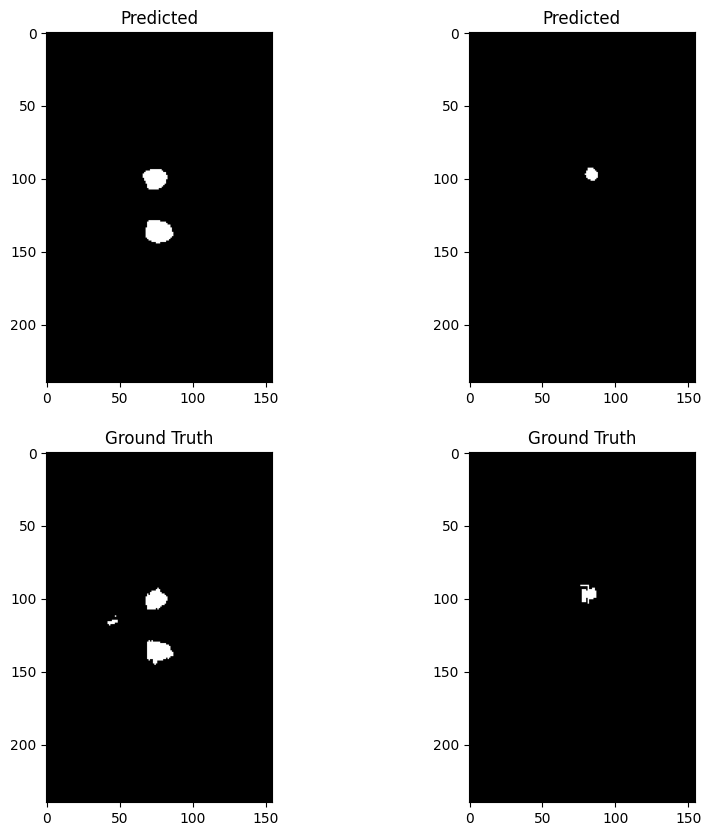

100%|██████████| 48/48 [05:56<00:00,  7.43s/it]


Average Validation Loss: 0.019714720372576267

Average Validation DSC: [0.99781221 0.76448005 0.86354613 0.61784409]
Average Validation ASSD: [ 0.21774576 41.41107193 26.80090499 31.28144805]
Epoch 25/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


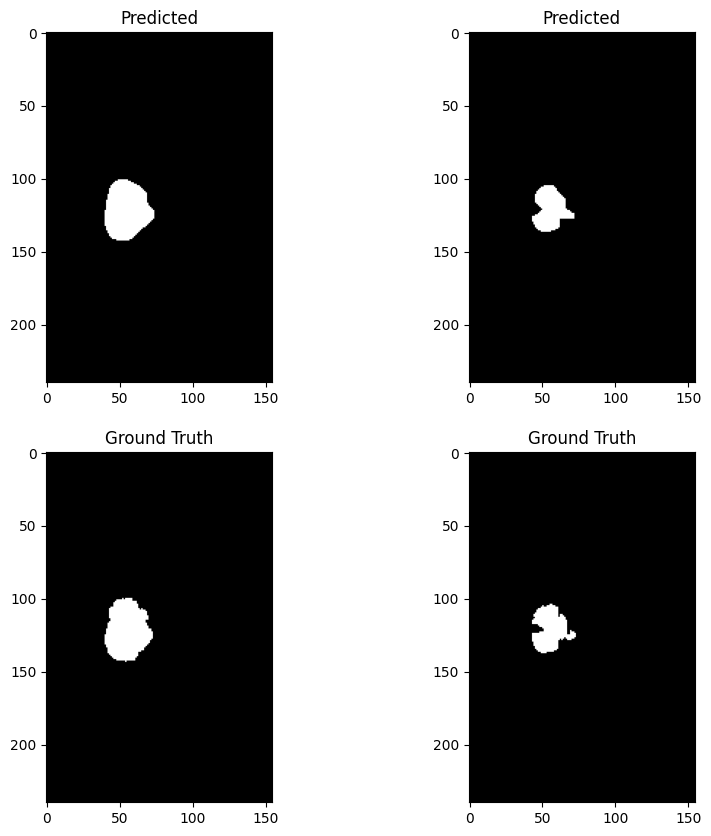

100%|██████████| 189/189 [25:10<00:00,  7.99s/it]



Average Training Loss: 0.017464876869722964

Average Training DSC: [0.99797432 0.81053742 0.87915951 0.65066321]
Average Training ASSD: [ 0.21786793 27.15247146 22.49021548 29.64781452]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


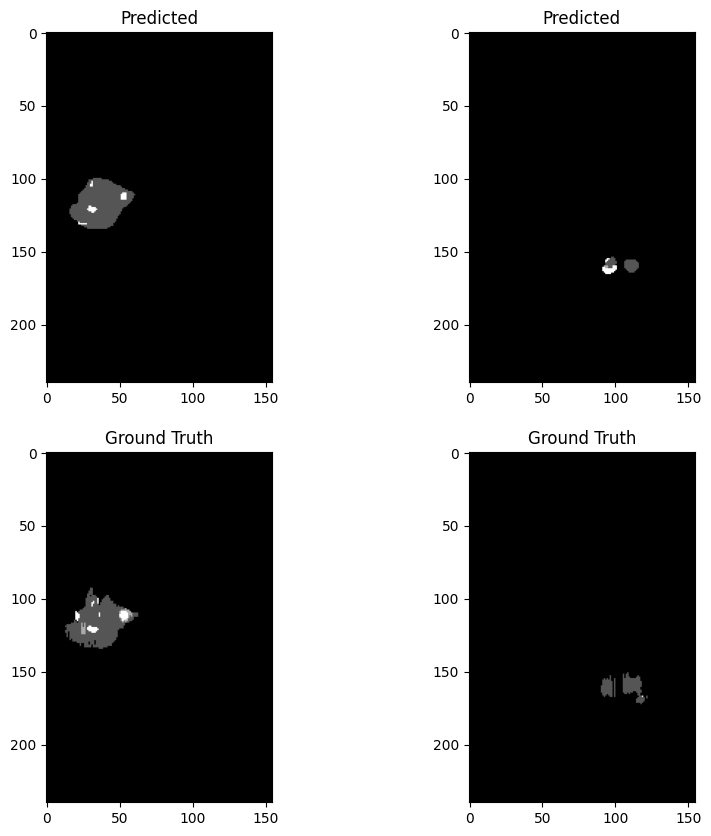

100%|██████████| 48/48 [06:15<00:00,  7.83s/it]


Average Validation Loss: 0.020017381699290127

Average Validation DSC: [0.99777486 0.7342991  0.85392892 0.6519346 ]
Average Validation ASSD: [ 0.23116325 52.11831709 28.82755367 18.56074146]
Epoch 26/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


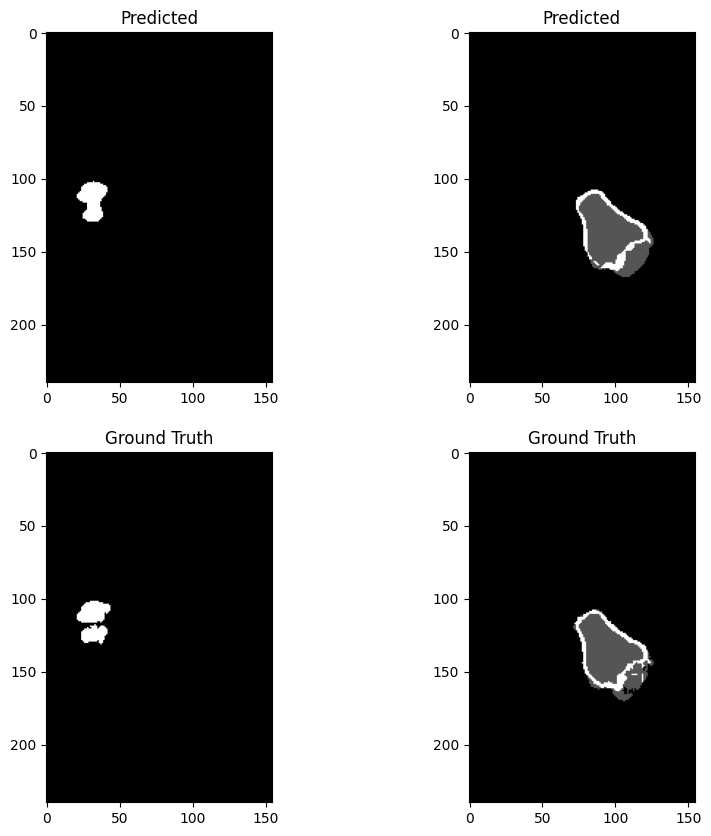

100%|██████████| 189/189 [25:23<00:00,  8.06s/it]



Average Training Loss: 0.017139865854193293

Average Training DSC: [0.99799019 0.81331477 0.87961534 0.65392391]
Average Training ASSD: [ 0.21363093 26.57865242 22.83609409 30.1470131 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


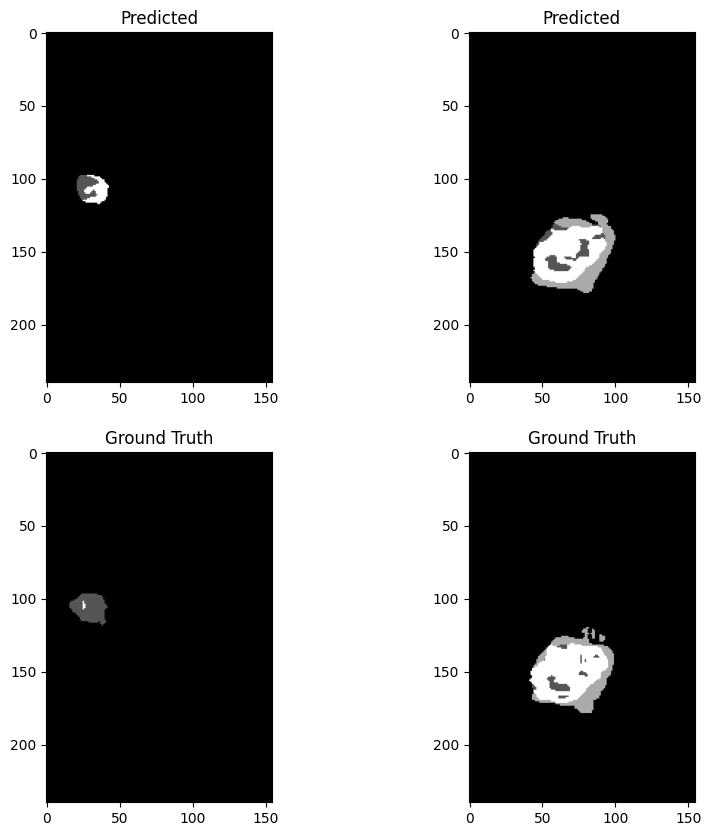

100%|██████████| 48/48 [06:08<00:00,  7.68s/it]


Average Validation Loss: 0.019366559960568946

Average Validation DSC: [0.99792219 0.80246837 0.86851668 0.6584553 ]
Average Validation ASSD: [ 0.21079615 25.45751439 24.18504393 20.19244503]
Epoch 27/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


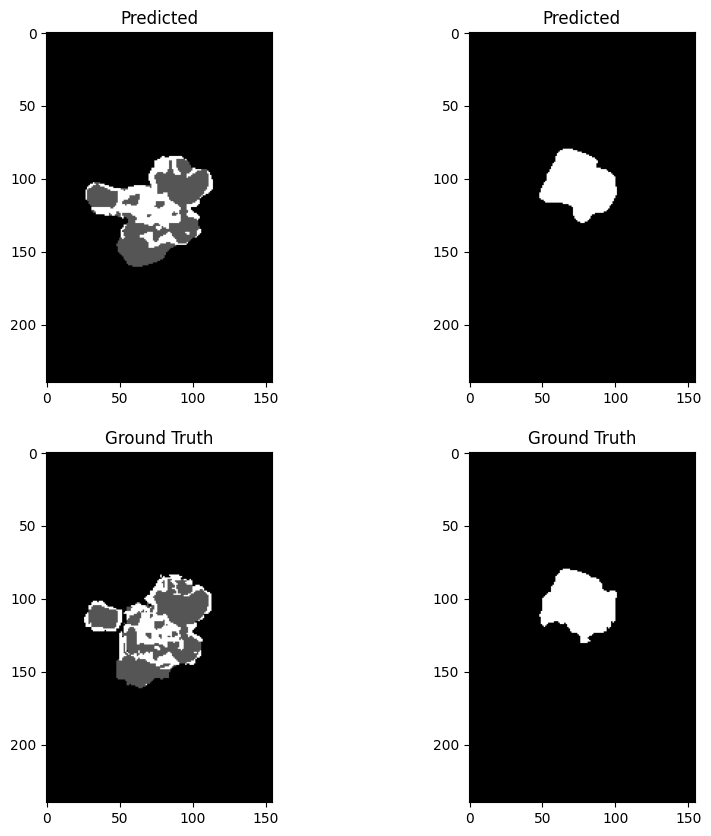

100%|██████████| 189/189 [25:52<00:00,  8.21s/it]



Average Training Loss: 0.016465590153106308

Average Training DSC: [0.99806836 0.82205324 0.88551598 0.66017223]
Average Training ASSD: [ 0.20928272 25.00860626 21.56018147 29.91852488]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


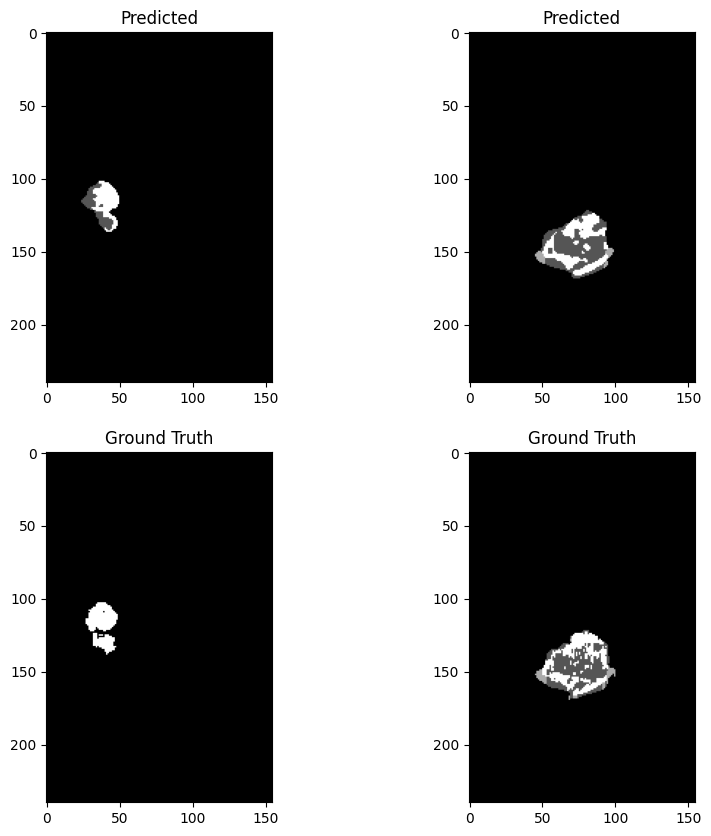

100%|██████████| 48/48 [05:51<00:00,  7.32s/it]


Average Validation Loss: 0.0175808403097714

Average Validation DSC: [0.99804315 0.78119802 0.87375437 0.67045239]
Average Validation ASSD: [ 0.20479639 38.14301457 24.88651003 22.07785354]
Epoch 28/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


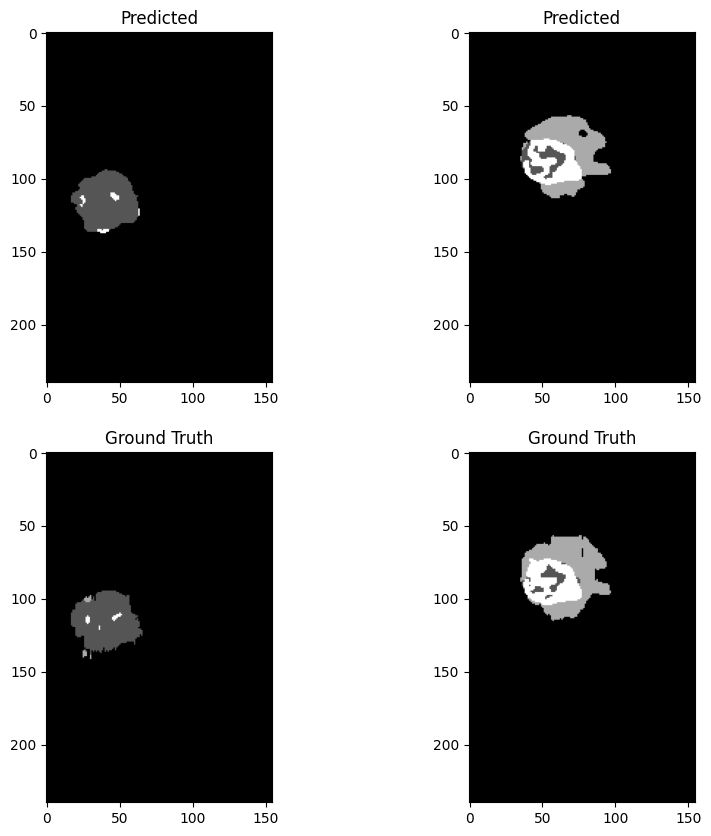

100%|██████████| 189/189 [24:45<00:00,  7.86s/it]



Average Training Loss: 0.014699788409329596

Average Training DSC: [0.99822195 0.84681389 0.89638398 0.67819793]
Average Training ASSD: [ 0.18976394 19.60367772 19.02890847 30.32524302]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


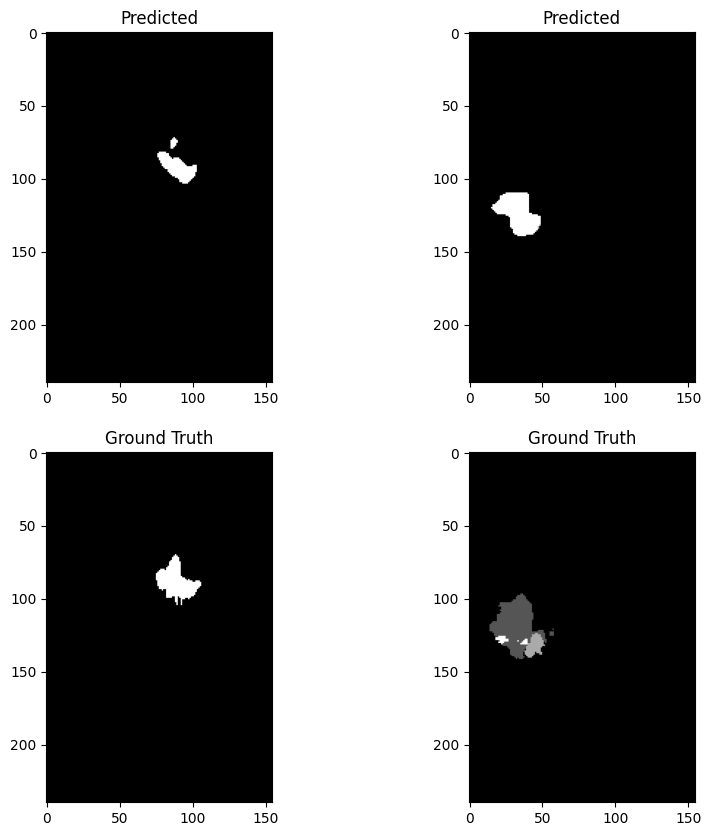

100%|██████████| 48/48 [06:03<00:00,  7.58s/it]


Average Validation Loss: 0.02179300618202736

Average Validation DSC: [0.99745697 0.80920222 0.8623483  0.61430919]
Average Validation ASSD: [ 0.2837986  26.49283729 26.39833441 34.20883277]
Epoch 29/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


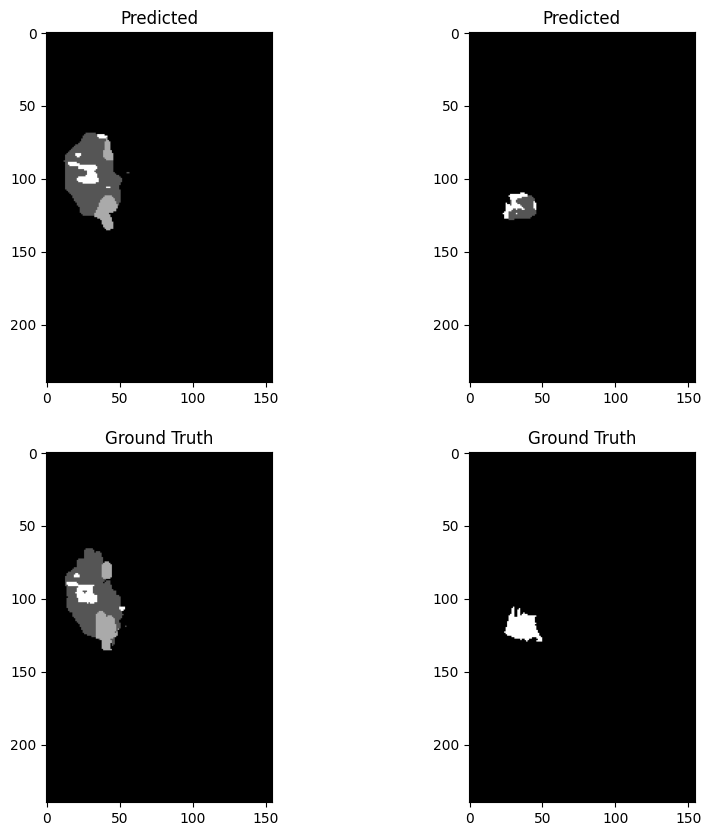

100%|██████████| 189/189 [25:11<00:00,  8.00s/it]



Average Training Loss: 0.015391184987805824

Average Training DSC: [0.99818164 0.83815442 0.88754277 0.67187647]
Average Training ASSD: [ 0.19067611 21.94993951 21.9713158  30.01214757]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


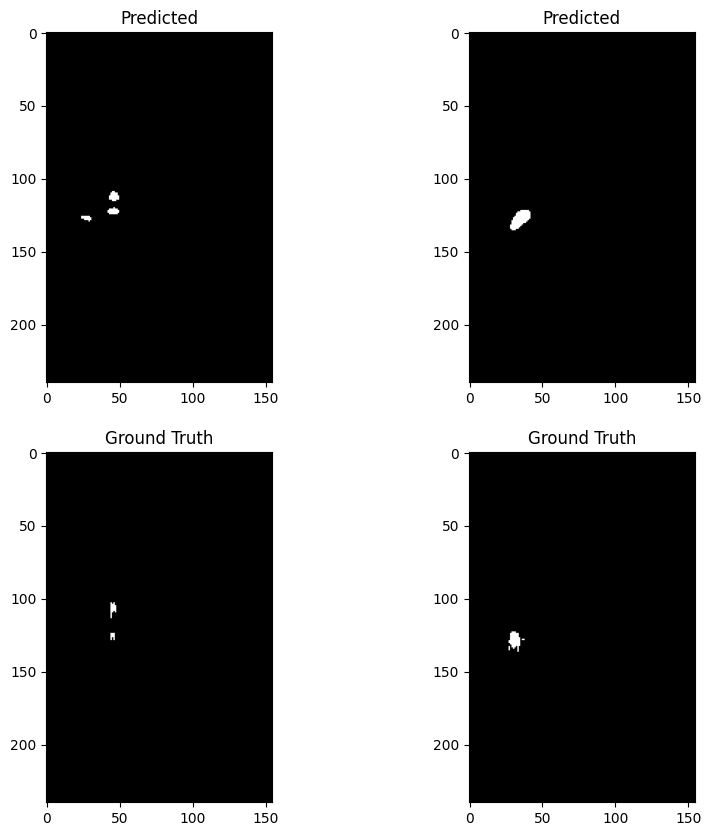

100%|██████████| 48/48 [05:53<00:00,  7.36s/it]


Average Validation Loss: 0.018679932109080255

Average Validation DSC: [0.99799486 0.7969441  0.87696107 0.67349356]
Average Validation ASSD: [ 0.19459154 26.32467675 22.45202433 17.64684257]
Epoch 30/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


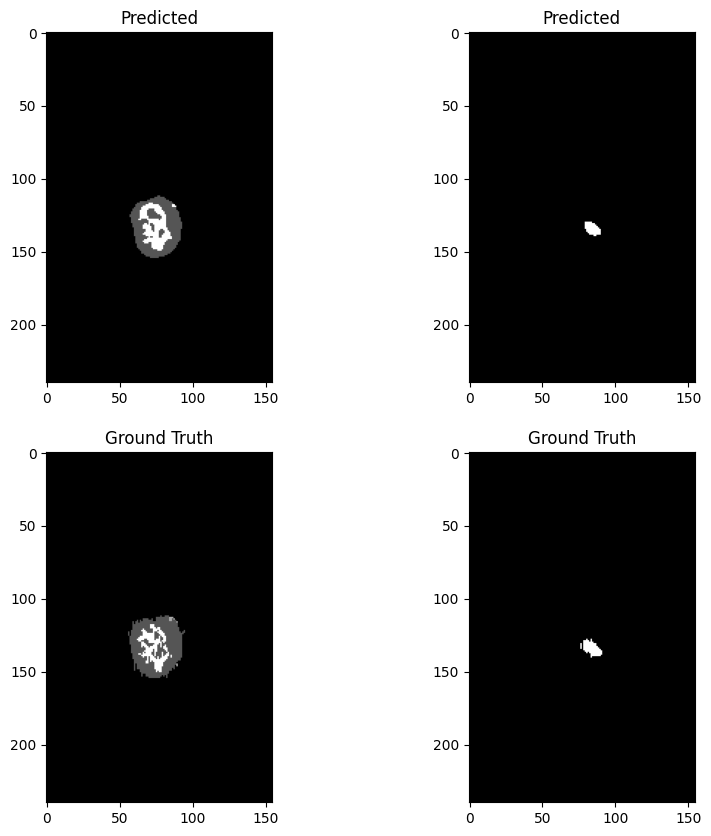

100%|██████████| 189/189 [25:02<00:00,  7.95s/it]



Average Training Loss: 0.014922983441797514

Average Training DSC: [0.99821697 0.84069485 0.89722231 0.67494282]
Average Training ASSD: [ 0.18738464 21.35273687 18.60212761 31.10158577]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


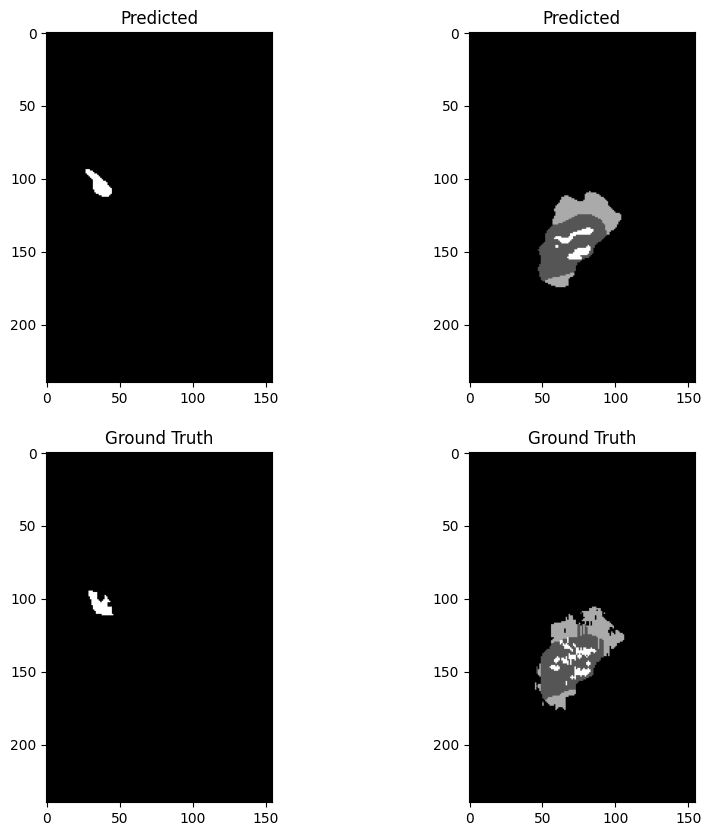

100%|██████████| 48/48 [06:27<00:00,  8.07s/it]


Average Validation Loss: 0.018337507635199774

Average Validation DSC: [0.9979212  0.809799   0.87594151 0.66289122]
Average Validation ASSD: [ 0.20355931 30.25664264 24.42437614 19.52033747]
Epoch 31/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


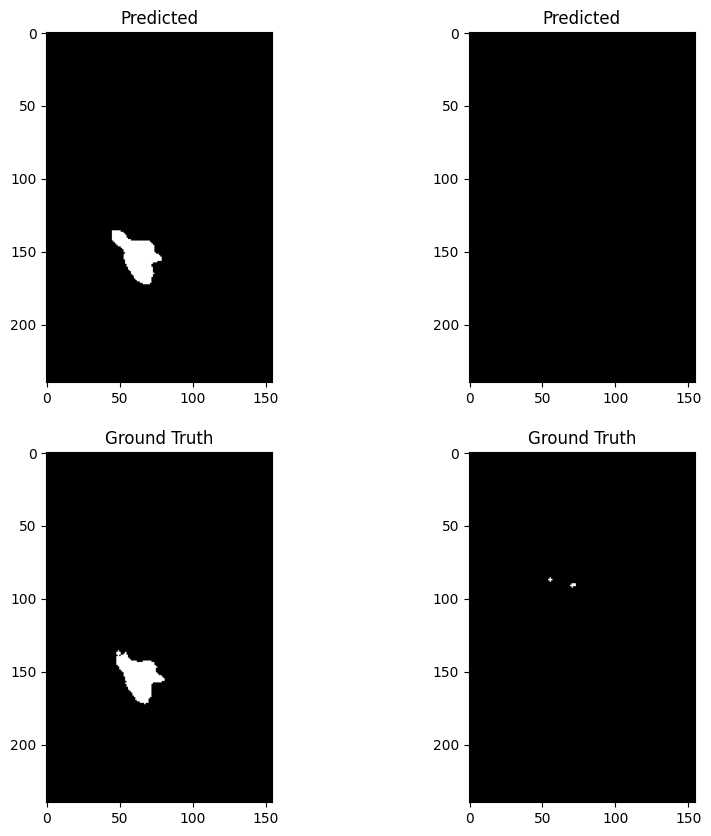

100%|██████████| 189/189 [25:07<00:00,  7.97s/it]



Average Training Loss: 0.014207221153709624

Average Training DSC: [0.99828727 0.85154671 0.89977859 0.68447192]
Average Training ASSD: [ 0.18582099 19.44575609 18.06089145 31.83225047]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


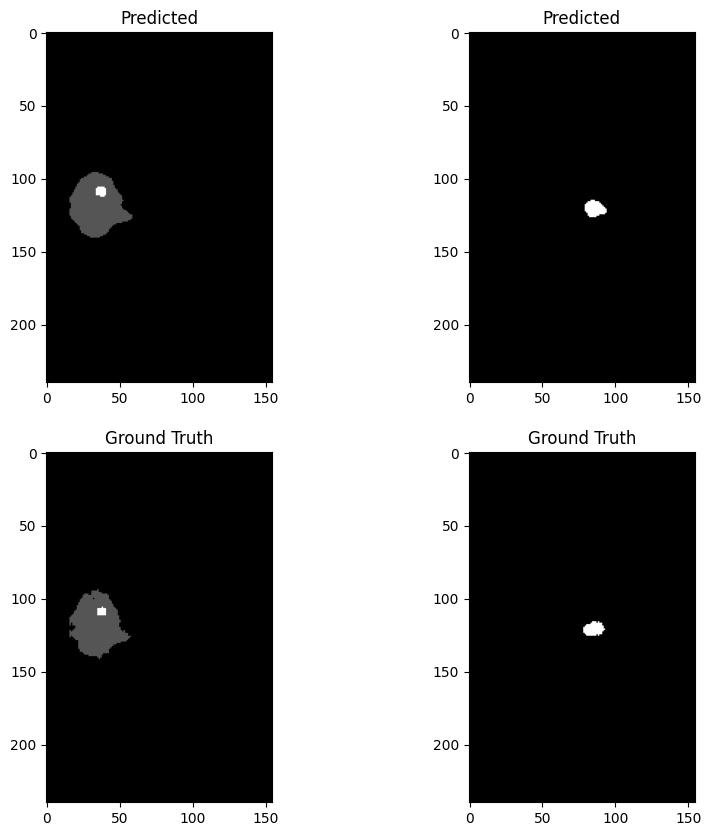

100%|██████████| 48/48 [05:51<00:00,  7.33s/it]


Average Validation Loss: 0.01701418001903221

Average Validation DSC: [0.99810277 0.81024072 0.88274479 0.67080025]
Average Validation ASSD: [ 0.18281448 30.8506061  21.49593945 28.83293098]
Epoch 32/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


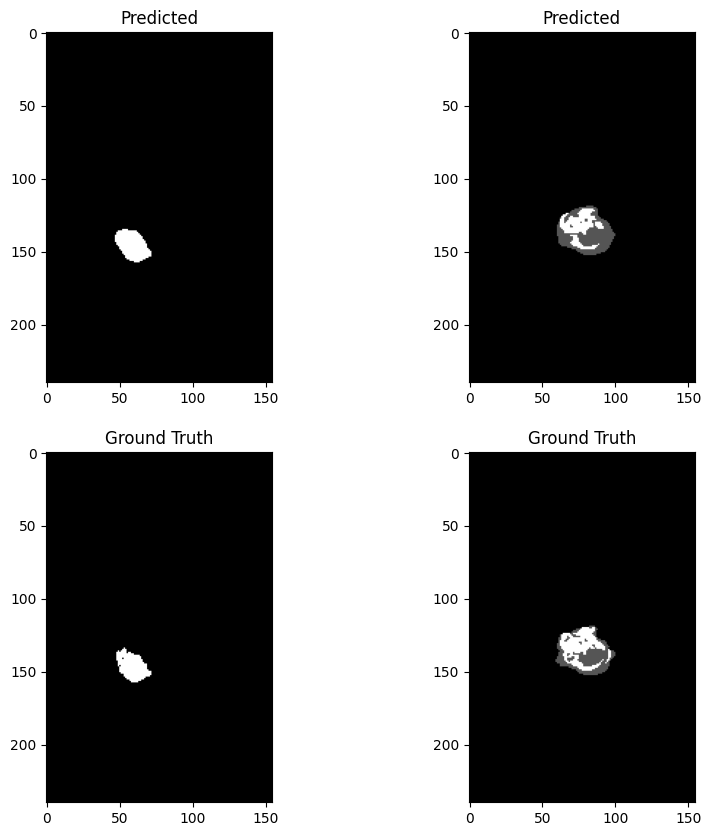

100%|██████████| 189/189 [24:51<00:00,  7.89s/it]



Average Training Loss: 0.013312141864348656

Average Training DSC: [0.9983585  0.86098747 0.90789288 0.6939107 ]
Average Training ASSD: [ 0.17290873 16.91565957 15.95982118 31.31537559]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


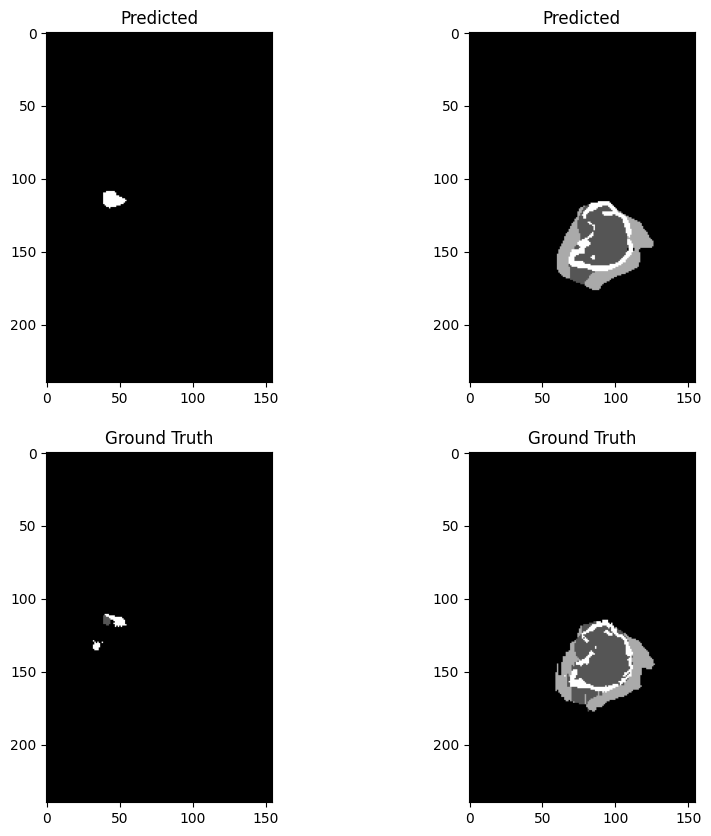

100%|██████████| 48/48 [06:09<00:00,  7.69s/it]


Average Validation Loss: 0.016683063954891015

Average Validation DSC: [0.9981312  0.74926122 0.87015359 0.66603448]
Average Validation ASSD: [ 0.19007324 53.86895787 25.77470796 29.02829959]
Epoch 33/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


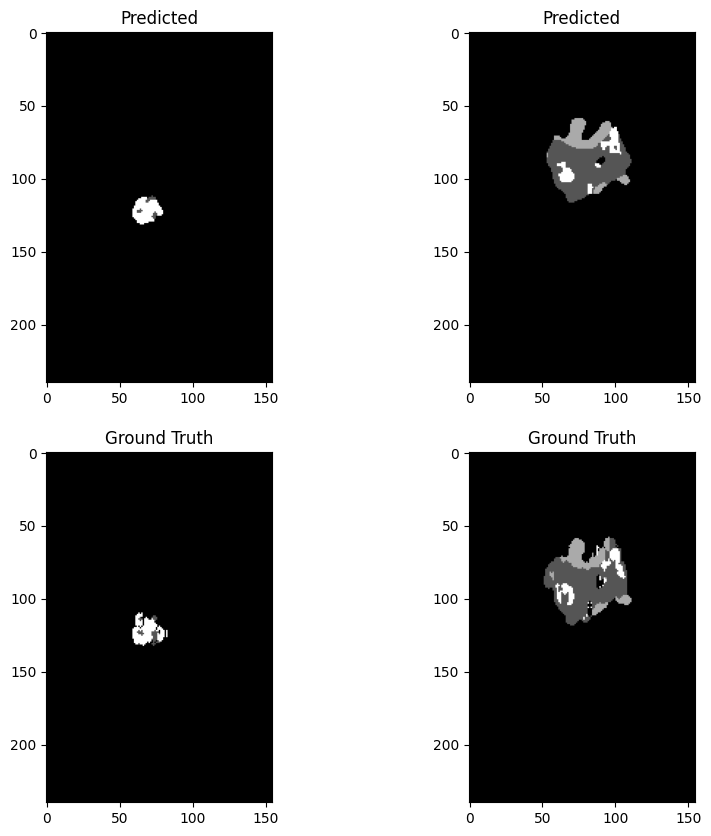

100%|██████████| 189/189 [24:33<00:00,  7.80s/it]



Average Training Loss: 0.012573177014630307

Average Training DSC: [0.99845229 0.87049372 0.90863485 0.70027684]
Average Training ASSD: [ 0.16203047 15.31417596 15.76866893 31.38741819]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


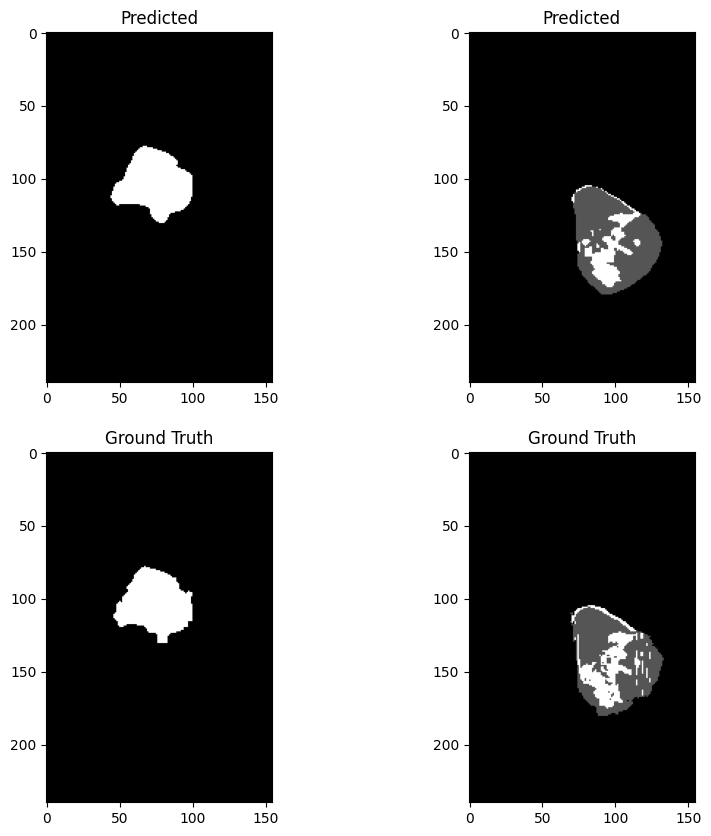

100%|██████████| 48/48 [06:06<00:00,  7.63s/it]


Average Validation Loss: 0.015350019539861629

Average Validation DSC: [0.99834368 0.84109409 0.88878913 0.69248398]
Average Validation ASSD: [ 0.163142   23.53386577 20.32437154 30.90333468]
Epoch 34/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


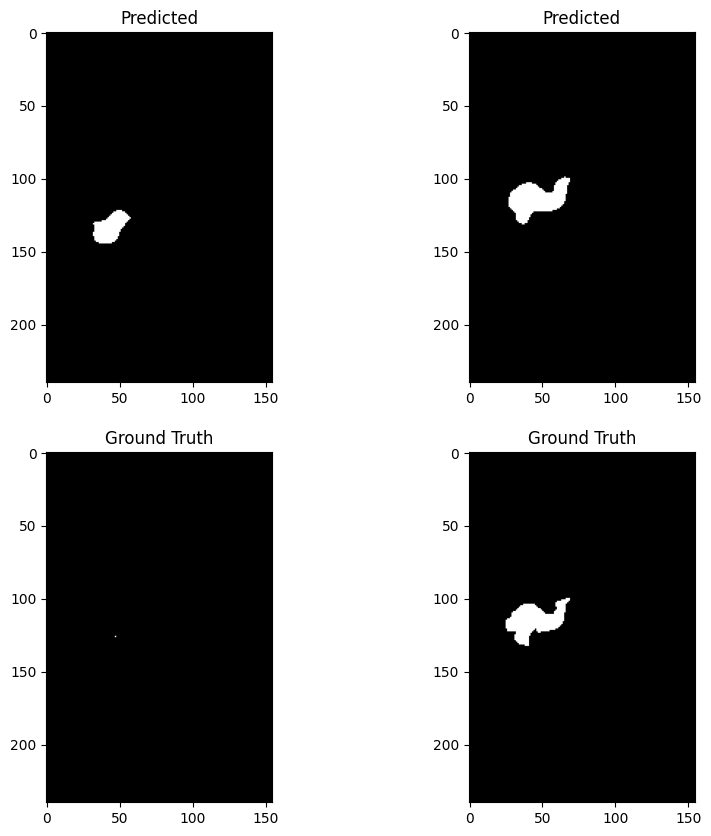

100%|██████████| 189/189 [24:26<00:00,  7.76s/it]



Average Training Loss: 0.012377193054706647

Average Training DSC: [0.99848032 0.87423594 0.90828191 0.70458864]
Average Training ASSD: [ 0.15968887 14.28980158 15.09343202 32.07629956]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


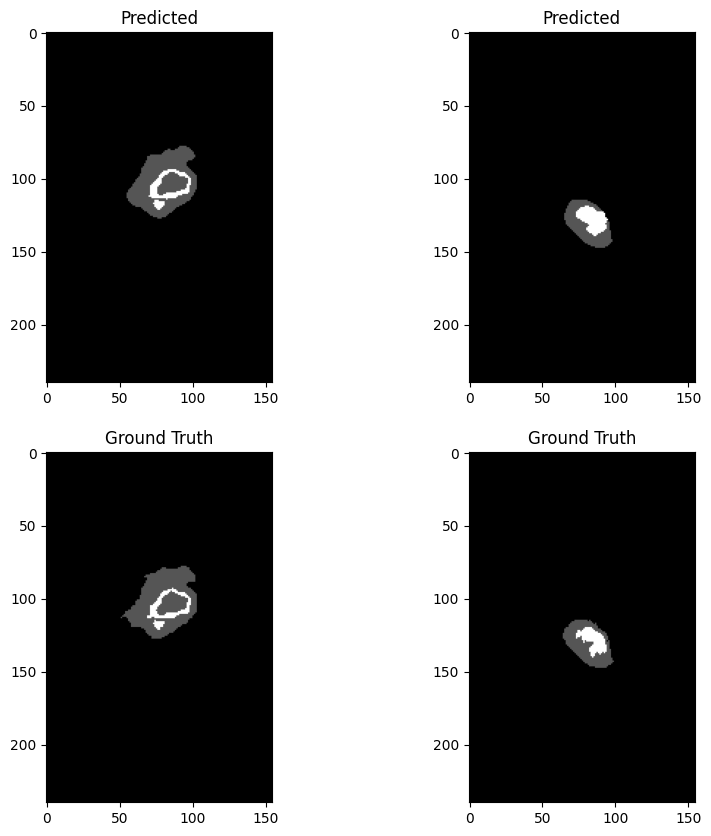

100%|██████████| 48/48 [06:09<00:00,  7.69s/it]


Average Validation Loss: 0.014607238447448859

Average Validation DSC: [0.99843923 0.85187811 0.8963375  0.70783319]
Average Validation ASSD: [ 0.15661382 21.82891928 18.12616289 32.38184514]
Epoch 35/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


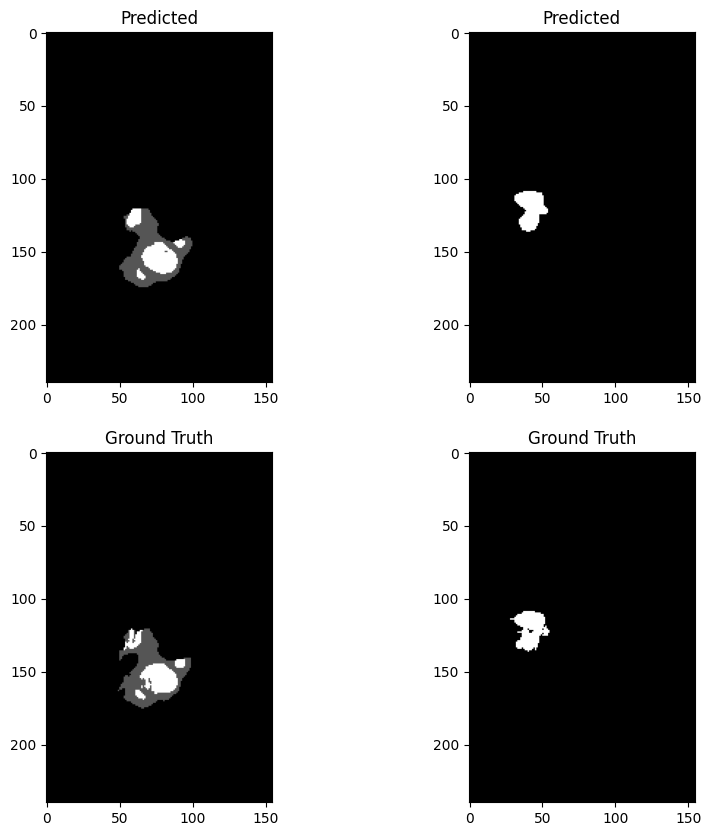

100%|██████████| 189/189 [23:56<00:00,  7.60s/it]



Average Training Loss: 0.011920877646102949

Average Training DSC: [0.99852215 0.87939288 0.91417703 0.71270176]
Average Training ASSD: [ 0.15378324 13.96147934 13.90050633 29.00377316]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


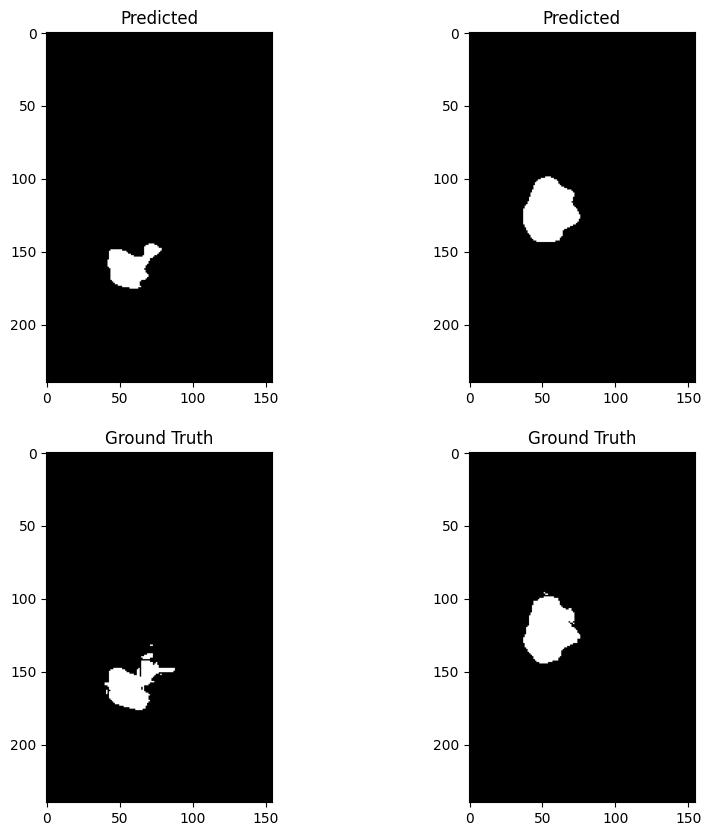

100%|██████████| 48/48 [06:02<00:00,  7.56s/it]


Average Validation Loss: 0.015572911594063044

Average Validation DSC: [0.99837192 0.8415761  0.89569917 0.69892169]
Average Validation ASSD: [ 0.1644301  24.91420176 18.13877338 29.91820894]
Epoch 36/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


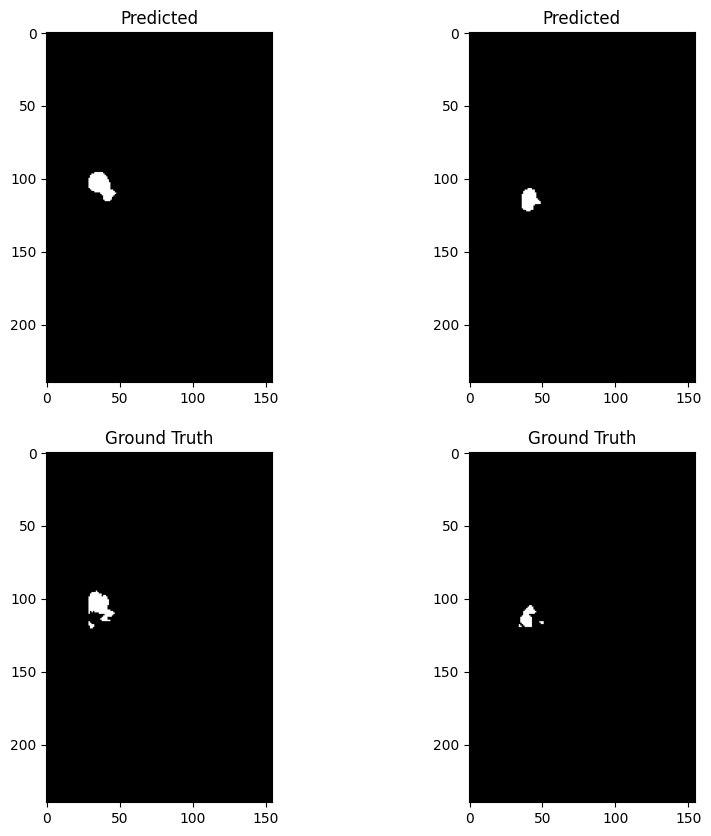

100%|██████████| 189/189 [25:07<00:00,  7.98s/it]



Average Training Loss: 0.011925412307458895

Average Training DSC: [0.99854663 0.87280814 0.91298731 0.71347905]
Average Training ASSD: [ 0.1535885  15.94623396 14.15507127 30.11474394]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


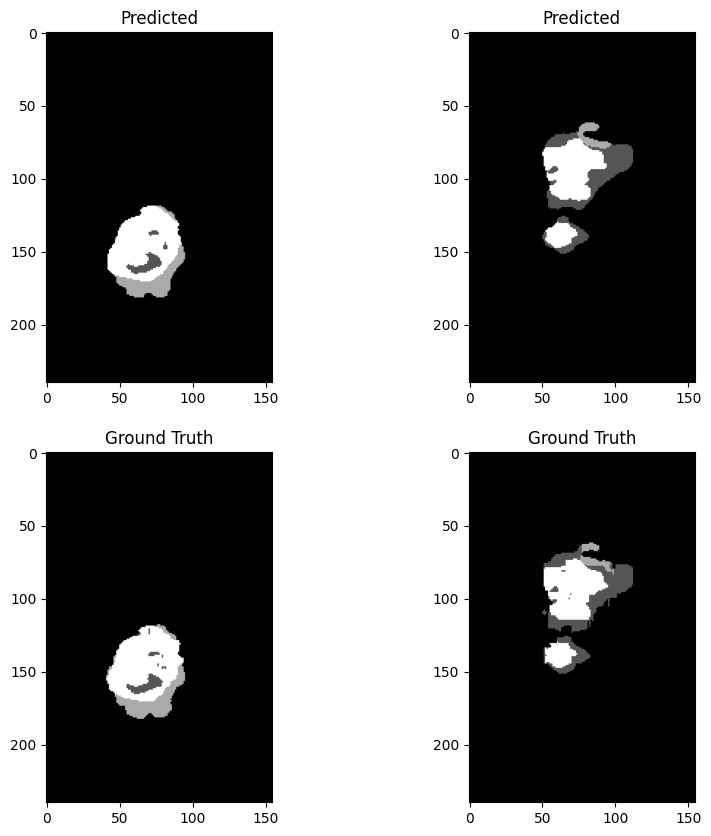

100%|██████████| 48/48 [06:24<00:00,  8.00s/it]


Average Validation Loss: 0.014701560353084156

Average Validation DSC: [0.99837795 0.8541004  0.89088564 0.70574746]
Average Validation ASSD: [ 0.16183074 22.03015539 20.22721404 26.70198346]
Epoch 37/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


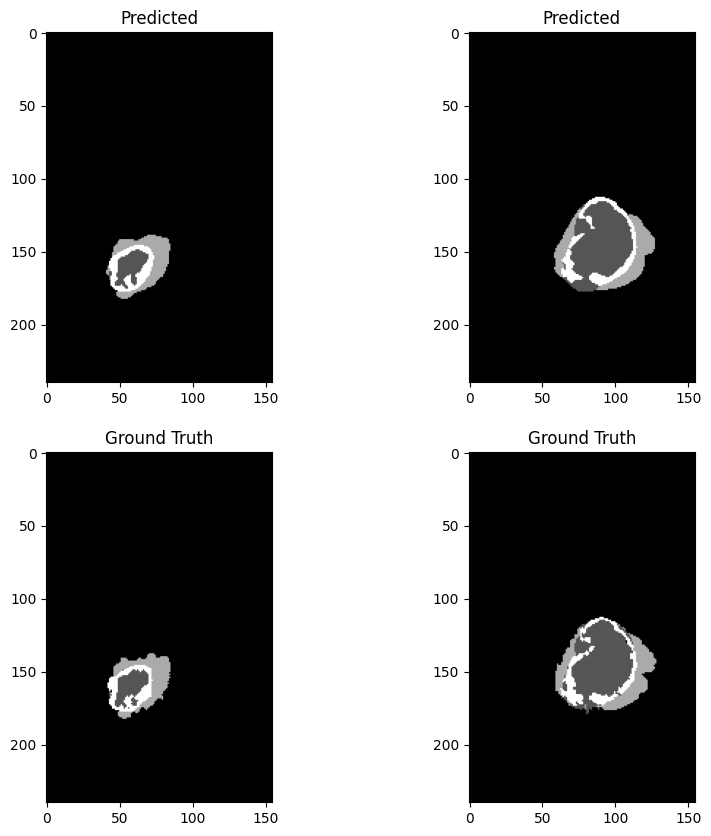

100%|██████████| 189/189 [24:53<00:00,  7.90s/it]



Average Training Loss: 0.012149377292386753

Average Training DSC: [0.99855802 0.87057454 0.90797729 0.70987707]
Average Training ASSD: [ 0.14827329 16.31534547 16.24852315 31.39125319]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


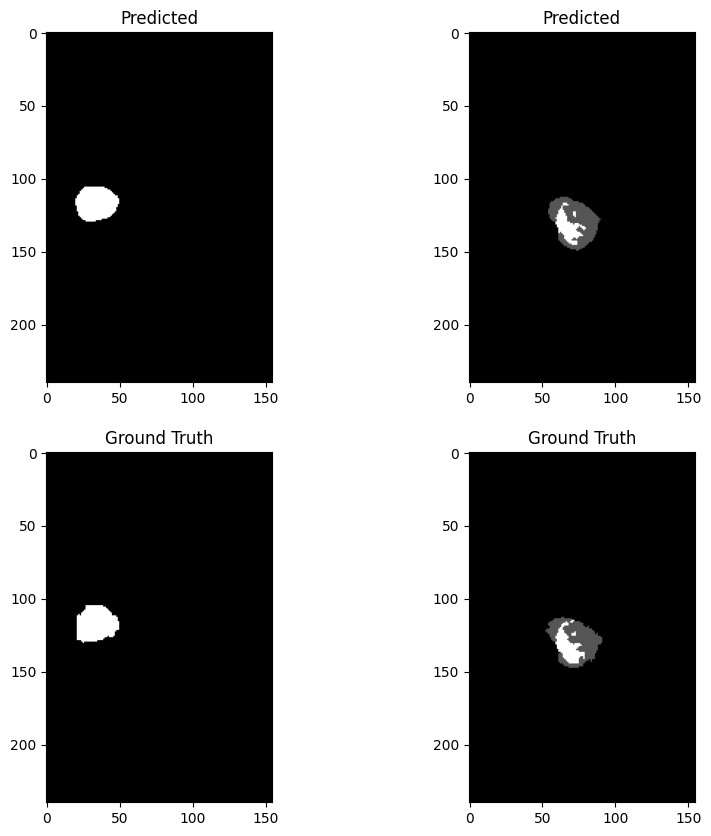

100%|██████████| 48/48 [06:08<00:00,  7.67s/it]


Average Validation Loss: 0.015483678221547356

Average Validation DSC: [0.99827633 0.83717947 0.89297545 0.70685412]
Average Validation ASSD: [ 0.17651959 29.46046029 17.50786169 25.68090234]
Epoch 38/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


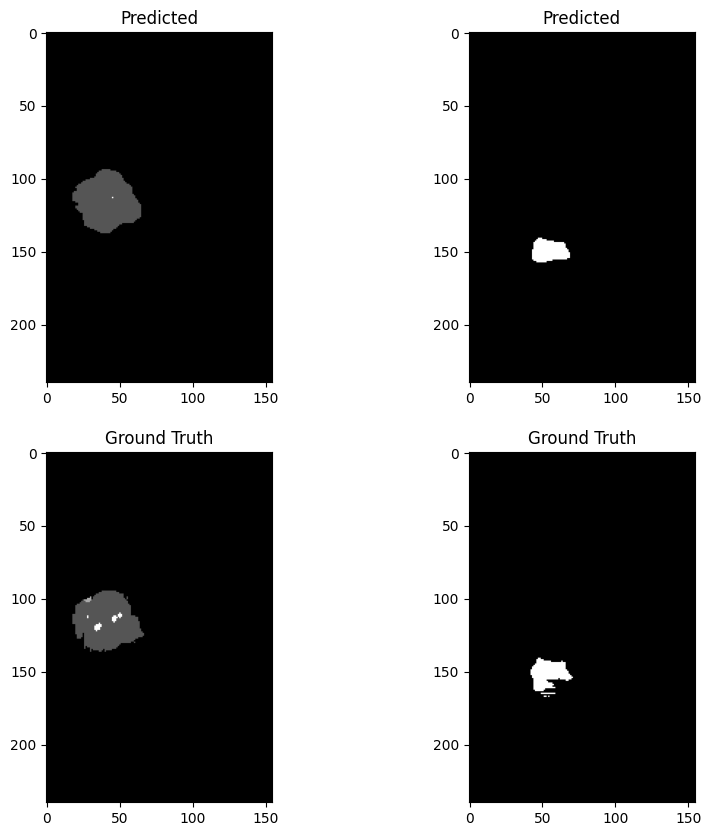

100%|██████████| 189/189 [24:22<00:00,  7.74s/it]



Average Training Loss: 0.012252341399077701

Average Training DSC: [0.99853156 0.87213513 0.91078442 0.71287312]
Average Training ASSD: [ 0.14989314 15.71413253 14.94359868 28.98426169]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


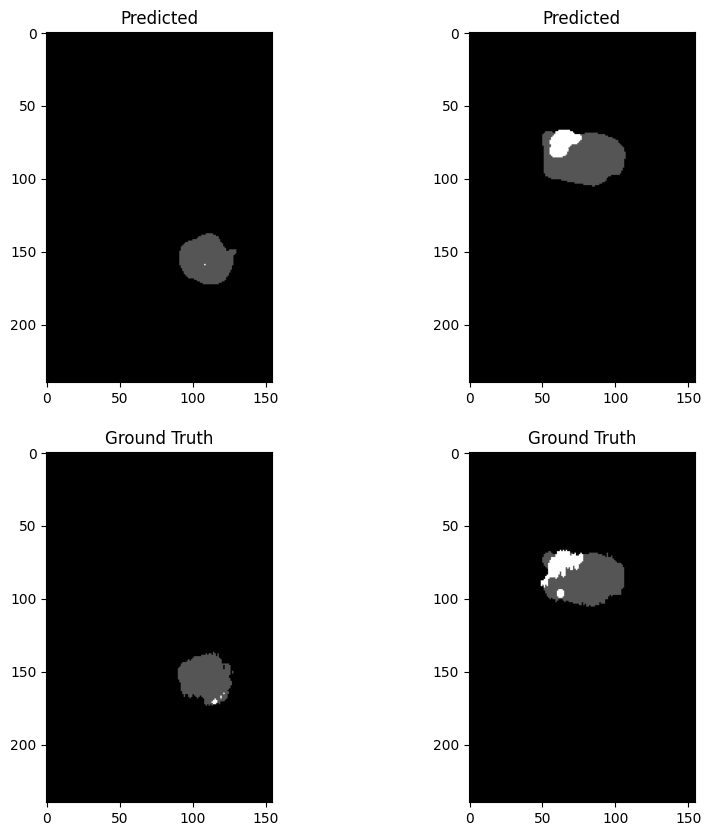

100%|██████████| 48/48 [06:05<00:00,  7.62s/it]


Average Validation Loss: 0.016522184150138248

Average Validation DSC: [0.99819874 0.81680569 0.88723525 0.70378136]
Average Validation ASSD: [ 0.18021362 30.9607841  21.48848797 18.3454526 ]
Epoch 39/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


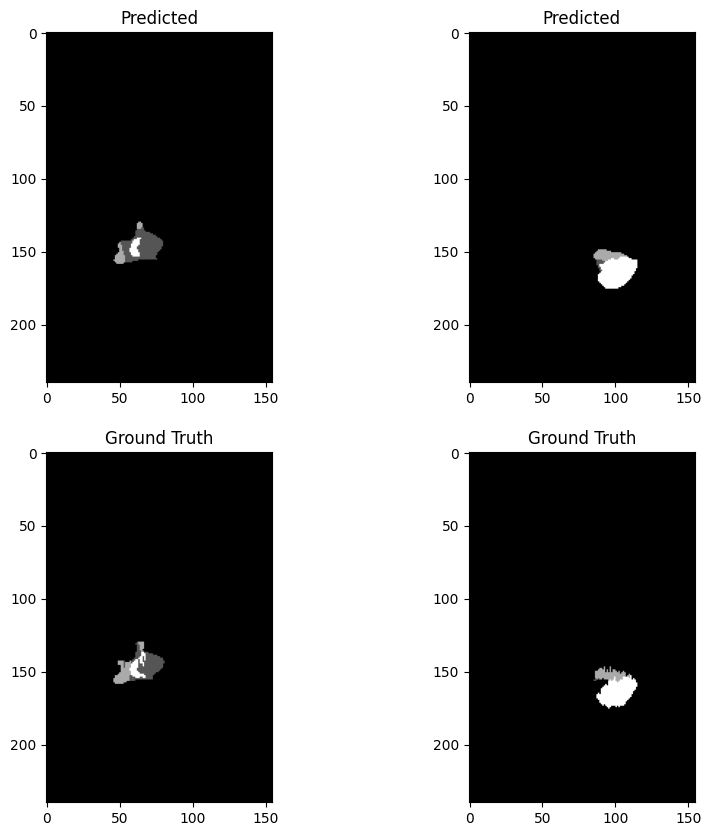

100%|██████████| 189/189 [25:26<00:00,  8.08s/it]



Average Training Loss: 0.011570475697418842

Average Training DSC: [0.99855551 0.88329465 0.91332491 0.72198037]
Average Training ASSD: [ 0.15243    13.47106347 14.66450549 28.04789924]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


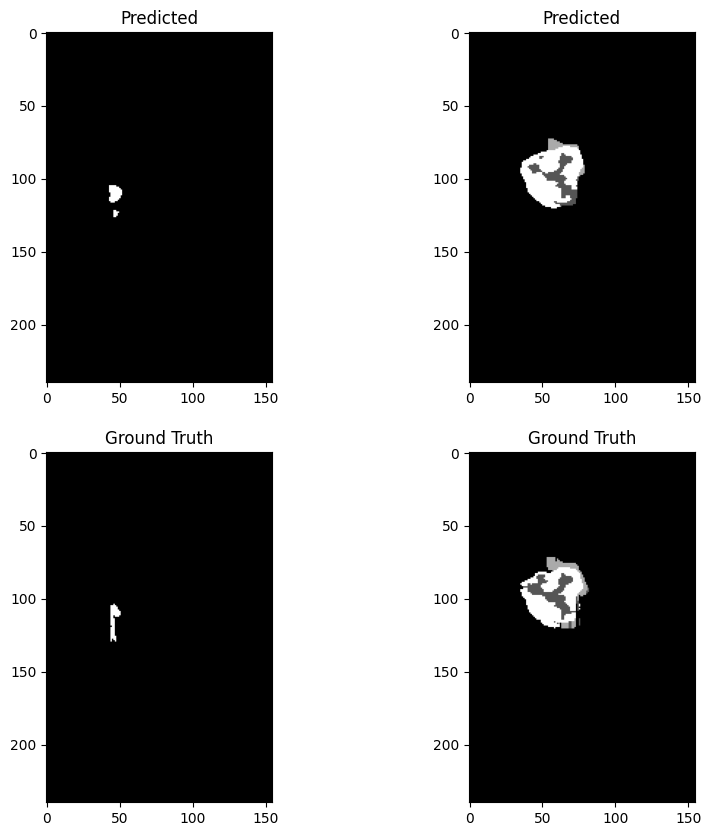

100%|██████████| 48/48 [06:21<00:00,  7.94s/it]


Average Validation Loss: 0.014595334709156305

Average Validation DSC: [0.99845295 0.86487956 0.90138095 0.71611464]
Average Validation ASSD: [ 0.14633247 18.99043685 15.9954382  24.05224563]
Epoch 40/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


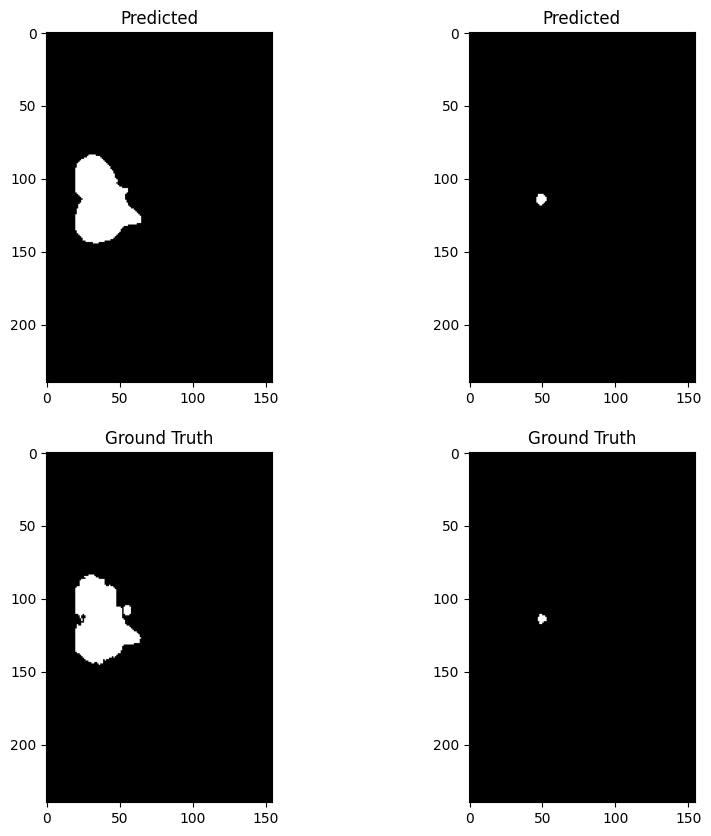

100%|██████████| 189/189 [25:46<00:00,  8.18s/it]



Average Training Loss: 0.010756403717788913

Average Training DSC: [0.99870424 0.88928076 0.9187103  0.72980432]
Average Training ASSD: [ 0.1346695  12.60398479 13.31090181 29.71945379]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


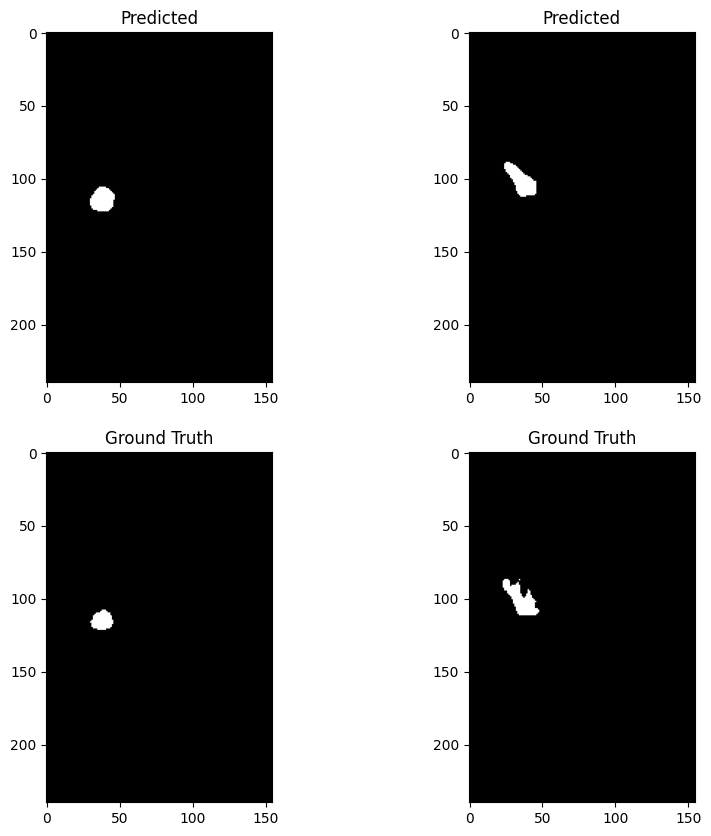

100%|██████████| 48/48 [06:07<00:00,  7.65s/it]


Average Validation Loss: 0.012905725627206266

Average Validation DSC: [0.99859823 0.86573668 0.91397766 0.72949023]
Average Validation ASSD: [ 0.1420169  19.86089599 14.03029949 28.94882361]
Epoch 41/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


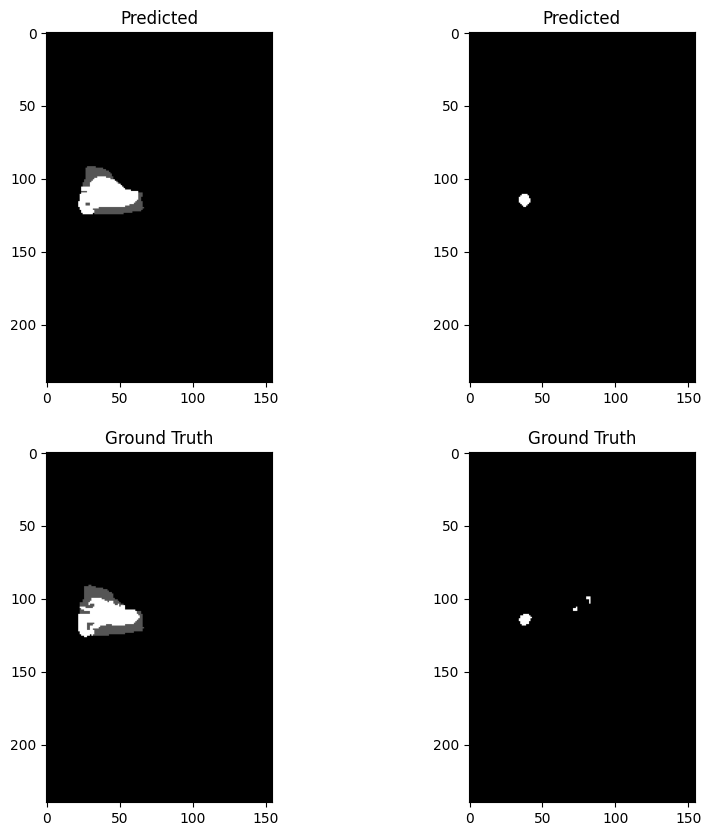

100%|██████████| 189/189 [26:00<00:00,  8.26s/it]



Average Training Loss: 0.010128323355857184

Average Training DSC: [0.99876729 0.89547718 0.92426554 0.73885134]
Average Training ASSD: [ 0.12549454 10.72584668 11.74280935 29.40110377]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


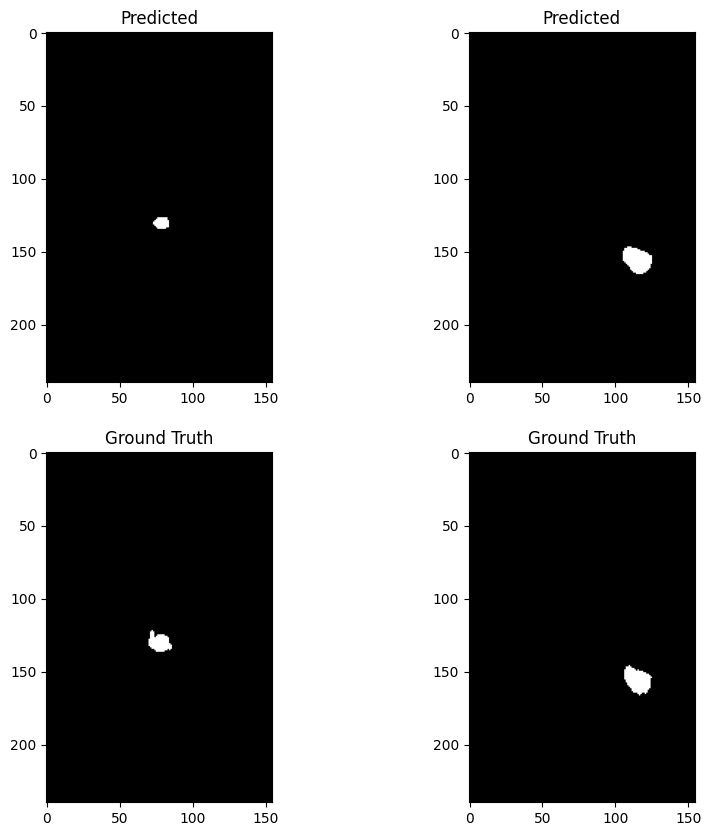

100%|██████████| 48/48 [06:06<00:00,  7.64s/it]


Average Validation Loss: 0.013628054031869397

Average Validation DSC: [0.99858776 0.85687251 0.9029742  0.72263077]
Average Validation ASSD: [ 0.14900456 21.7947245  15.93850078 29.83298044]
Epoch 42/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


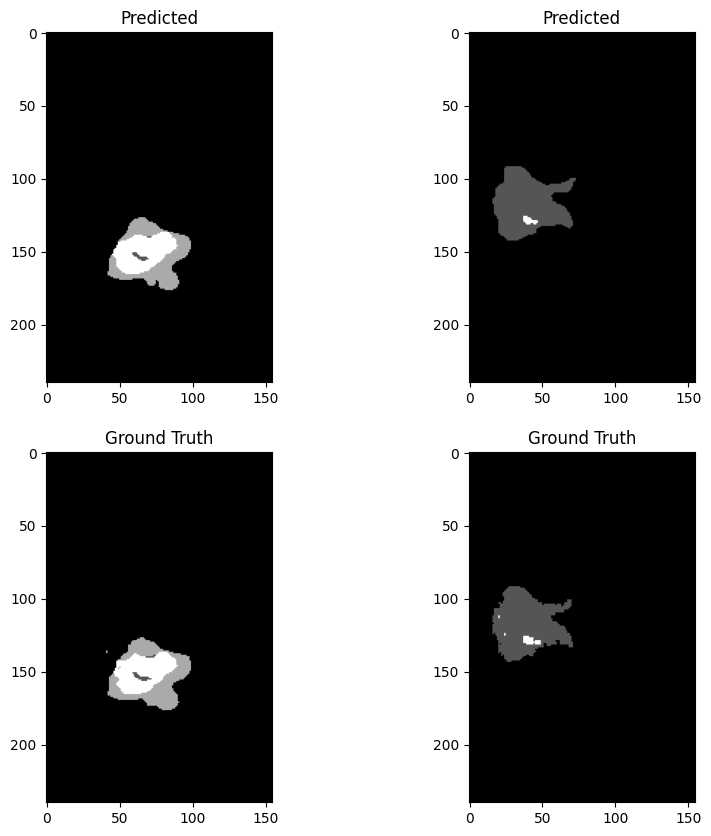

100%|██████████| 189/189 [25:09<00:00,  7.99s/it]



Average Training Loss: 0.009783436361917112

Average Training DSC: [0.99879585 0.90008067 0.92683154 0.74573587]
Average Training ASSD: [ 0.12260548 10.40361177 11.23057981 29.32196846]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


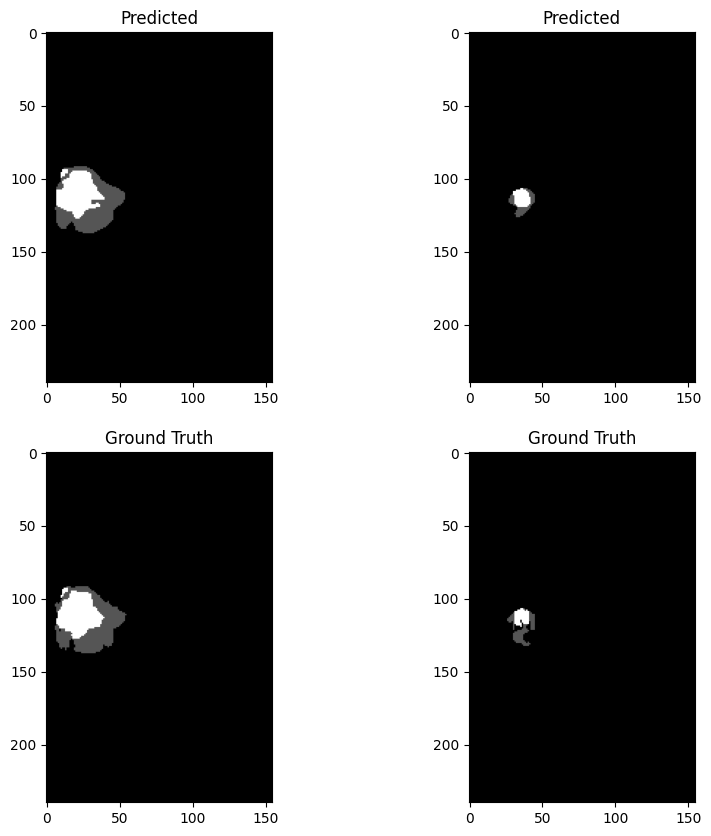

100%|██████████| 48/48 [06:07<00:00,  7.65s/it]


Average Validation Loss: 0.0140497311076615

Average Validation DSC: [0.99855432 0.841099   0.90136873 0.71469119]
Average Validation ASSD: [ 0.15037087 29.64629872 17.23171403 28.43940622]
Epoch 43/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


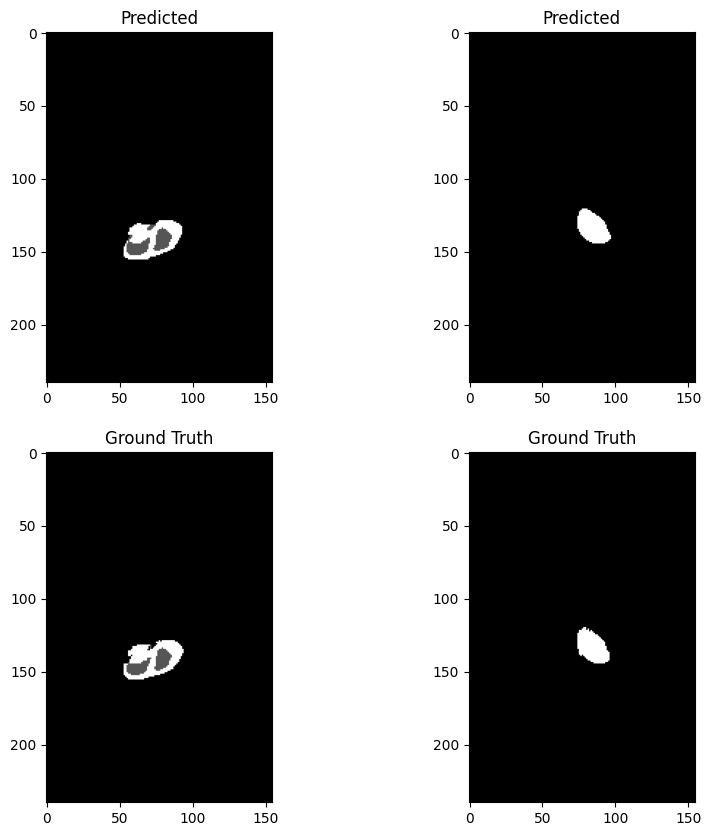

100%|██████████| 189/189 [23:51<00:00,  7.57s/it]



Average Training Loss: 0.009619560925457528

Average Training DSC: [0.99880815 0.90036868 0.92489483 0.74657243]
Average Training ASSD: [ 0.12153826 10.64311214 11.66648678 30.06267305]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


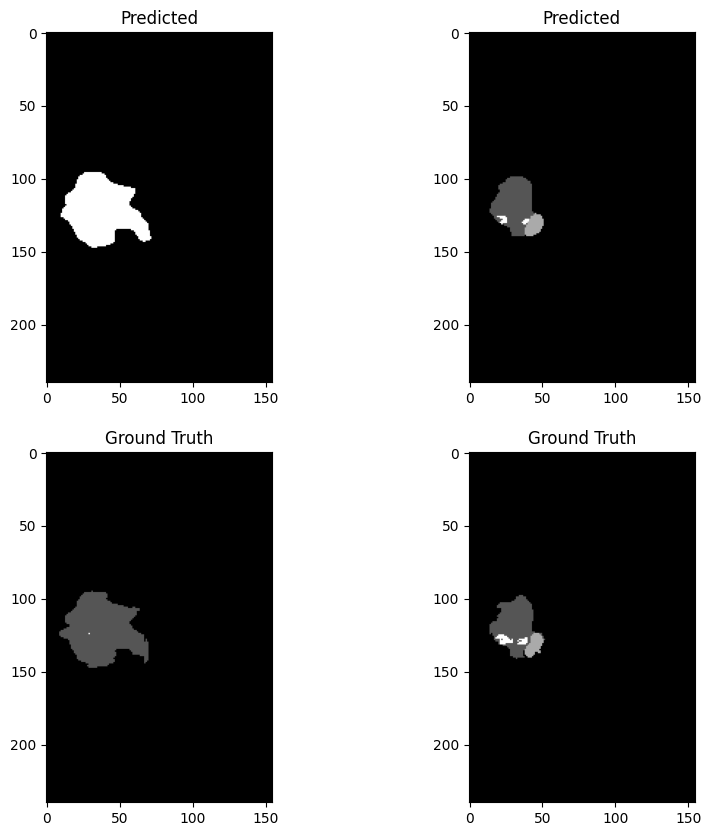

100%|██████████| 48/48 [06:00<00:00,  7.52s/it]


Average Validation Loss: 0.013131194515153766

Average Validation DSC: [0.9986684  0.87844177 0.91786722 0.73645156]
Average Validation ASSD: [ 0.13118334 17.45666116 12.60214473 27.72910722]
Epoch 44/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


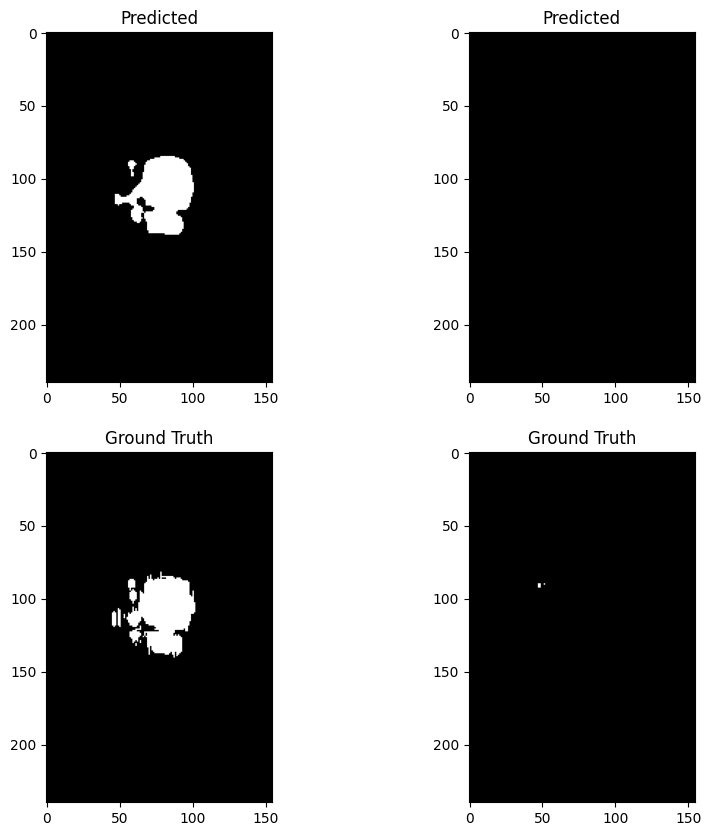

100%|██████████| 189/189 [24:54<00:00,  7.91s/it]



Average Training Loss: 0.0095609704466172

Average Training DSC: [0.99882147 0.90105669 0.92585846 0.7511987 ]
Average Training ASSD: [ 0.12091627 10.92138939 11.6123389  28.14634061]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


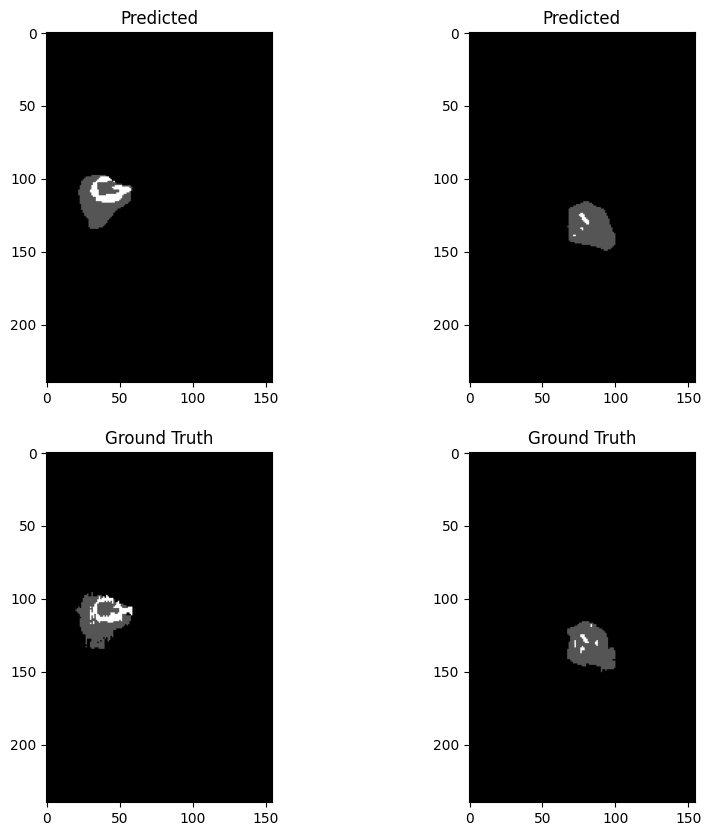

100%|██████████| 48/48 [06:26<00:00,  8.05s/it]


Average Validation Loss: 0.013451539271045476

Average Validation DSC: [0.99859081 0.83929357 0.90832855 0.73504025]
Average Validation ASSD: [ 0.13920833 29.49878211 15.28657855 28.15942877]
Epoch 45/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


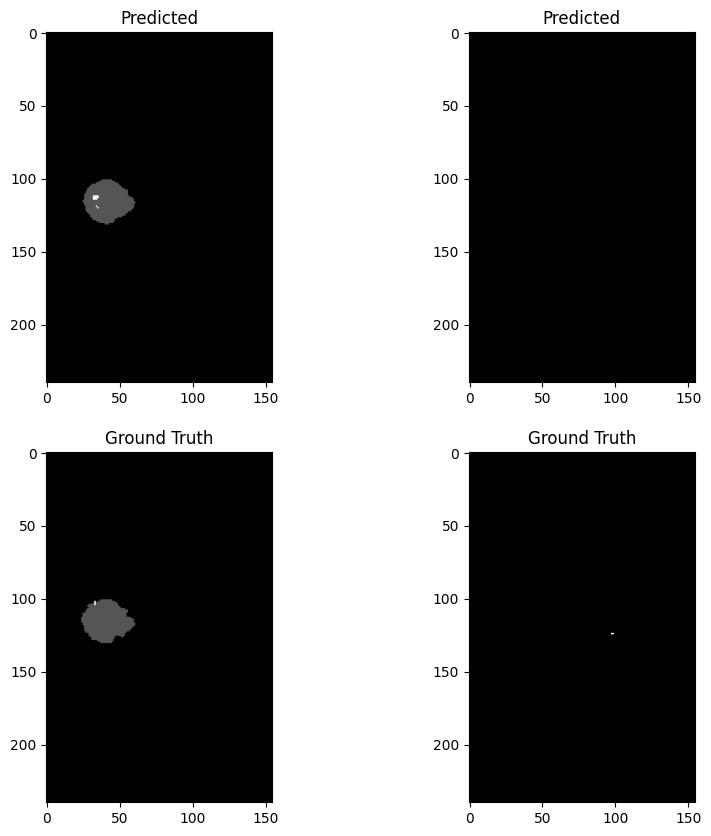

100%|██████████| 189/189 [26:26<00:00,  8.40s/it]



Average Training Loss: 0.010139991310006254

Average Training DSC: [0.99875654 0.89173019 0.92333419 0.74211958]
Average Training ASSD: [ 0.1307967  12.79842782 12.38792069 30.17416001]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


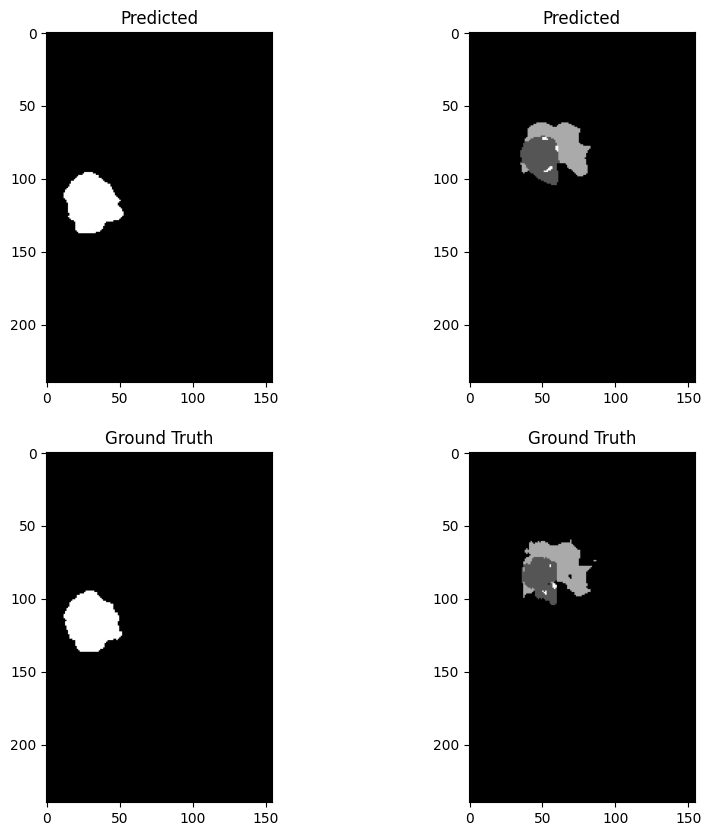

100%|██████████| 48/48 [06:07<00:00,  7.65s/it]


Average Validation Loss: 0.013477389982047802

Average Validation DSC: [0.99857882 0.87385728 0.90561965 0.7400709 ]
Average Validation ASSD: [ 0.14860335 16.30048093 16.31203512 28.10557285]
Epoch 46/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


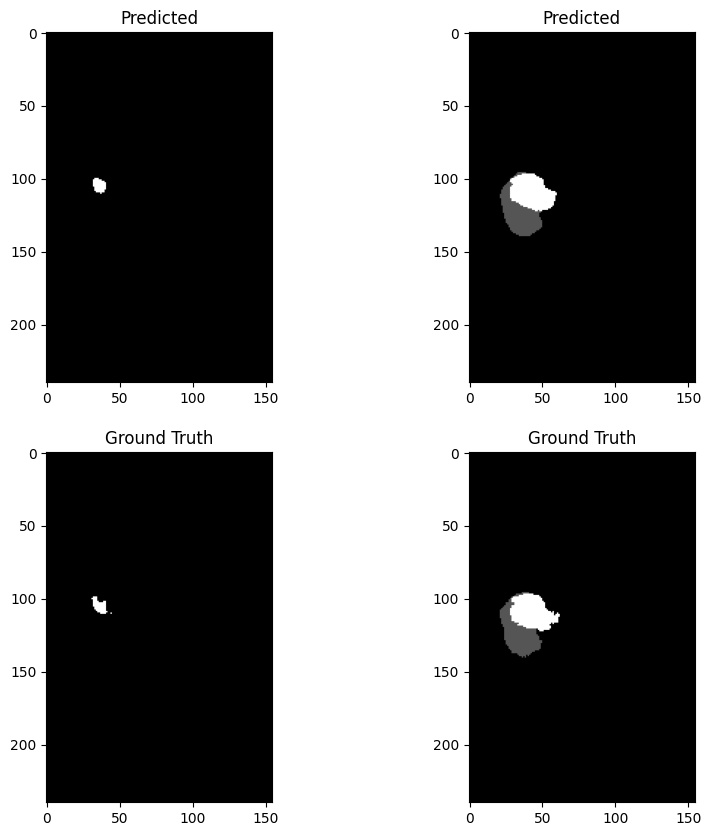

100%|██████████| 189/189 [25:17<00:00,  8.03s/it]



Average Training Loss: 0.008916414488185809

Average Training DSC: [0.99891566 0.90372442 0.92963351 0.76149098]
Average Training ASSD: [ 0.11127089 10.90394211 10.9181298  28.35282772]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


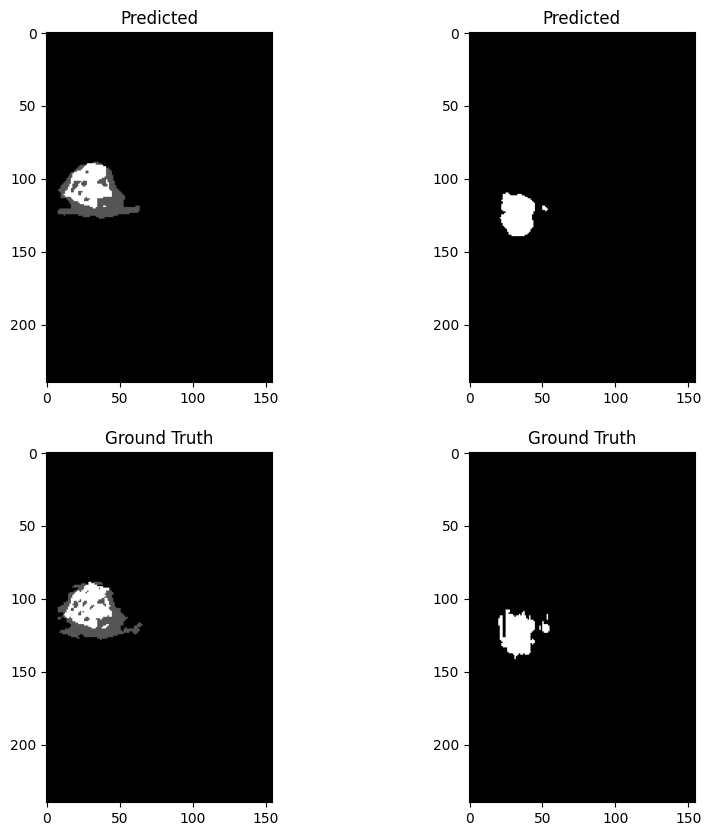

100%|██████████| 48/48 [05:42<00:00,  7.13s/it]


Average Validation Loss: 0.012234791744655618

Average Validation DSC: [0.99874495 0.86686932 0.91613108 0.74620031]
Average Validation ASSD: [ 0.11881616 21.44958797 14.43608449 24.93183948]
Epoch 47/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


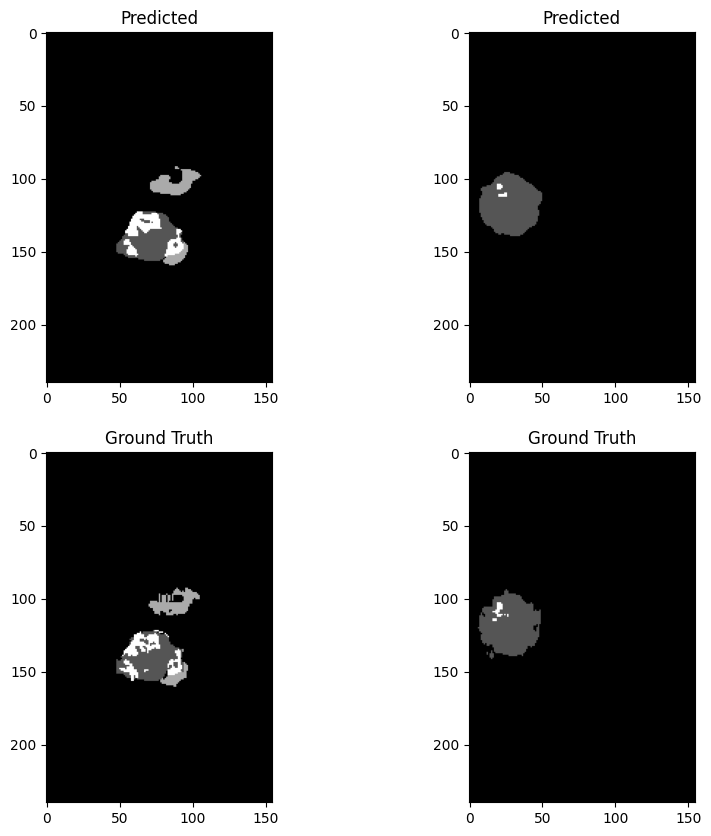

100%|██████████| 189/189 [25:09<00:00,  7.99s/it]



Average Training Loss: 0.00857878101142074

Average Training DSC: [0.99894562 0.91196812 0.93319771 0.76715228]
Average Training ASSD: [ 0.1049831   8.72640487 10.00404156 27.33592664]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


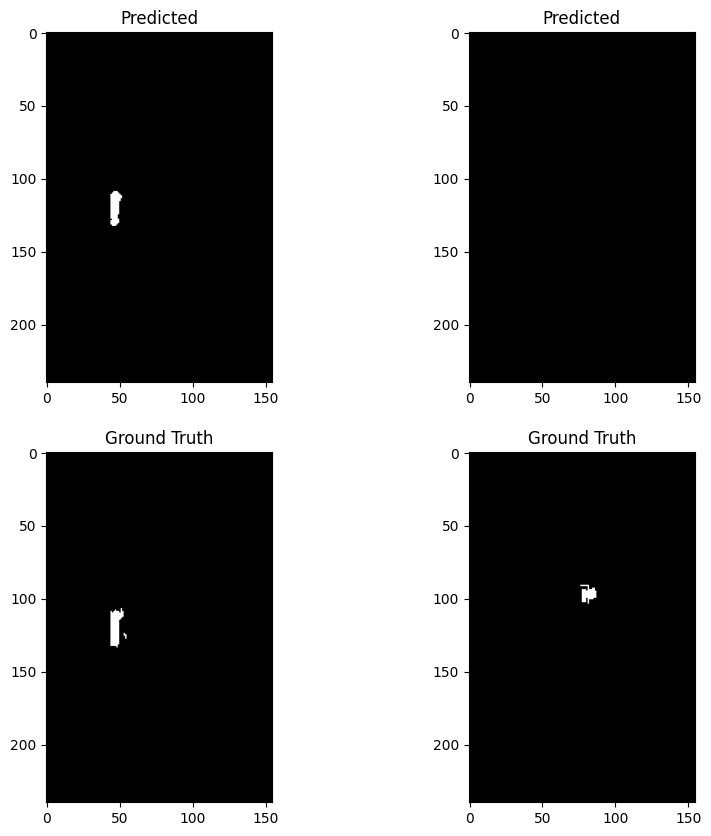

100%|██████████| 48/48 [06:04<00:00,  7.60s/it]


Average Validation Loss: 0.012714006918637702

Average Validation DSC: [0.99867219 0.88640988 0.91946948 0.7396027 ]
Average Validation ASSD: [ 0.13890663 14.85596921 12.11640846 28.55280765]
Epoch 48/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


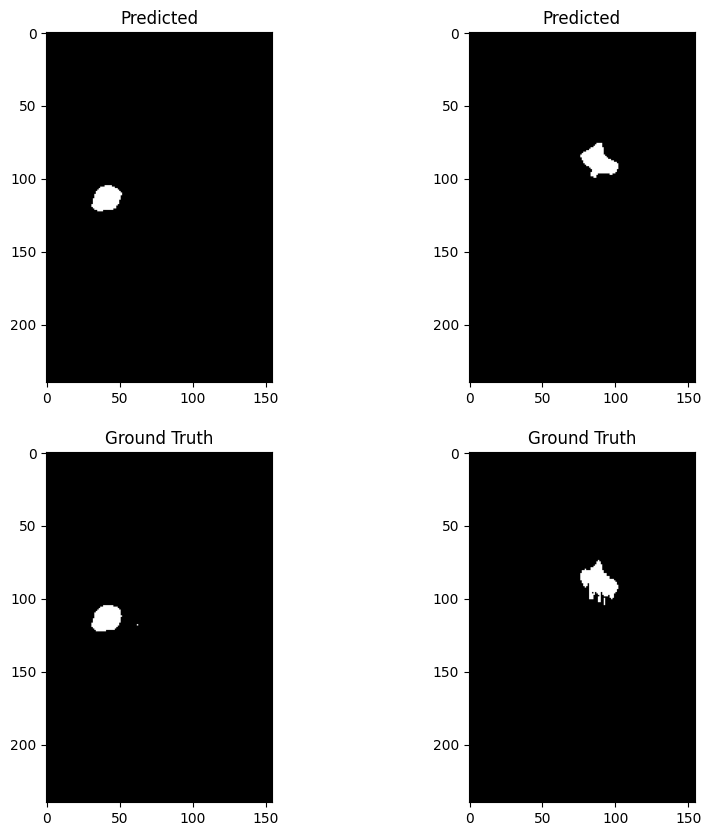

100%|██████████| 189/189 [25:04<00:00,  7.96s/it]



Average Training Loss: 0.009020183060475915

Average Training DSC: [0.99892324 0.90619859 0.93016939 0.76454539]
Average Training ASSD: [ 0.10786366 10.35264111 10.70398101 26.4010347 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


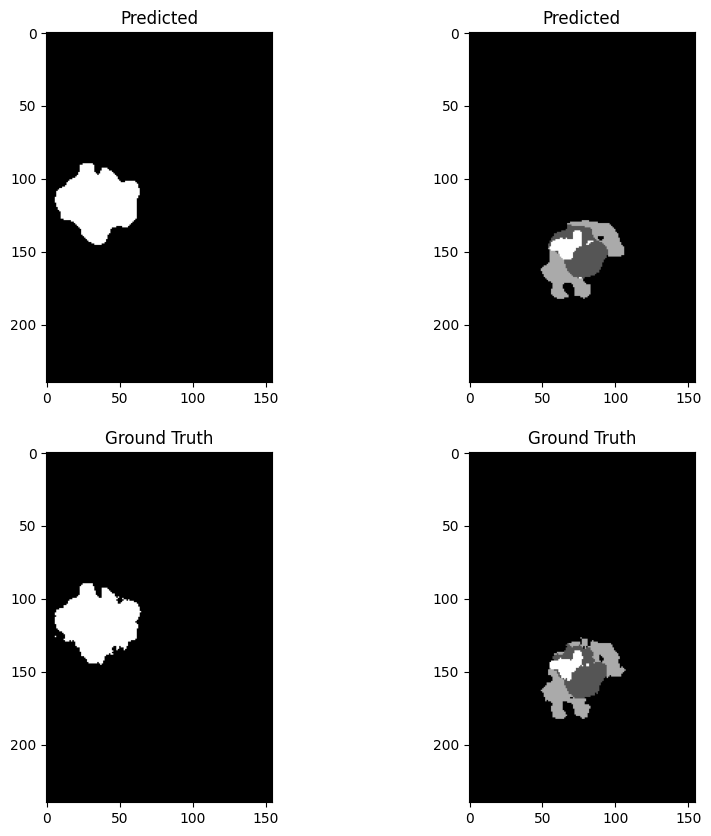

100%|██████████| 48/48 [06:01<00:00,  7.53s/it]


Average Validation Loss: 0.012246281704089293

Average Validation DSC: [0.99872199 0.87114917 0.91613402 0.73851202]
Average Validation ASSD: [ 0.12290534 21.11804489 14.19504276 29.61461199]
Epoch 49/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


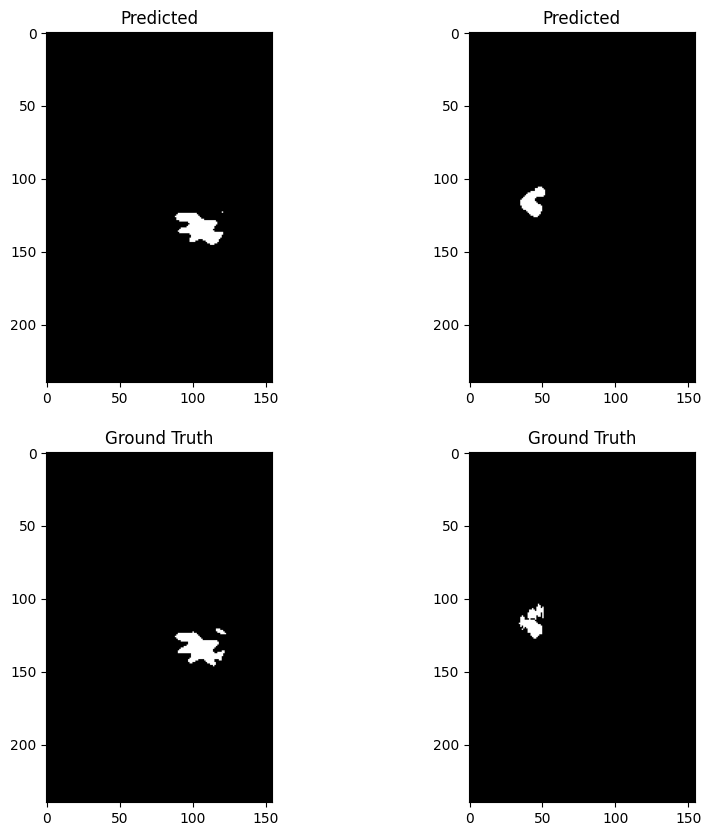

100%|██████████| 189/189 [24:53<00:00,  7.90s/it]



Average Training Loss: 0.007914779892575646

Average Training DSC: [0.99902119 0.92013713 0.93853041 0.77725405]
Average Training ASSD: [ 0.09870828  7.31681216  8.44692379 27.54257786]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


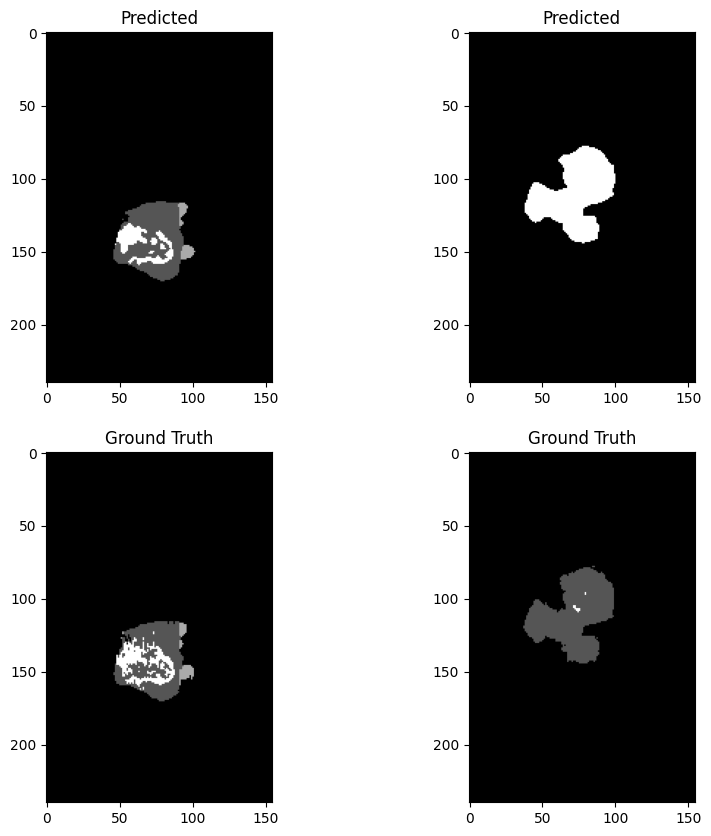

100%|██████████| 48/48 [06:23<00:00,  7.99s/it]


Average Validation Loss: 0.011749188444809988

Average Validation DSC: [0.99883144 0.88844463 0.9278779  0.73524714]
Average Validation ASSD: [ 0.11963884 15.5475734  11.11165329 32.53936858]
Epoch 50/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


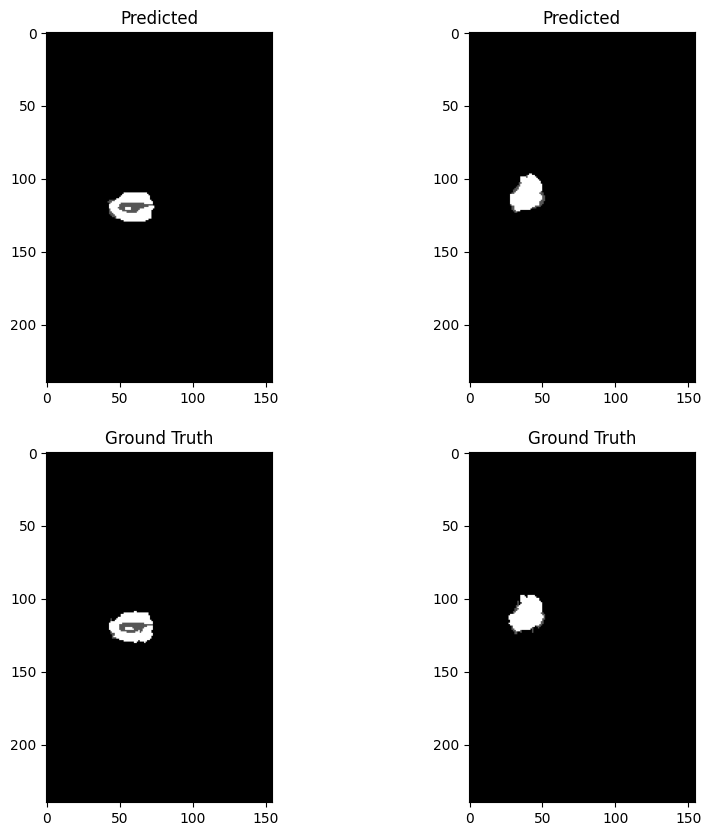

100%|██████████| 189/189 [25:10<00:00,  7.99s/it]



Average Training Loss: 0.008497694827537372

Average Training DSC: [0.99898563 0.91129328 0.93207216 0.77210983]
Average Training ASSD: [ 0.10136481  9.3211189  10.49114837 26.41651426]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


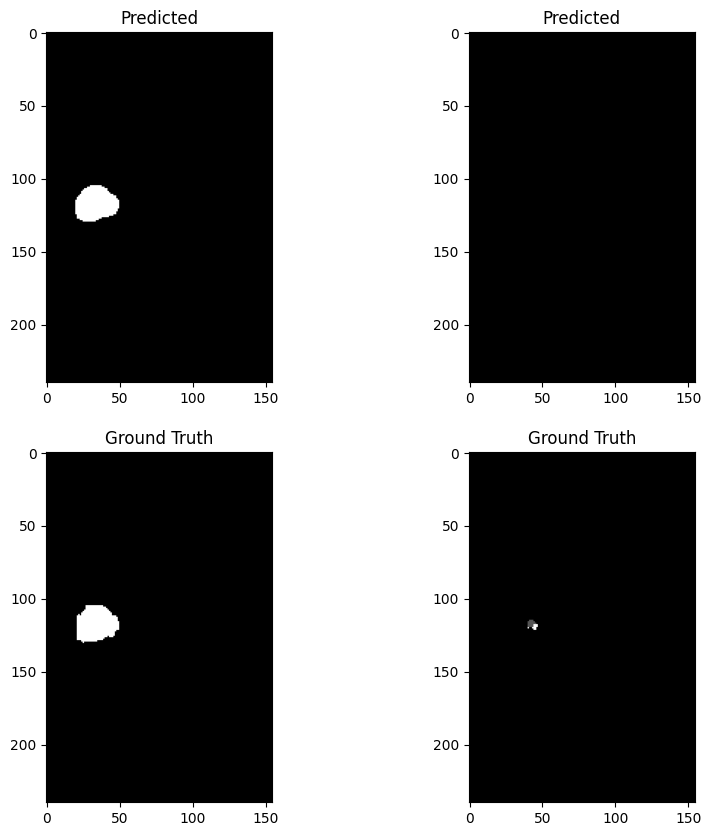

100%|██████████| 48/48 [06:01<00:00,  7.52s/it]


Average Validation Loss: 0.011753014153024802

Average Validation DSC: [0.99882431 0.88937749 0.92223275 0.75191082]
Average Validation ASSD: [ 0.11919397 15.74829888 13.13626381 27.79482184]
Epoch 51/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


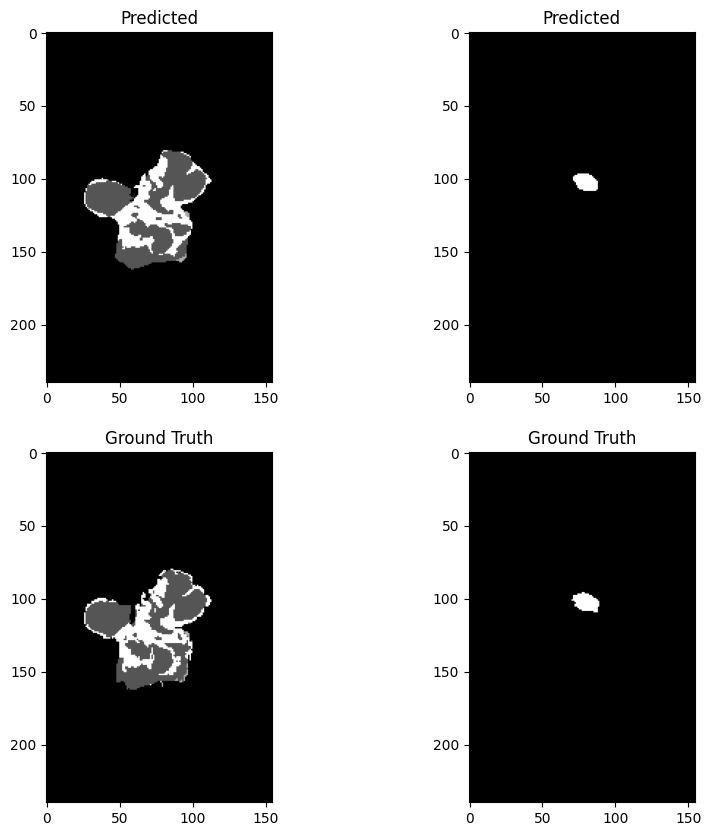

100%|██████████| 189/189 [25:30<00:00,  8.10s/it]



Average Training Loss: 0.008099207487055865

Average Training DSC: [0.99902951 0.91310777 0.93531756 0.77870795]
Average Training ASSD: [ 0.09672004  9.35833963  9.8767625  25.89456941]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


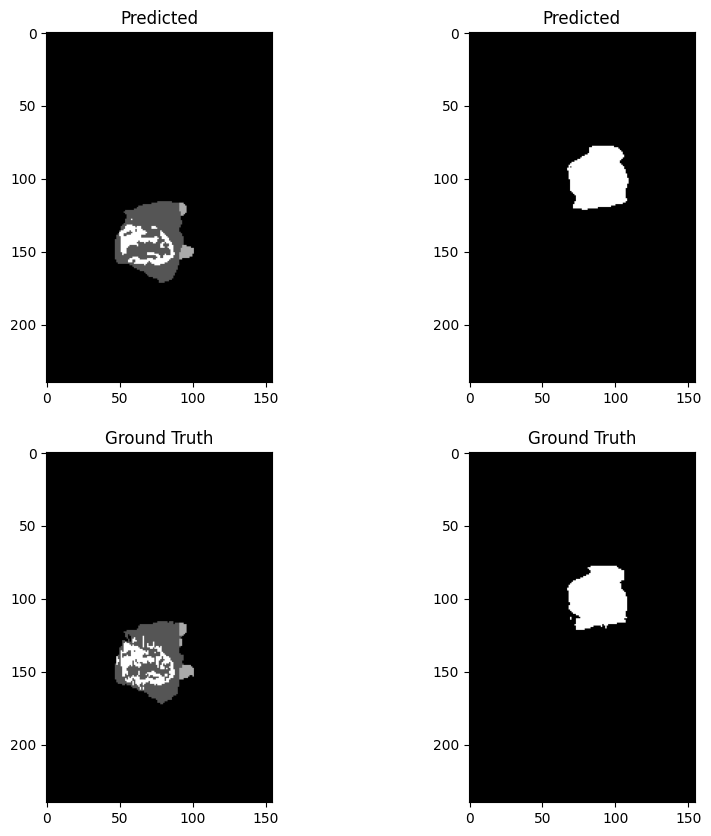

100%|██████████| 48/48 [05:57<00:00,  7.45s/it]


Average Validation Loss: 0.011969030446683368

Average Validation DSC: [0.99885413 0.87945195 0.91641075 0.75612121]
Average Validation ASSD: [ 0.1123366  18.98515712 14.43865853 25.91558514]
Epoch 52/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


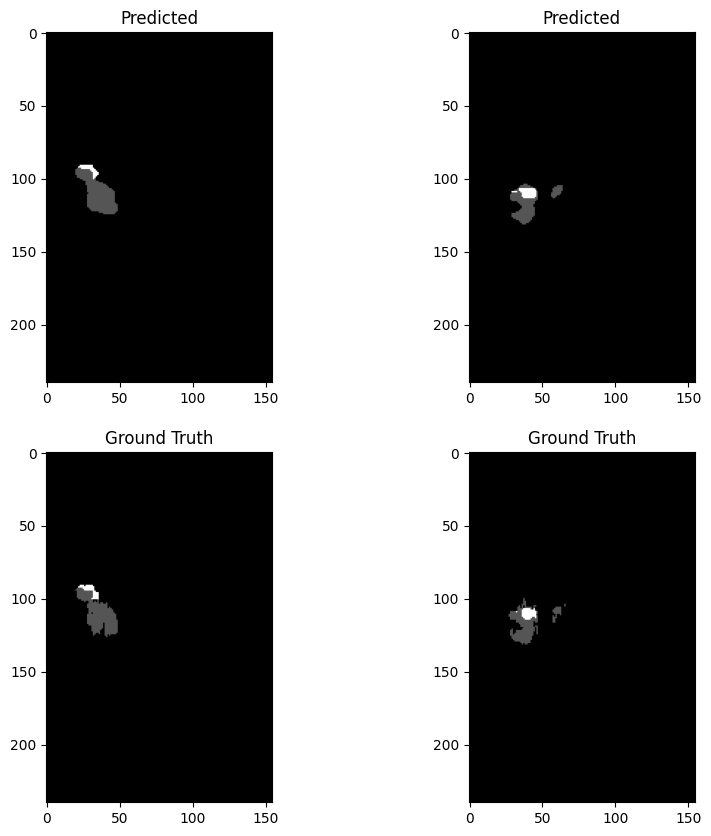

100%|██████████| 189/189 [24:25<00:00,  7.75s/it]



Average Training Loss: 0.008794221398790204

Average Training DSC: [0.99894998 0.90295428 0.92840256 0.77061692]
Average Training ASSD: [ 0.10609738 11.54217569 11.45678227 25.99719376]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


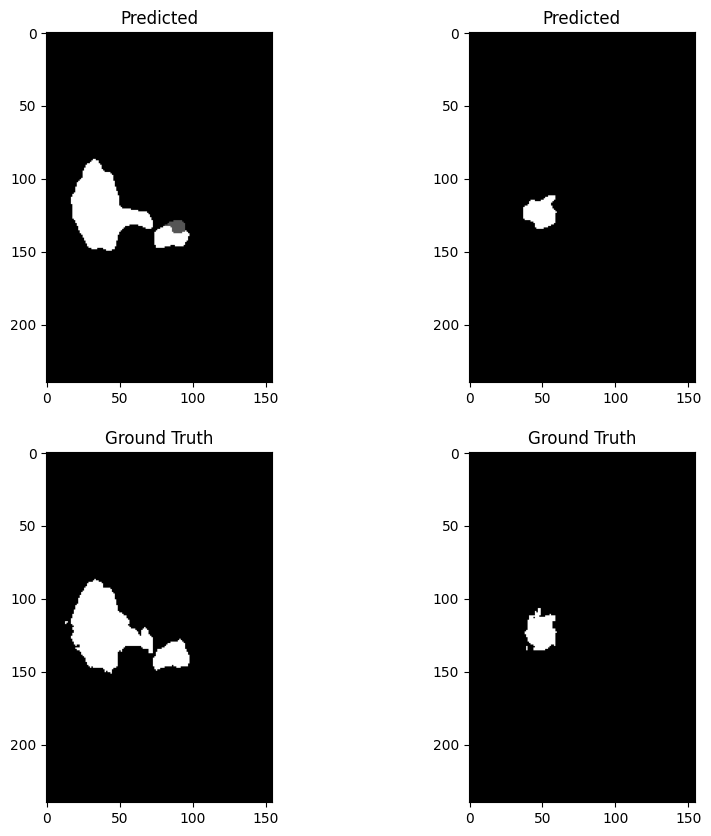

100%|██████████| 48/48 [06:17<00:00,  7.87s/it]


Average Validation Loss: 0.014313847893693795

Average Validation DSC: [0.99872054 0.85718627 0.91158789 0.66722215]
Average Validation ASSD: [ 0.13768718 20.99980554 15.52021194 42.41823274]
Epoch 53/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


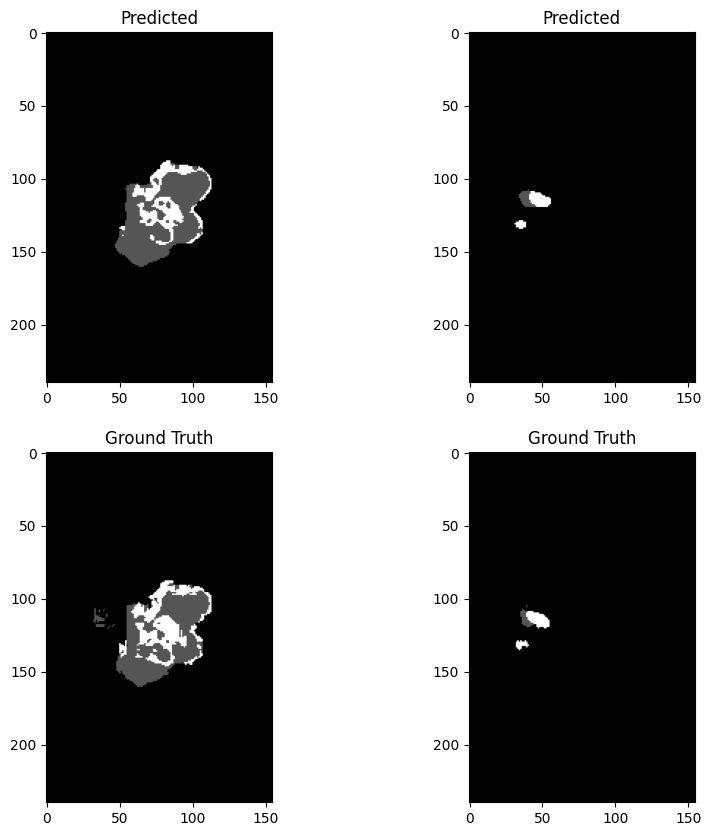

100%|██████████| 189/189 [24:23<00:00,  7.74s/it]



Average Training Loss: 0.008685441870025542

Average Training DSC: [0.99895032 0.90859691 0.93208724 0.77199727]
Average Training ASSD: [ 0.10461169  9.86413587 10.42477839 23.82435783]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


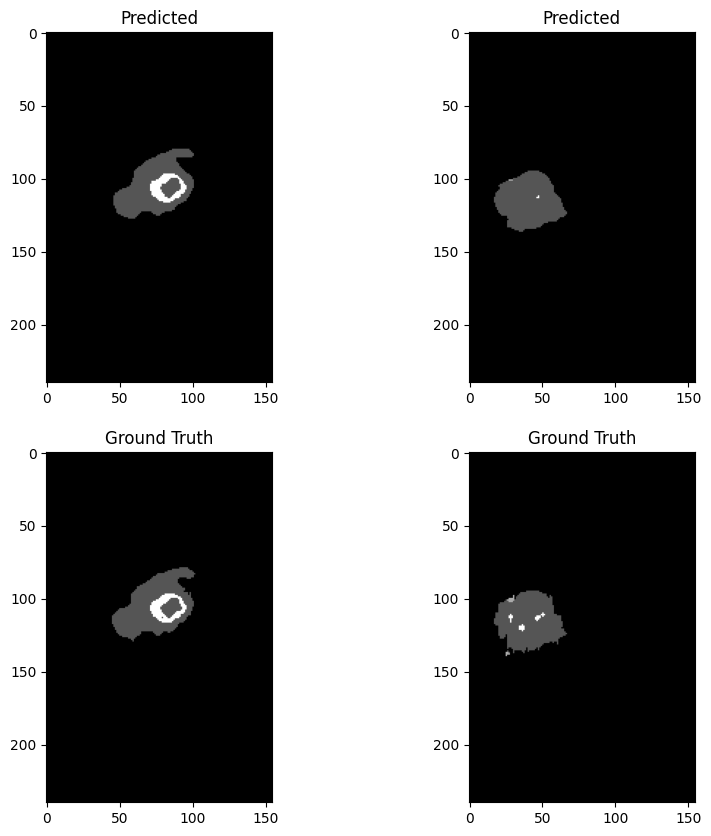

100%|██████████| 48/48 [06:30<00:00,  8.13s/it]


Average Validation Loss: 0.012470678018871695

Average Validation DSC: [0.99868844 0.87233532 0.91826315 0.72964154]
Average Validation ASSD: [ 0.14773711 20.29692982 13.2576012  32.61669584]
Epoch 54/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


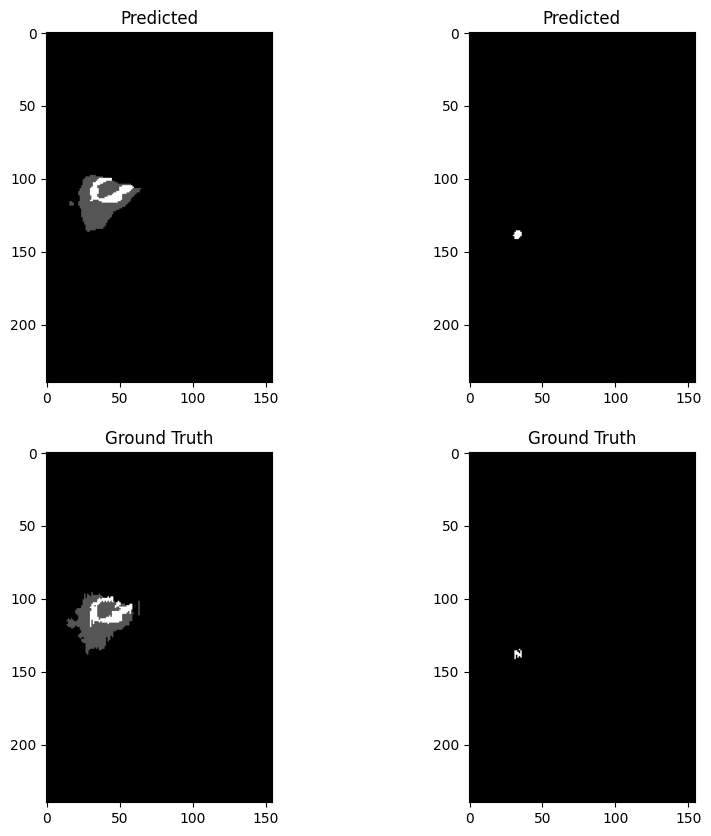

100%|██████████| 189/189 [24:37<00:00,  7.82s/it]



Average Training Loss: 0.008183718461878401

Average Training DSC: [0.99901993 0.91348271 0.93649709 0.77804181]
Average Training ASSD: [ 0.09699337  9.12501931  9.43861602 24.93666209]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


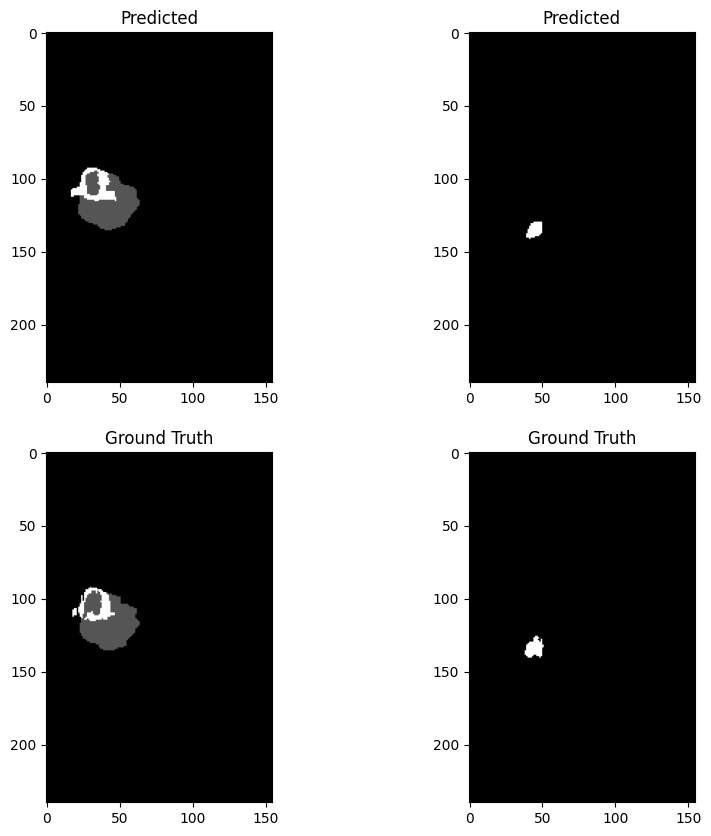

100%|██████████| 48/48 [06:09<00:00,  7.70s/it]


Average Validation Loss: 0.014379659570598355

Average Validation DSC: [0.99850384 0.85501115 0.90702403 0.73726129]
Average Validation ASSD: [ 0.15297282 20.50160176 17.06993685 22.58500152]
Epoch 55/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


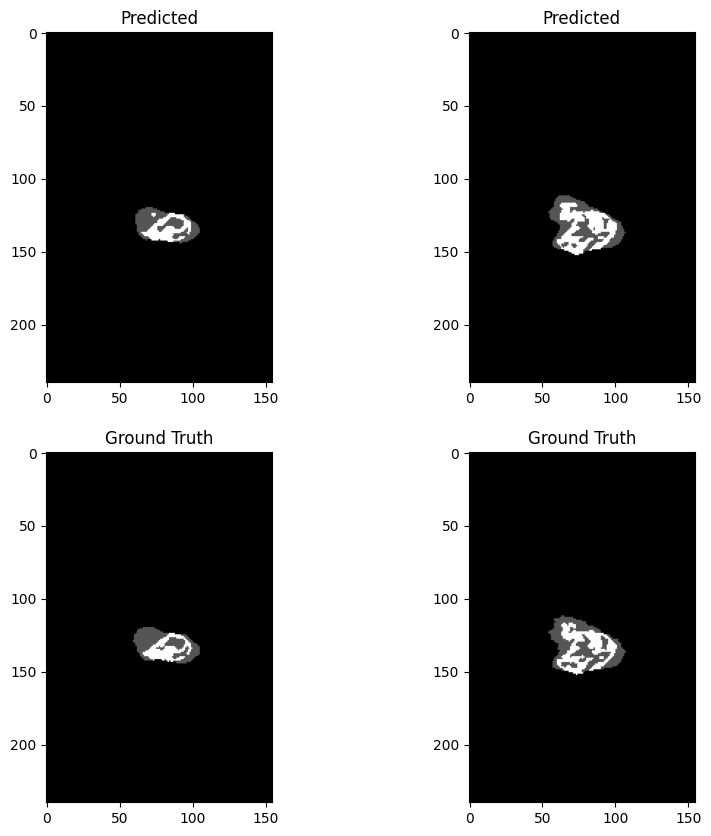

100%|██████████| 189/189 [24:18<00:00,  7.72s/it]



Average Training Loss: 0.008199358859133941

Average Training DSC: [0.99902147 0.90830668 0.9363546  0.77764108]
Average Training ASSD: [ 0.09581266 10.50516118  9.57257237 24.02823415]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


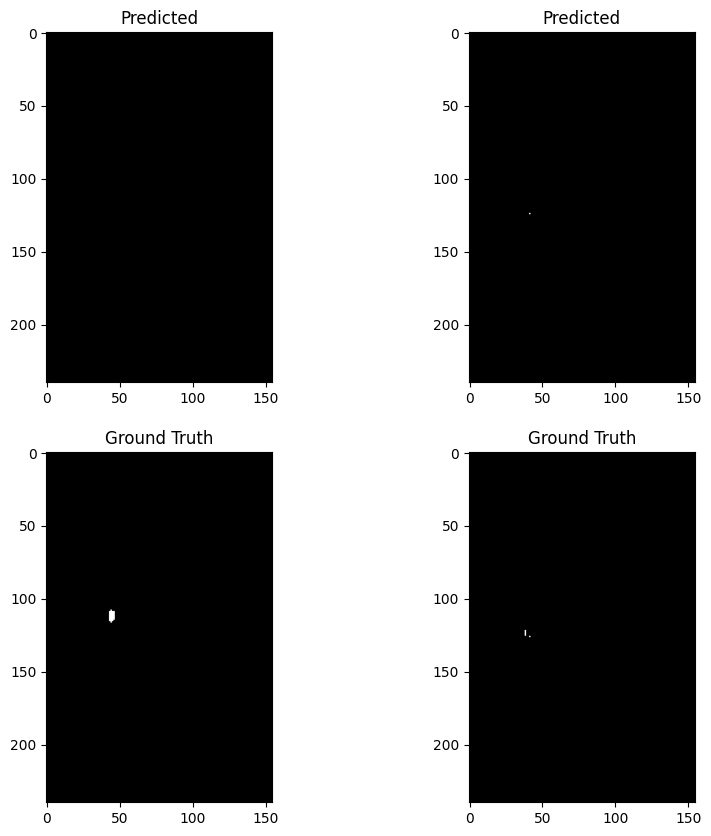

100%|██████████| 48/48 [06:01<00:00,  7.54s/it]


Average Validation Loss: 0.013817201824470734

Average Validation DSC: [0.99857987 0.75375524 0.886364   0.72088147]
Average Validation ASSD: [ 0.1411588  59.59262556 22.88440315 29.54832185]
Epoch 56/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


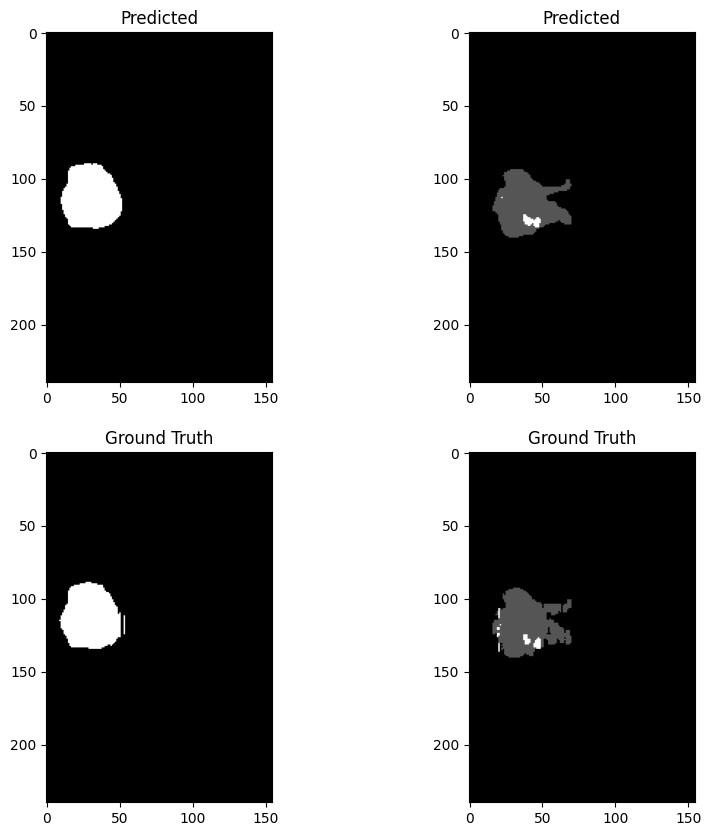

100%|██████████| 189/189 [25:18<00:00,  8.03s/it]



Average Training Loss: 0.0077264899161284565

Average Training DSC: [0.99906733 0.9189853  0.93818974 0.78573264]
Average Training ASSD: [ 0.09227984  8.38849598  9.22187766 24.2789192 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


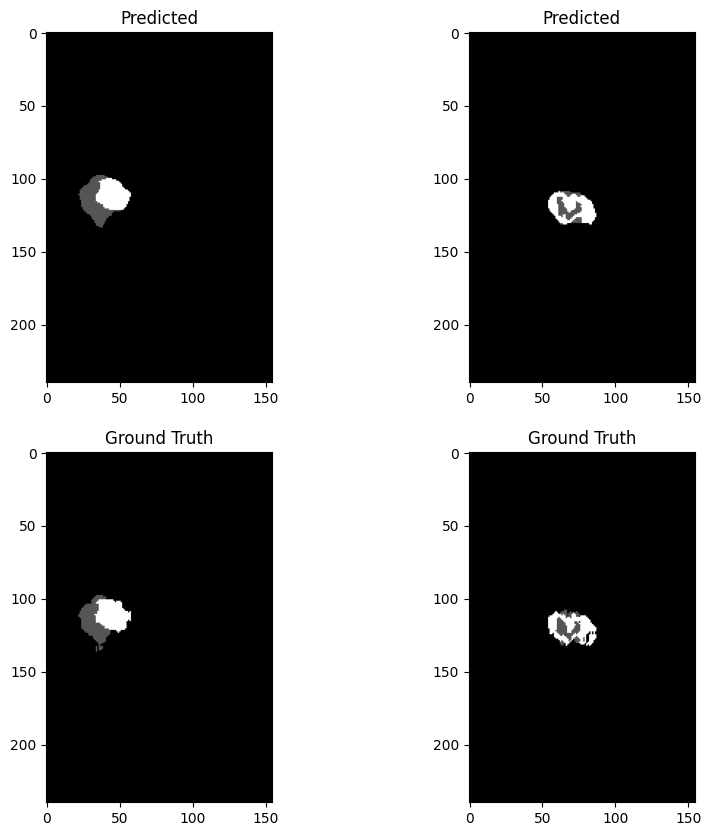

100%|██████████| 48/48 [06:12<00:00,  7.76s/it]


Average Validation Loss: 0.011693728340712065

Average Validation DSC: [0.99890074 0.89531095 0.92654559 0.76887662]
Average Validation ASSD: [ 0.10250964 15.71945524 12.66125937 24.70142625]
Epoch 57/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


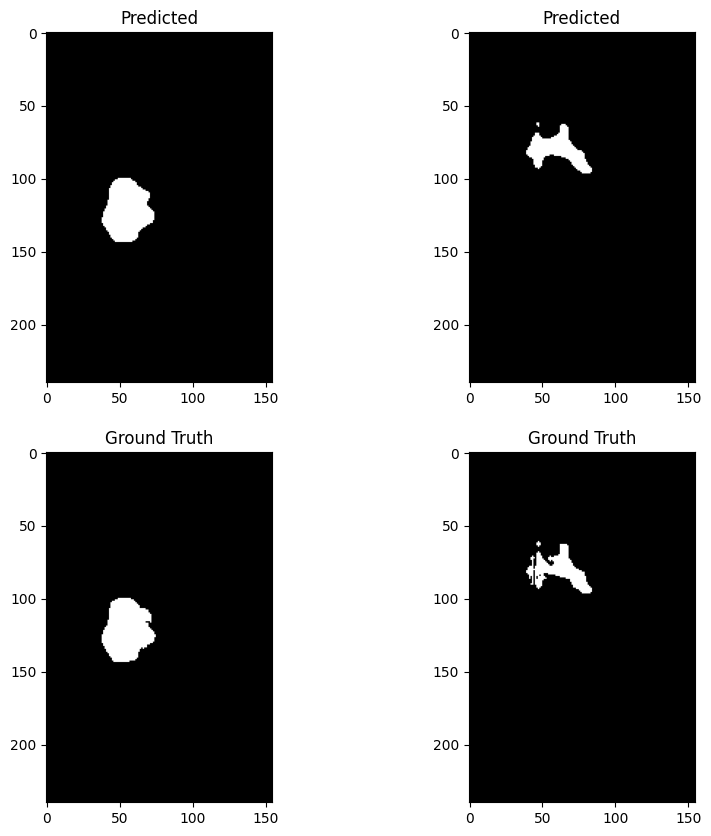

100%|██████████| 189/189 [25:21<00:00,  8.05s/it]



Average Training Loss: 0.006787360786268163

Average Training DSC: [0.99917067 0.93340264 0.94556388 0.80191827]
Average Training ASSD: [ 0.08027781  5.2899424   7.85255389 24.65957232]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


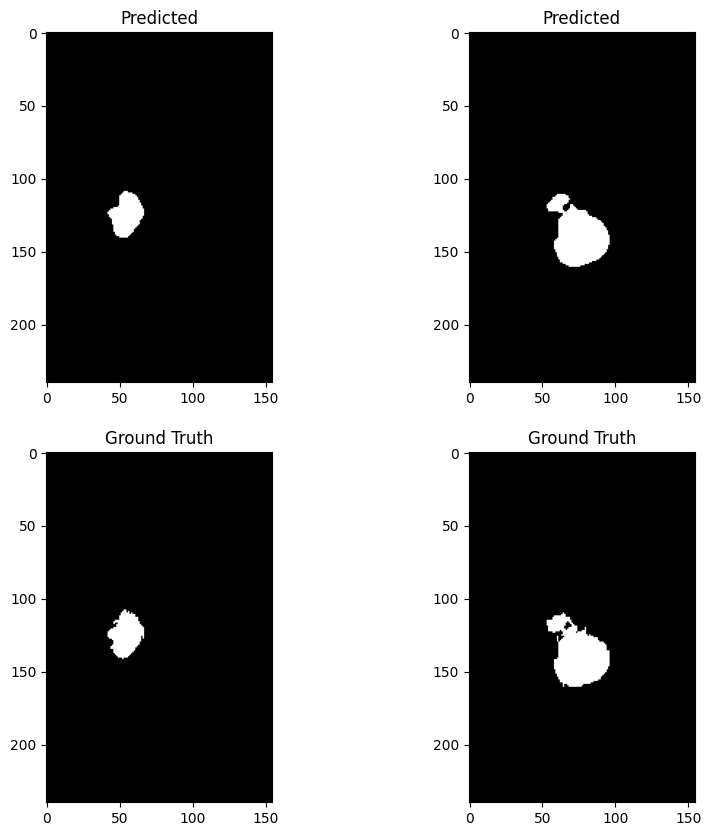

100%|██████████| 48/48 [06:15<00:00,  7.82s/it]


Average Validation Loss: 0.010901737899985164

Average Validation DSC: [0.99902292 0.90182688 0.93094163 0.78776967]
Average Validation ASSD: [ 0.09534843 13.69746497 11.09805151 21.29845818]
Epoch 58/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


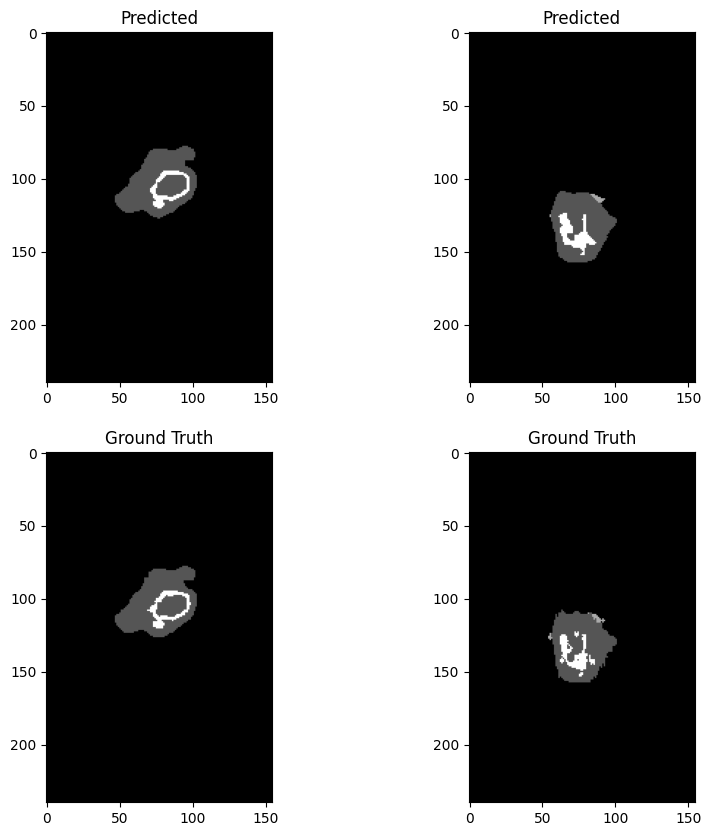

100%|██████████| 189/189 [25:40<00:00,  8.15s/it]



Average Training Loss: 0.006128067714925954

Average Training DSC: [0.99925723 0.94007935 0.94978685 0.81456227]
Average Training ASSD: [ 0.07119271  4.00756595  7.40925325 24.75641086]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


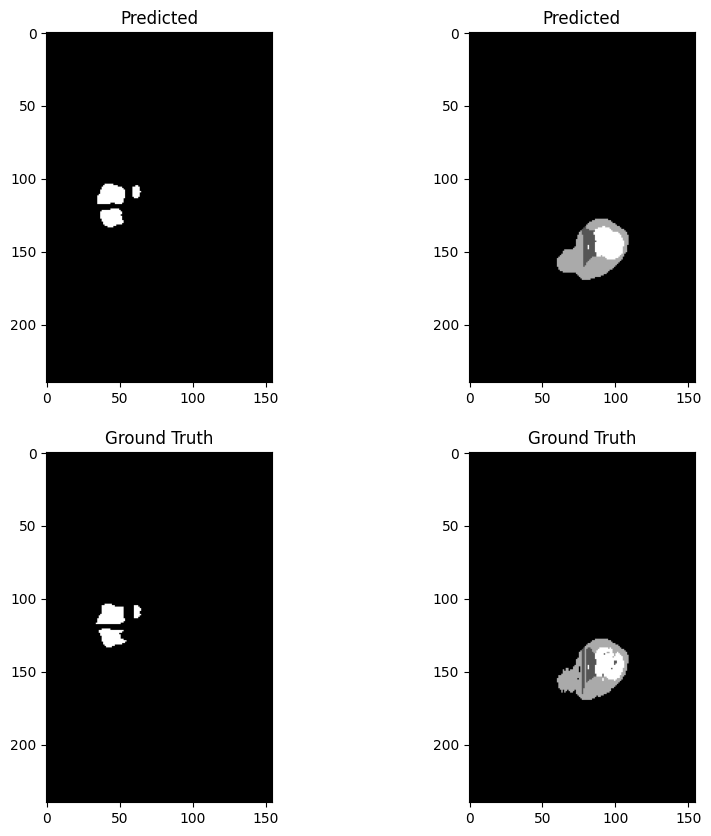

100%|██████████| 48/48 [06:04<00:00,  7.60s/it]


Average Validation Loss: 0.010900871711783111

Average Validation DSC: [0.99902269 0.90538822 0.93308657 0.78577924]
Average Validation ASSD: [ 0.0917434  12.62470031 11.42911077 22.09614303]
Epoch 59/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


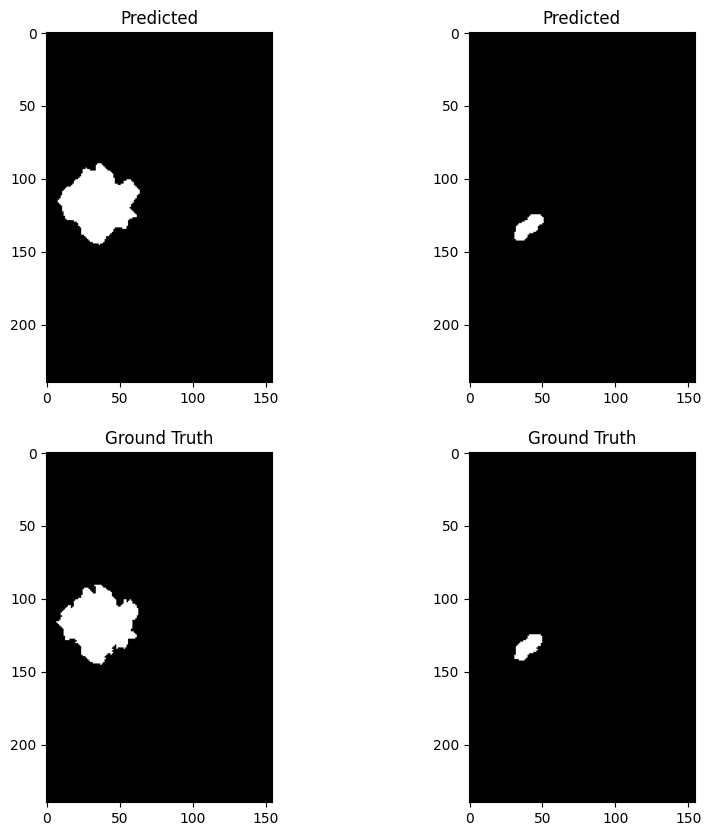

100%|██████████| 189/189 [25:28<00:00,  8.09s/it]



Average Training Loss: 0.006009782463676794

Average Training DSC: [0.99927484 0.9406147  0.95086654 0.81802591]
Average Training ASSD: [ 0.06953914  3.64737706  6.9935339  23.71723026]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


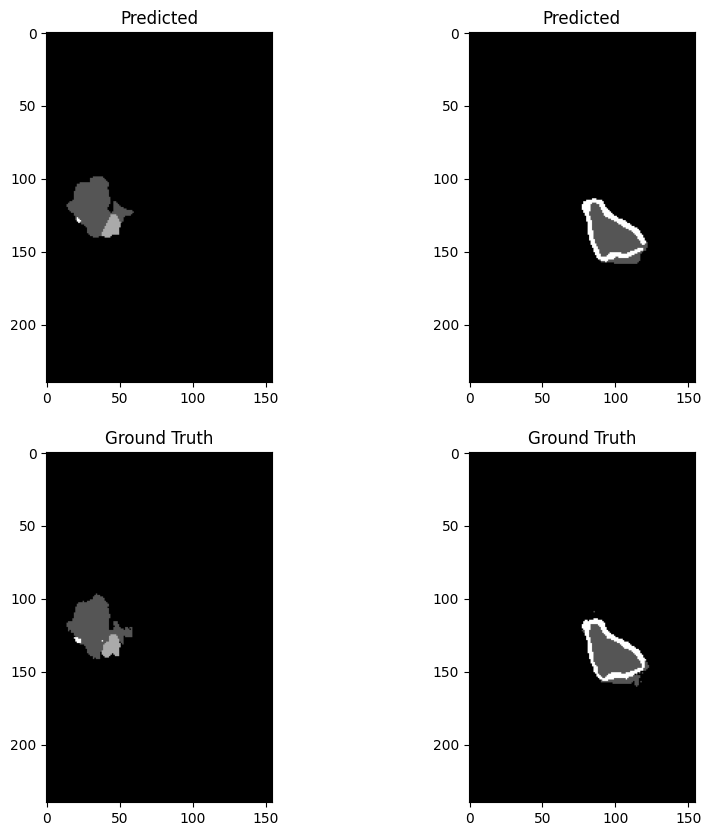

100%|██████████| 48/48 [06:07<00:00,  7.65s/it]


Average Validation Loss: 0.010846627497812733

Average Validation DSC: [0.99908685 0.91040084 0.93547549 0.78548336]
Average Validation ASSD: [ 0.09307837 12.13694129 10.81816033 24.1693148 ]
Epoch 60/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


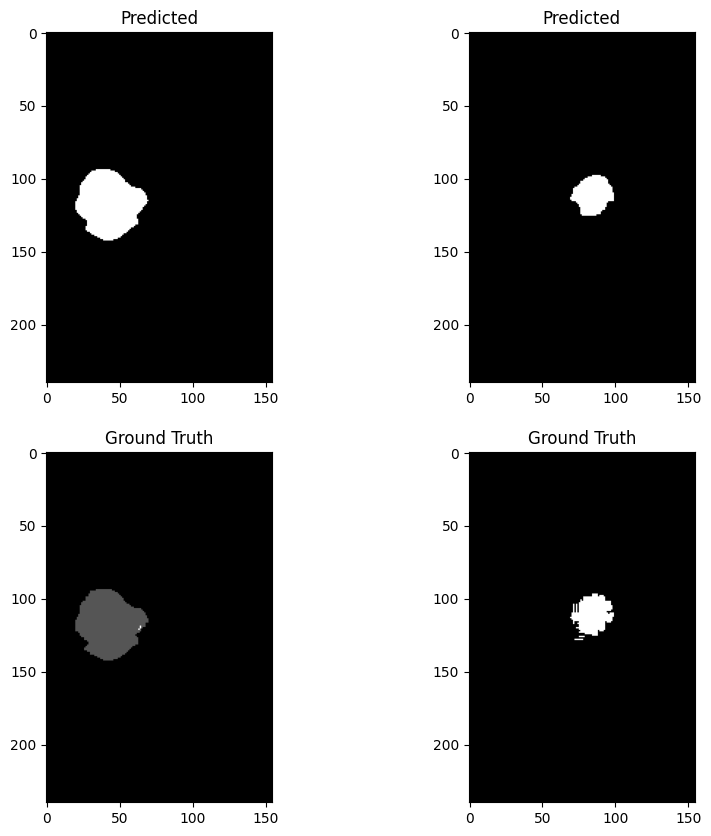

100%|██████████| 189/189 [24:23<00:00,  7.74s/it]



Average Training Loss: 0.00586555671395251

Average Training DSC: [0.99929728 0.94149205 0.95085018 0.82275825]
Average Training ASSD: [ 0.06646979  3.87831168  6.569228   22.9636986 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


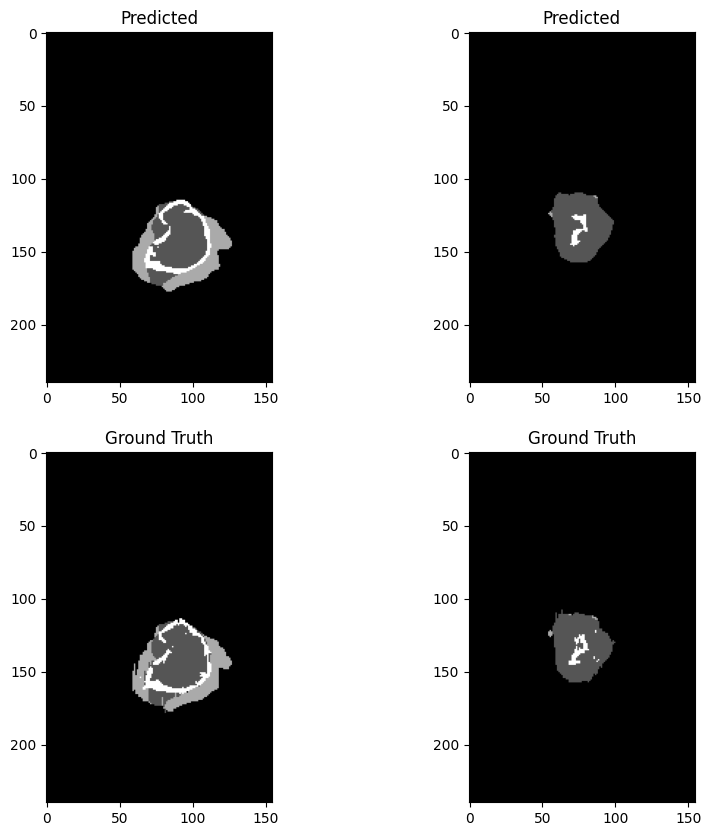

100%|██████████| 48/48 [05:42<00:00,  7.14s/it]


Average Validation Loss: 0.010860901975926632

Average Validation DSC: [0.99906774 0.90714032 0.93514908 0.79364225]
Average Validation ASSD: [ 0.08934995 12.75394247 11.73509226 22.87788664]
Epoch 61/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


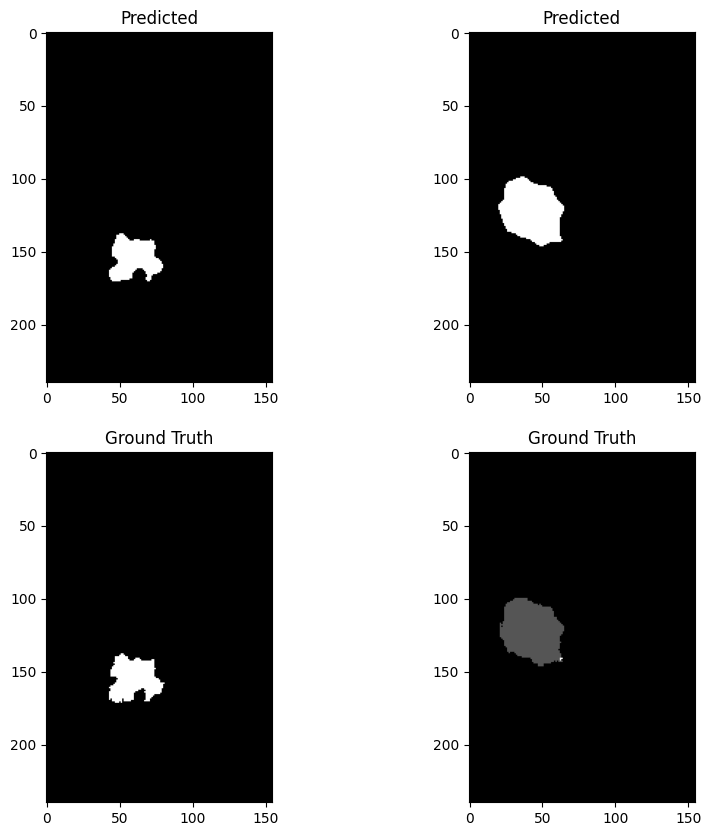

100%|██████████| 189/189 [25:25<00:00,  8.07s/it]



Average Training Loss: 0.005988880740626464

Average Training DSC: [0.99927103 0.9404728  0.94952015 0.82081035]
Average Training ASSD: [ 0.06927767  3.76234499  7.75479791 23.51531139]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


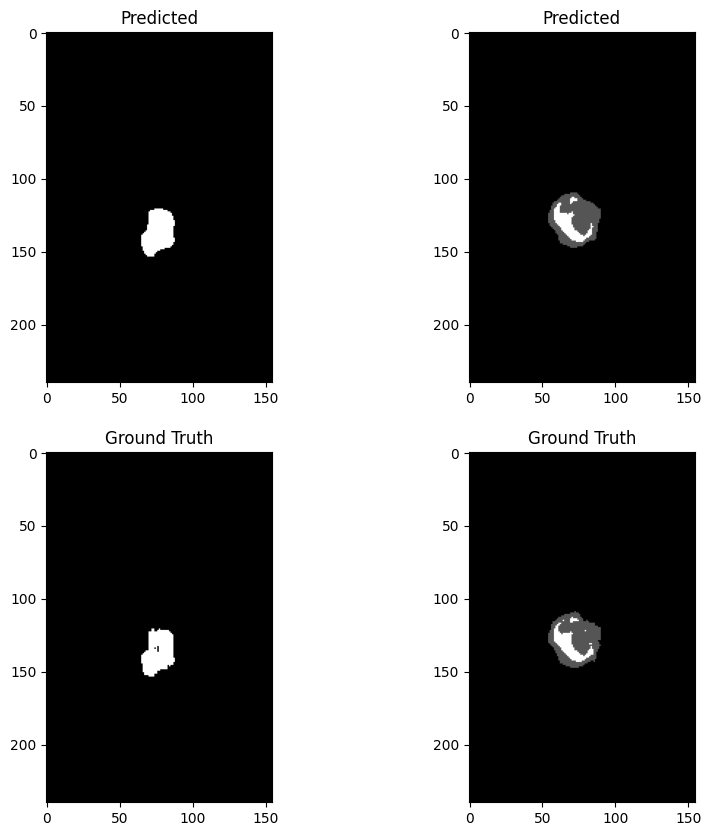

100%|██████████| 48/48 [06:06<00:00,  7.63s/it]


Average Validation Loss: 0.010729714408322858

Average Validation DSC: [0.99908765 0.91005688 0.93202583 0.7950514 ]
Average Validation ASSD: [ 0.09224622 11.67458828 11.29558036 23.55290131]
Epoch 62/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


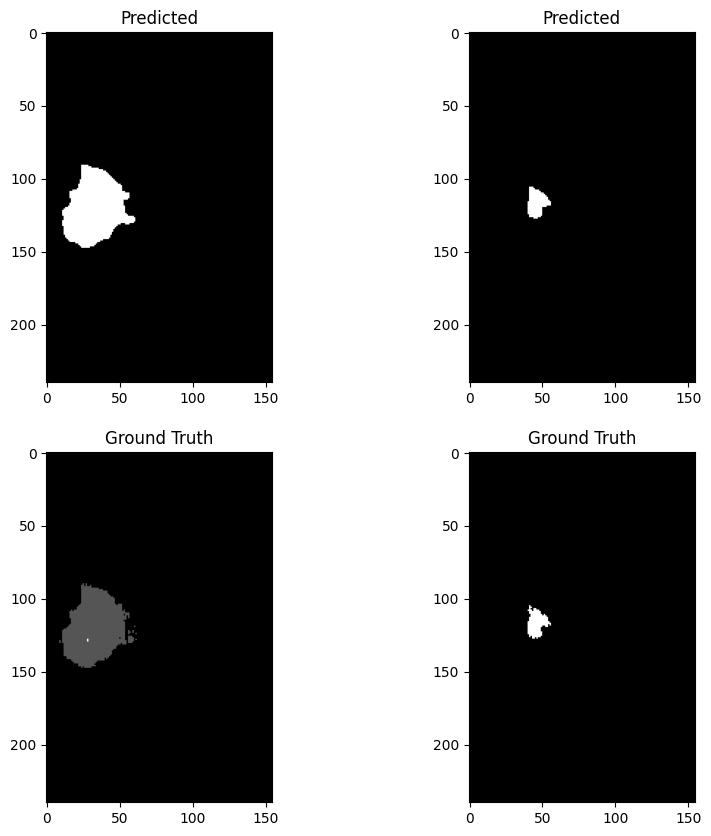

100%|██████████| 189/189 [25:20<00:00,  8.05s/it]



Average Training Loss: 0.005726512118671385

Average Training DSC: [0.99931088 0.94259884 0.95154373 0.82687289]
Average Training ASSD: [ 0.0636484   3.6321357   7.09747408 22.35927474]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


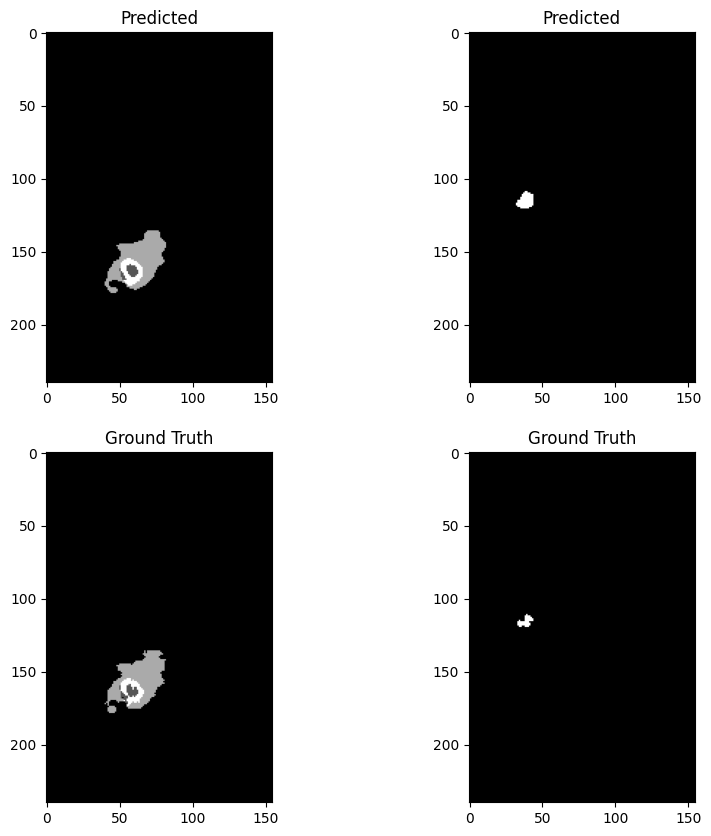

100%|██████████| 48/48 [06:07<00:00,  7.66s/it]


Average Validation Loss: 0.0109472308443704

Average Validation DSC: [0.99908131 0.90978342 0.93397534 0.80205872]
Average Validation ASSD: [ 0.08448057 11.6559487  10.84769577 16.01591346]
Epoch 63/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


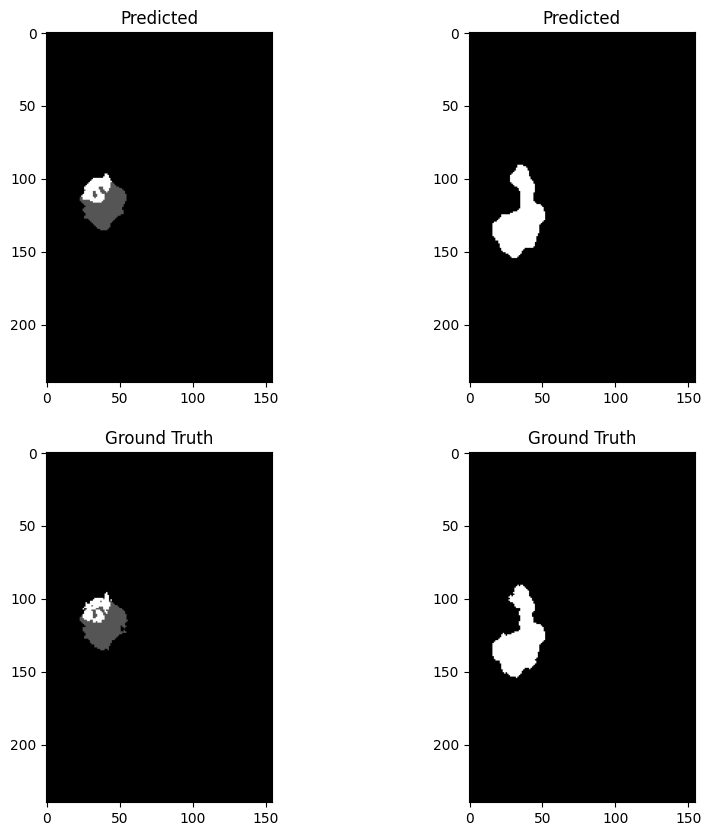

100%|██████████| 189/189 [24:31<00:00,  7.79s/it]



Average Training Loss: 0.005602979878574689

Average Training DSC: [0.99932613 0.94358609 0.95218923 0.82897065]
Average Training ASSD: [ 0.06375237  3.56831598  6.97375201 22.53664699]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


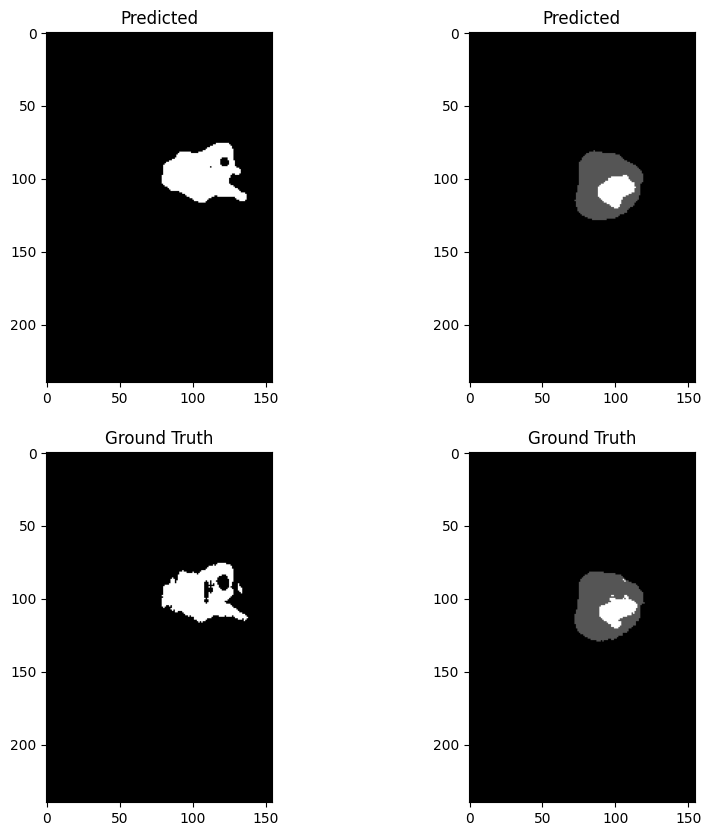

100%|██████████| 48/48 [06:30<00:00,  8.13s/it]


Average Validation Loss: 0.011122273514047265

Average Validation DSC: [0.99907314 0.90922845 0.93673121 0.79138166]
Average Validation ASSD: [ 0.08460689 12.85033936  9.40106887 22.48019101]
Epoch 64/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


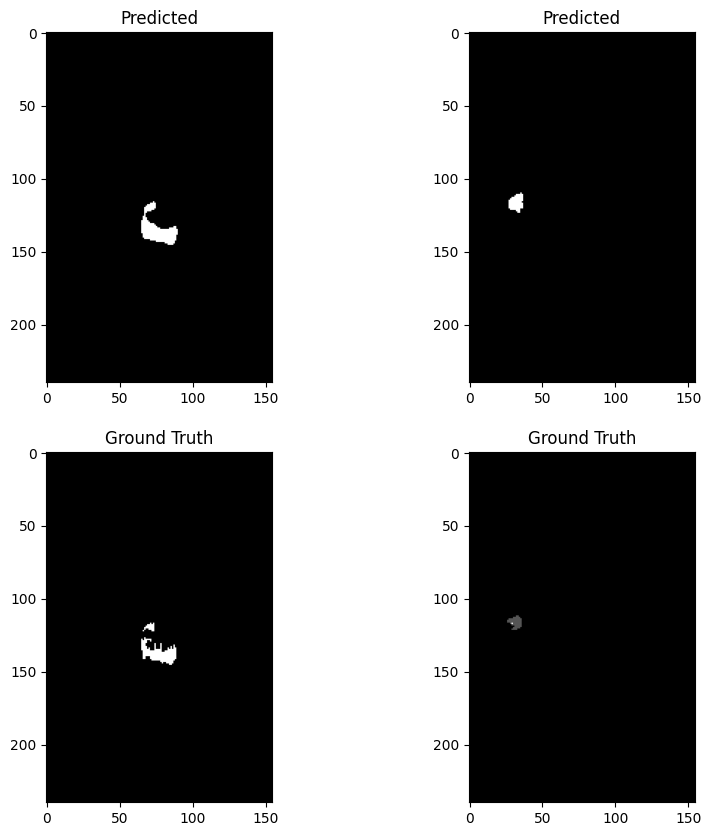

100%|██████████| 189/189 [25:09<00:00,  7.98s/it]



Average Training Loss: 0.005437096063461568

Average Training DSC: [0.99934856 0.94473354 0.95407407 0.83217239]
Average Training ASSD: [ 0.06066693  3.38242421  6.36726467 22.19436172]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


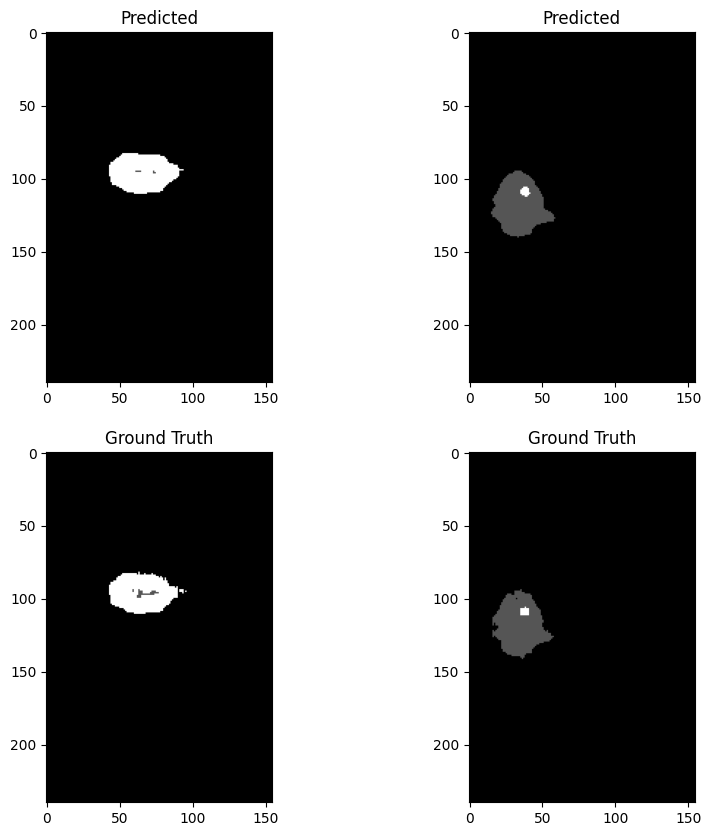

100%|██████████| 48/48 [06:17<00:00,  7.87s/it]


Average Validation Loss: 0.010832617330985764

Average Validation DSC: [0.99913544 0.91027146 0.93205459 0.80304202]
Average Validation ASSD: [ 0.0853526  11.89794006 11.66547043 19.47000324]
Epoch 65/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


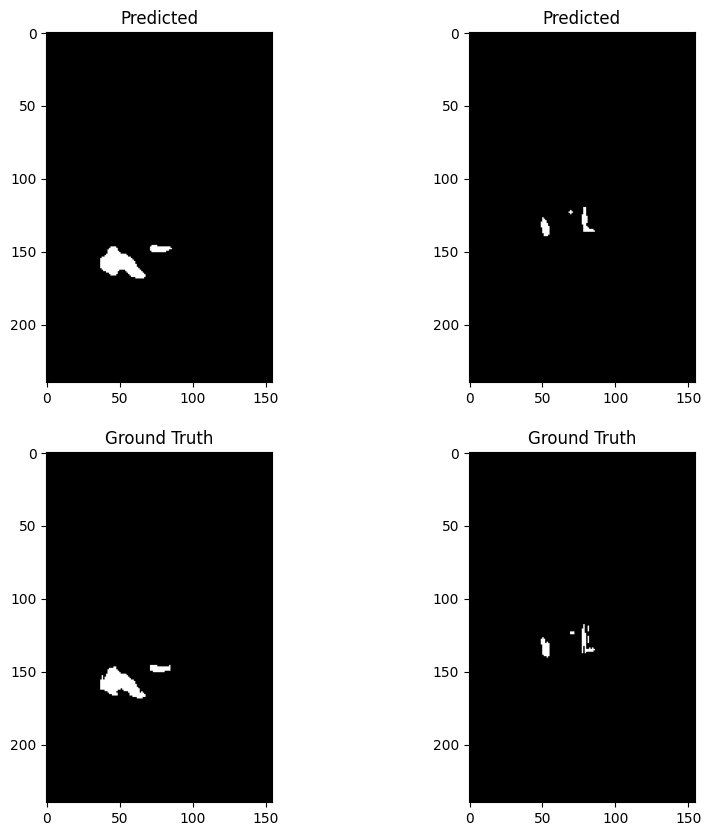

100%|██████████| 189/189 [25:01<00:00,  7.94s/it]



Average Training Loss: 0.005355100710408161

Average Training DSC: [0.99936244 0.94594177 0.95405219 0.8357664 ]
Average Training ASSD: [ 0.05936928  3.25710265  6.4943383  20.82866906]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


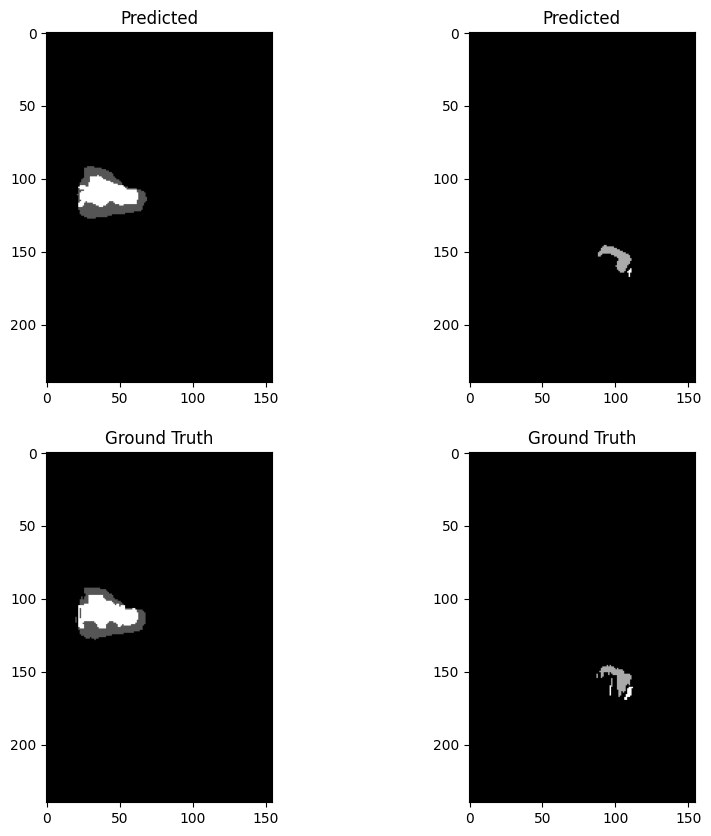

100%|██████████| 48/48 [06:13<00:00,  7.79s/it]


Average Validation Loss: 0.01101240620482713

Average Validation DSC: [0.99913397 0.9107618  0.93814357 0.80025105]
Average Validation ASSD: [ 0.07822054 12.59079098  9.87375878 20.49574012]
Epoch 66/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


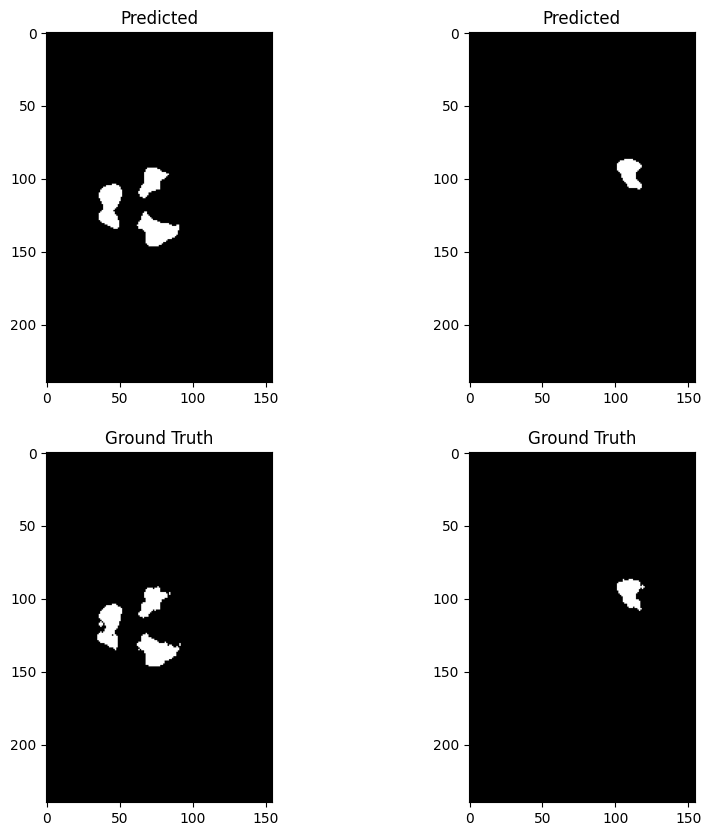

100%|██████████| 189/189 [25:24<00:00,  8.06s/it]



Average Training Loss: 0.005297379616263603

Average Training DSC: [0.99937419 0.94575708 0.95395635 0.83584689]
Average Training ASSD: [ 0.0580272   3.31795803  6.60992086 20.66795852]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


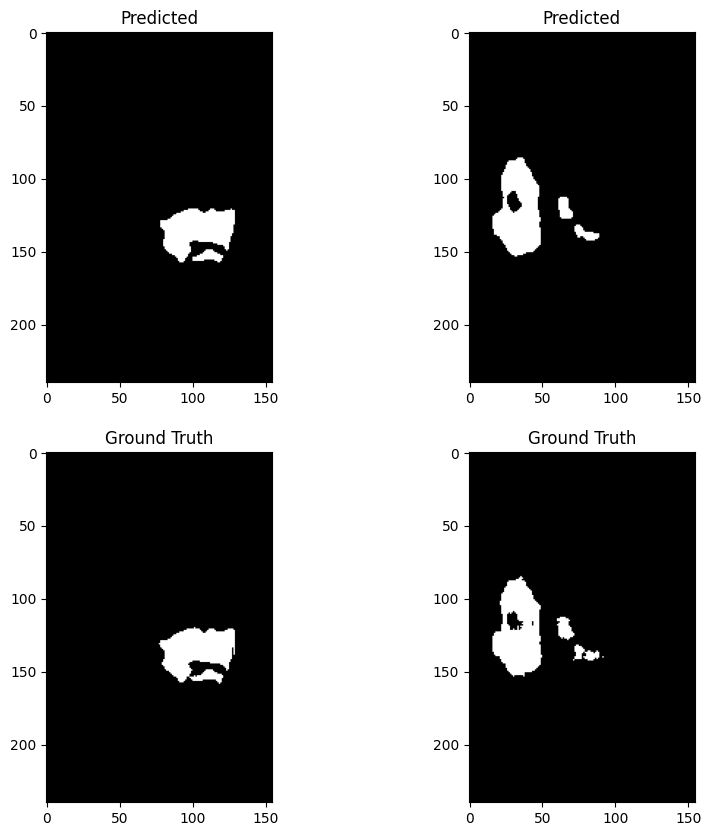

100%|██████████| 48/48 [05:59<00:00,  7.50s/it]


Average Validation Loss: 0.010983447195030749

Average Validation DSC: [0.99914813 0.91194354 0.93422768 0.80005103]
Average Validation ASSD: [ 0.08465713 12.58724616 11.42289647 21.69605866]
Epoch 67/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


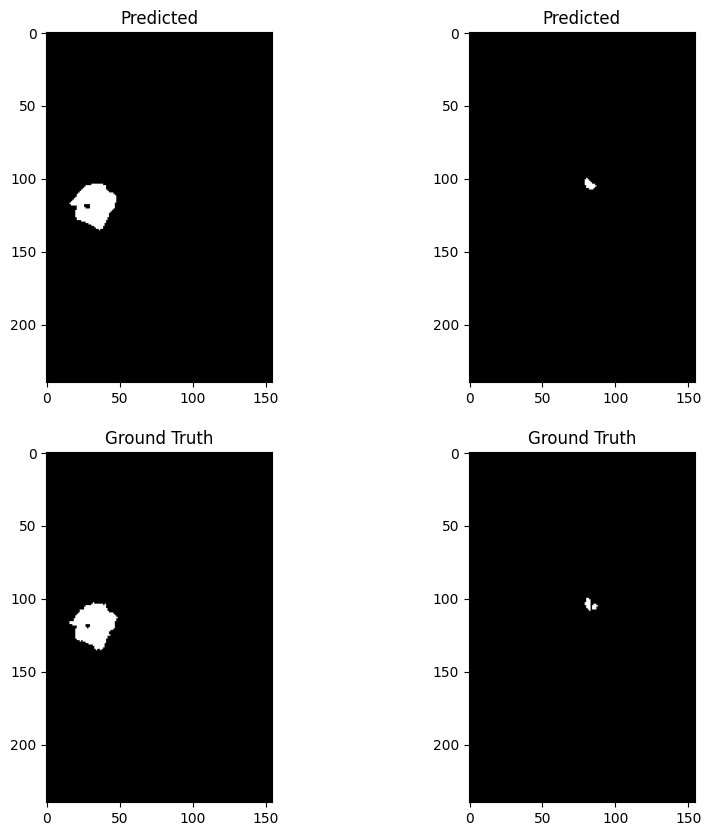

100%|██████████| 189/189 [24:42<00:00,  7.84s/it]



Average Training Loss: 0.005150262345239599

Average Training DSC: [0.99939281 0.94687847 0.95358678 0.83939701]
Average Training ASSD: [ 0.05676628  3.36791032  6.96534613 20.39263619]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


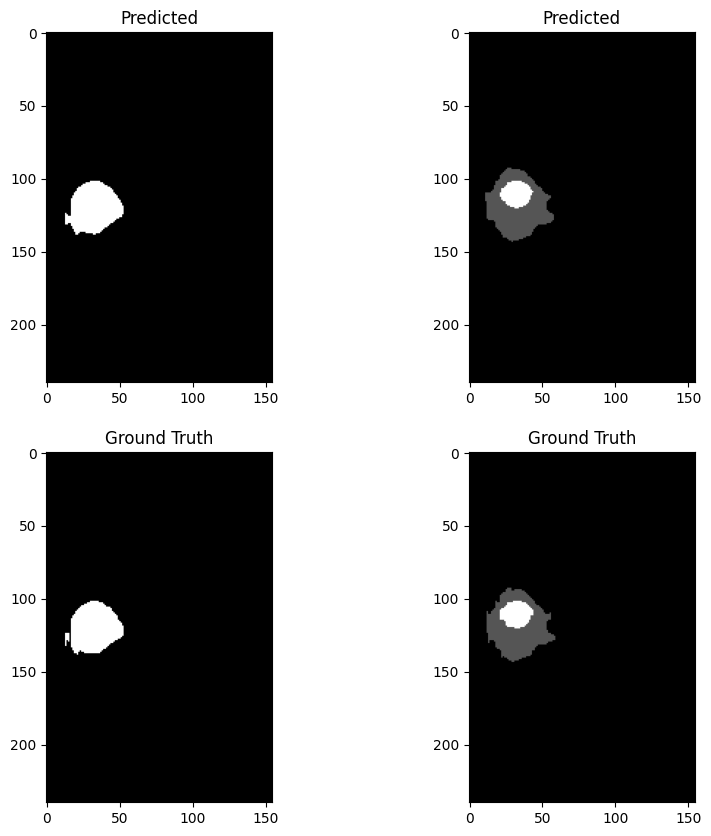

100%|██████████| 48/48 [05:51<00:00,  7.33s/it]


Average Validation Loss: 0.01105350440290446

Average Validation DSC: [0.99915809 0.9140814  0.93323895 0.80152332]
Average Validation ASSD: [ 0.07819662 11.87455651 11.07487892 21.18486974]
Epoch 68/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


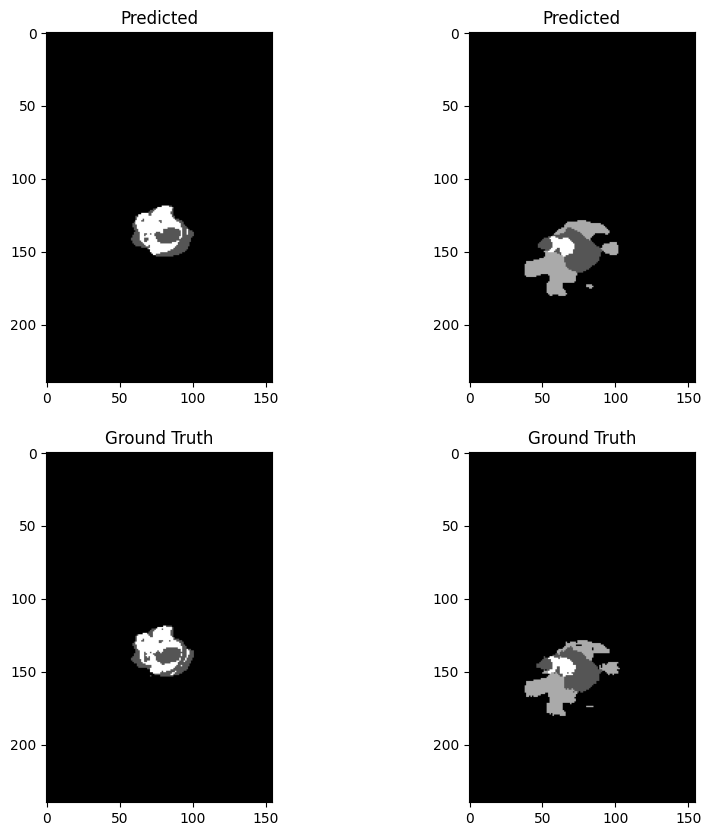

100%|██████████| 189/189 [25:13<00:00,  8.01s/it]



Average Training Loss: 0.00512104439696977

Average Training DSC: [0.99938827 0.94744669 0.95496813 0.84259124]
Average Training ASSD: [ 0.05562349  3.06818557  6.41946096 19.67642057]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


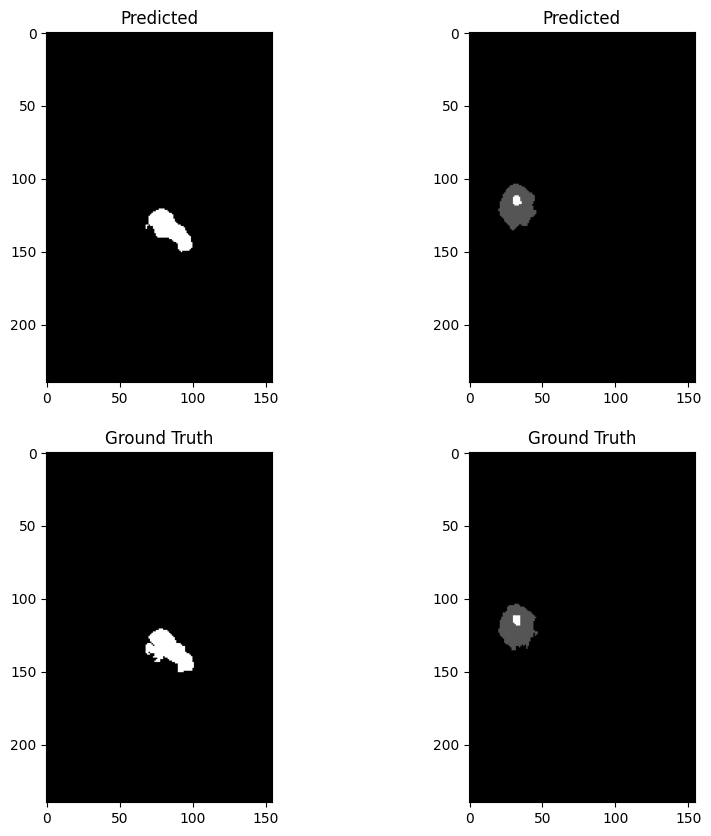

100%|██████████| 48/48 [06:00<00:00,  7.52s/it]


Average Validation Loss: 0.01076658081728965

Average Validation DSC: [0.99913887 0.91577878 0.94113516 0.80771018]
Average Validation ASSD: [ 0.08369146 11.1525069   9.37551984 19.42963415]
Epoch 69/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


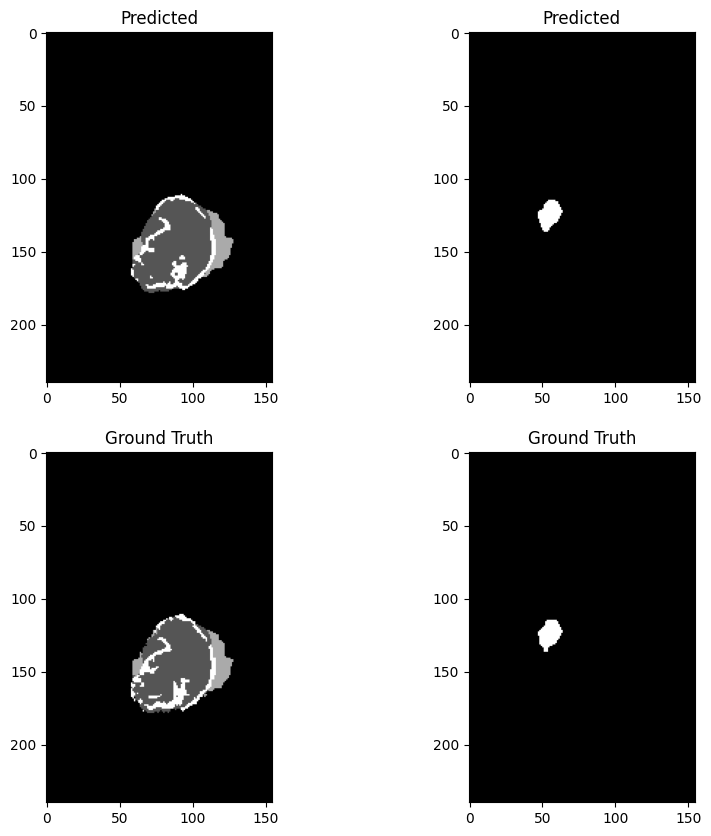

100%|██████████| 189/189 [25:38<00:00,  8.14s/it]



Average Training Loss: 0.00505576165954745

Average Training DSC: [0.99940177 0.94799548 0.95549124 0.84204616]
Average Training ASSD: [ 0.05470919  3.30395058  5.96886052 19.62015714]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


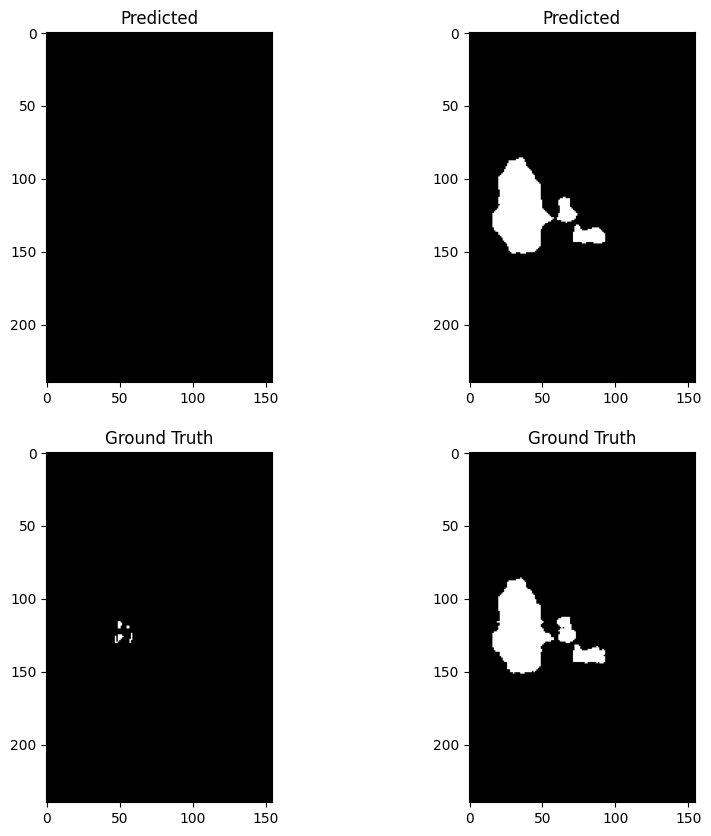

100%|██████████| 48/48 [06:07<00:00,  7.67s/it]


Average Validation Loss: 0.010877045657252893

Average Validation DSC: [0.99919051 0.91335747 0.94181362 0.80605522]
Average Validation ASSD: [ 0.07305455 12.34363312  9.14542902 20.68753489]
Epoch 70/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


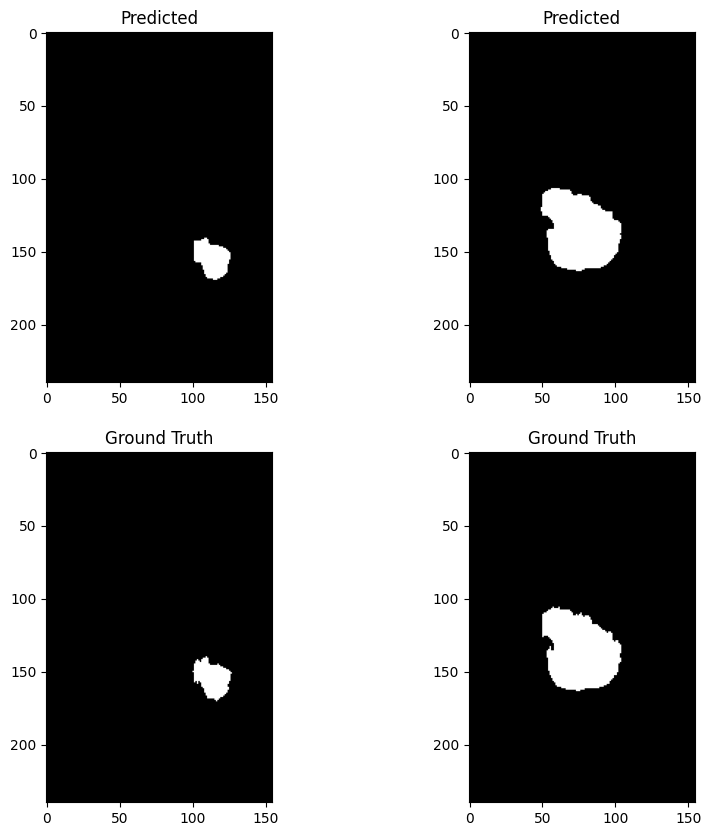

100%|██████████| 189/189 [25:26<00:00,  8.08s/it]



Average Training Loss: 0.004941011695240541

Average Training DSC: [0.99941277 0.94799538 0.95718775 0.84690947]
Average Training ASSD: [ 0.05346244  3.41568787  6.25196634 18.34932622]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


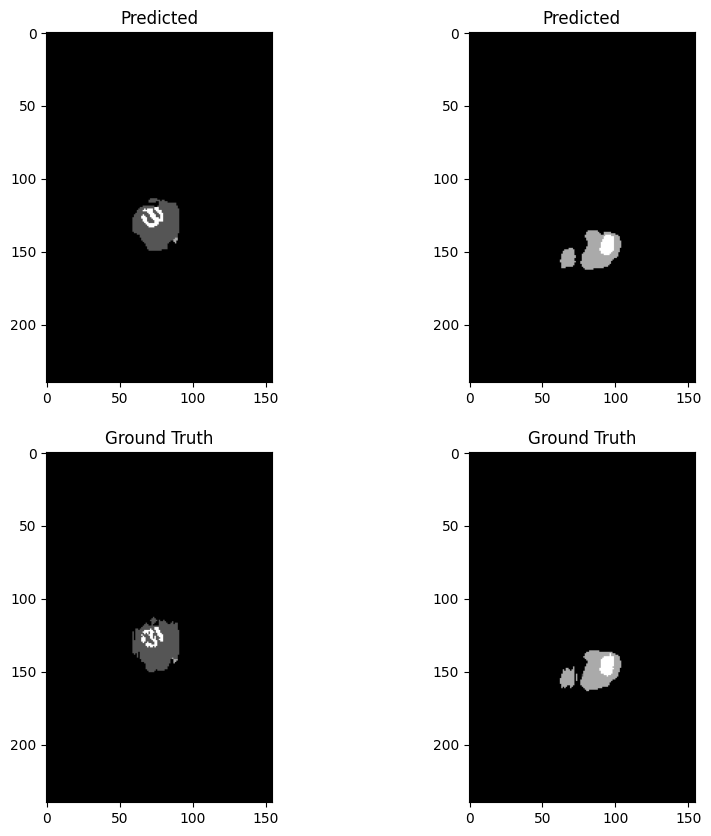

100%|██████████| 48/48 [05:48<00:00,  7.26s/it]


Average Validation Loss: 0.010807406516202414

Average Validation DSC: [0.99918268 0.90767253 0.94219539 0.81776612]
Average Validation ASSD: [ 0.07361681 12.3502297   8.68180726 13.70218698]
Epoch 71/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


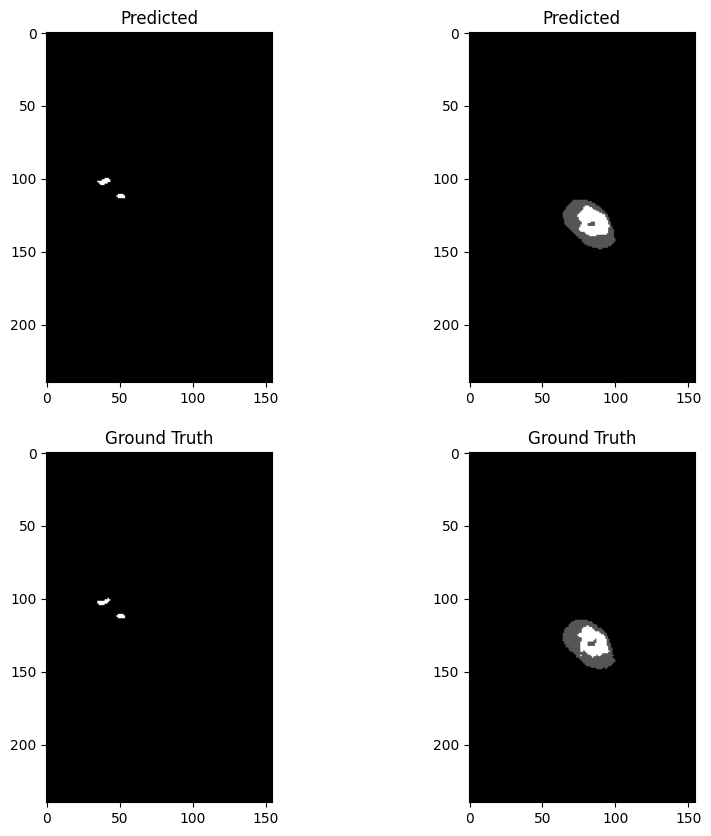

100%|██████████| 189/189 [25:42<00:00,  8.16s/it]



Average Training Loss: 0.0047653476614012286

Average Training DSC: [0.99943934 0.95051299 0.9581314  0.84861591]
Average Training ASSD: [ 0.05158629  3.04983417  5.75921703 19.62837274]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


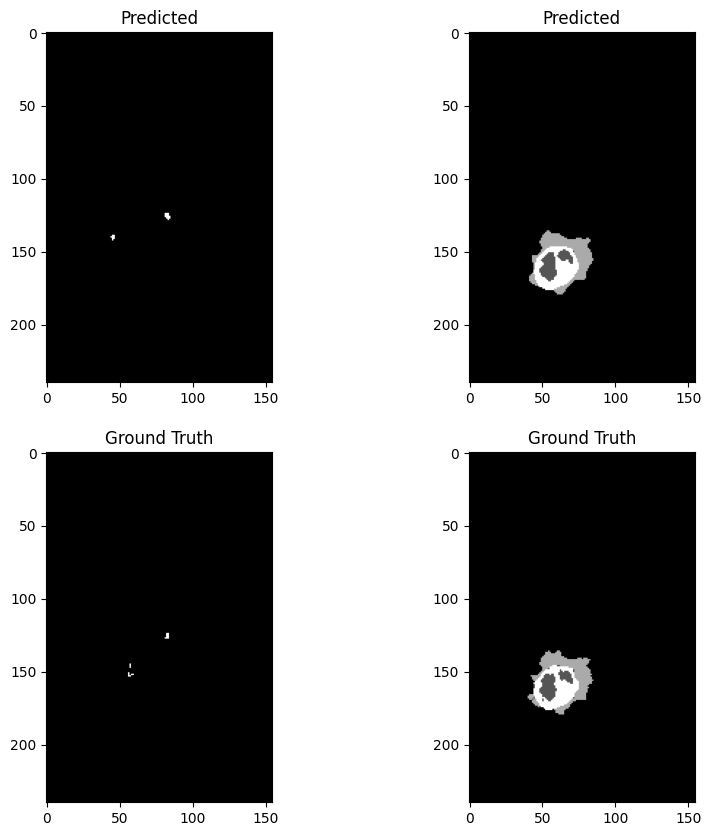

100%|██████████| 48/48 [06:35<00:00,  8.23s/it]


Average Validation Loss: 0.010570801154244691

Average Validation DSC: [0.99918172 0.90942434 0.93889779 0.81929108]
Average Validation ASSD: [ 0.07315573 13.75627944  9.41419384 16.69122671]
Epoch 72/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


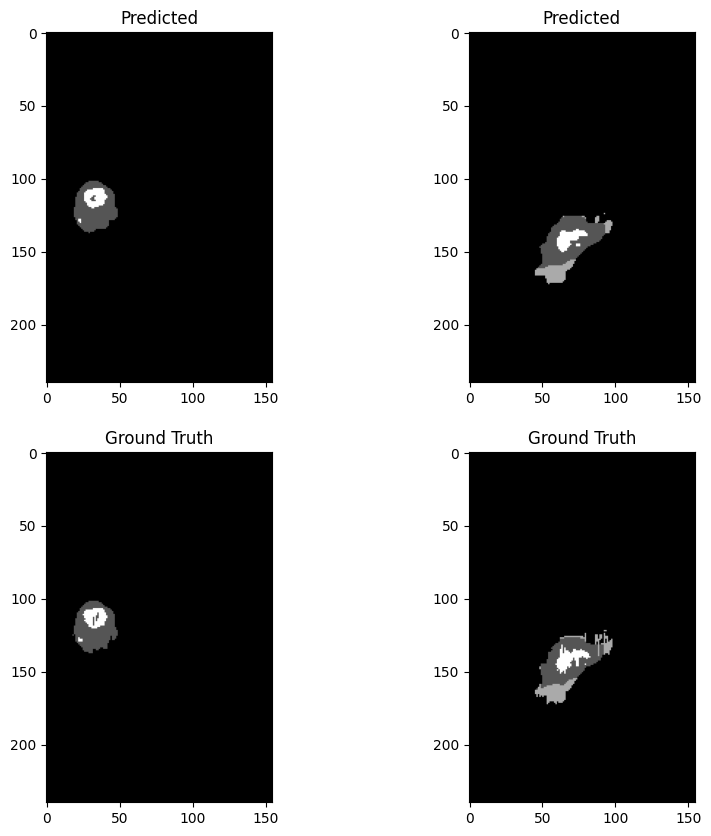

100%|██████████| 189/189 [24:19<00:00,  7.72s/it]



Average Training Loss: 0.00493701466817468

Average Training DSC: [0.99942063 0.94776432 0.95257922 0.84718191]
Average Training ASSD: [ 0.05309211  3.47588938  7.33286805 18.47073041]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


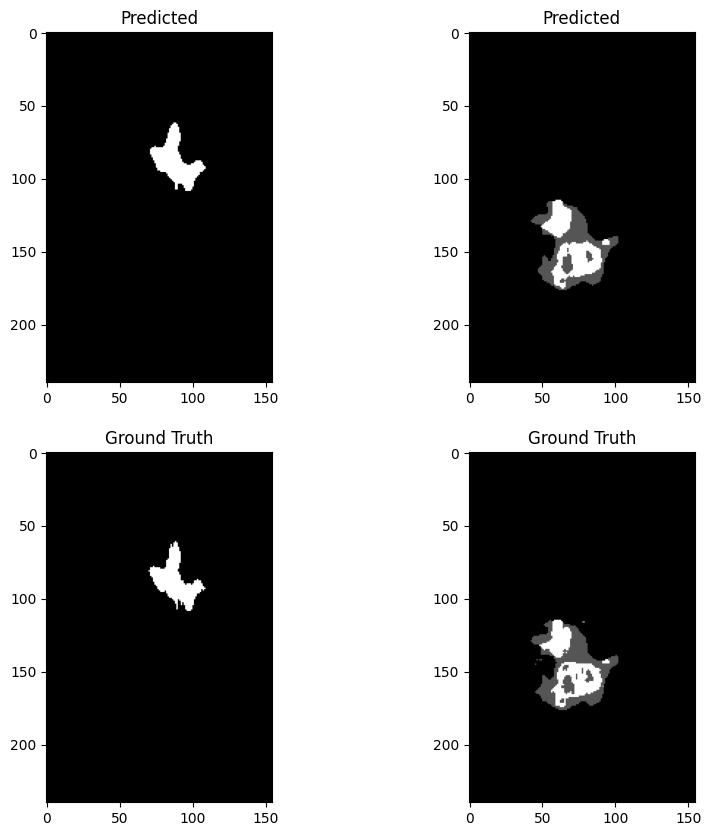

100%|██████████| 48/48 [05:38<00:00,  7.05s/it]


Average Validation Loss: 0.010757826579113802

Average Validation DSC: [0.99915366 0.91236409 0.93404067 0.81135544]
Average Validation ASSD: [ 0.08308465 12.57586219 11.98501739 20.49814579]
Epoch 73/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


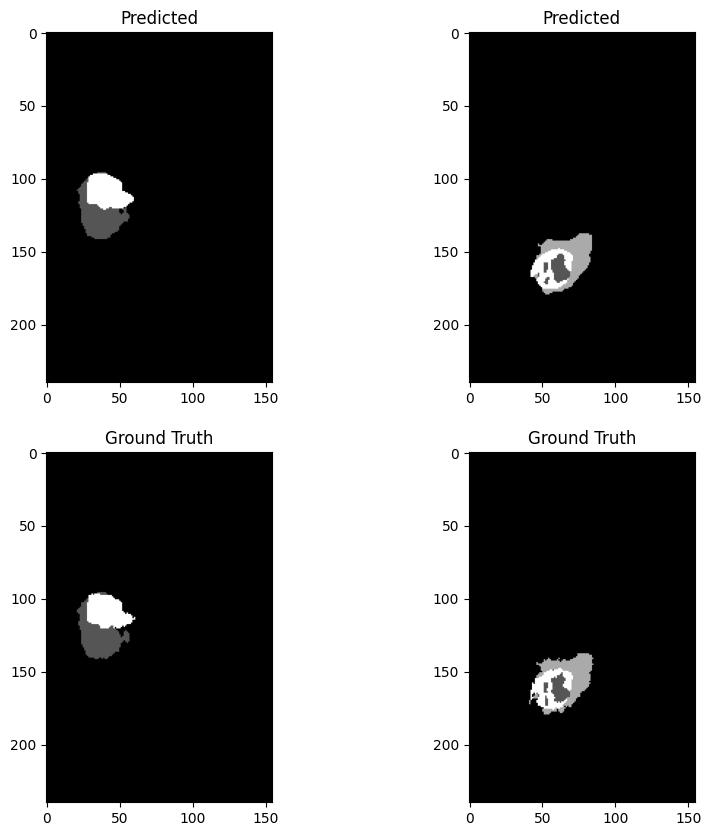

100%|██████████| 189/189 [18:20<00:00,  5.82s/it]



Average Training Loss: 0.006729532845032514

Average Training DSC: [0.99921595 0.92284712 0.93464074 0.81895746]
Average Training ASSD: [ 0.08138153  9.01169214 11.755075   19.57240976]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


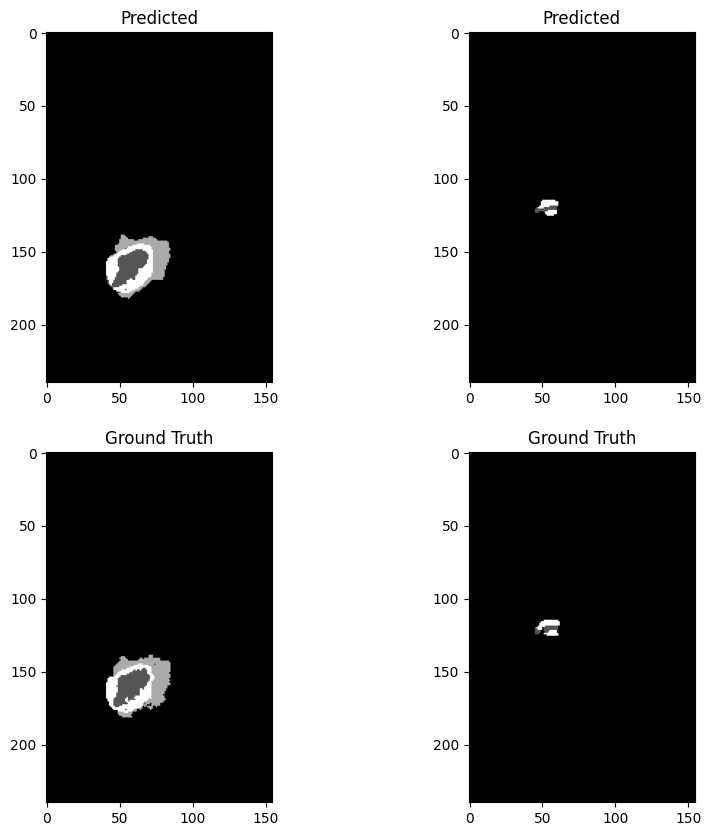

100%|██████████| 48/48 [04:24<00:00,  5.51s/it]


Average Validation Loss: 0.013709053921047598

Average Validation DSC: [0.99859639 0.82816679 0.90356547 0.72084131]
Average Validation ASSD: [ 0.16102426 30.52503432 16.67988595 26.786044  ]
Epoch 74/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


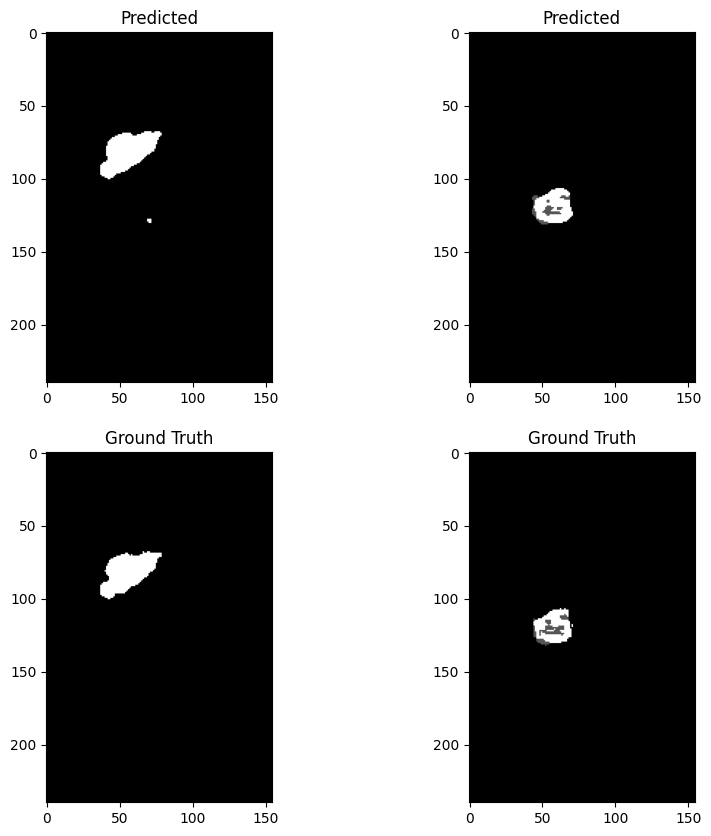

100%|██████████| 189/189 [19:00<00:00,  6.04s/it]



Average Training Loss: 0.00983536565213134

Average Training DSC: [0.99888166 0.87799991 0.90891473 0.76292142]
Average Training ASSD: [ 0.12180029 19.77567996 18.02101547 21.35088793]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


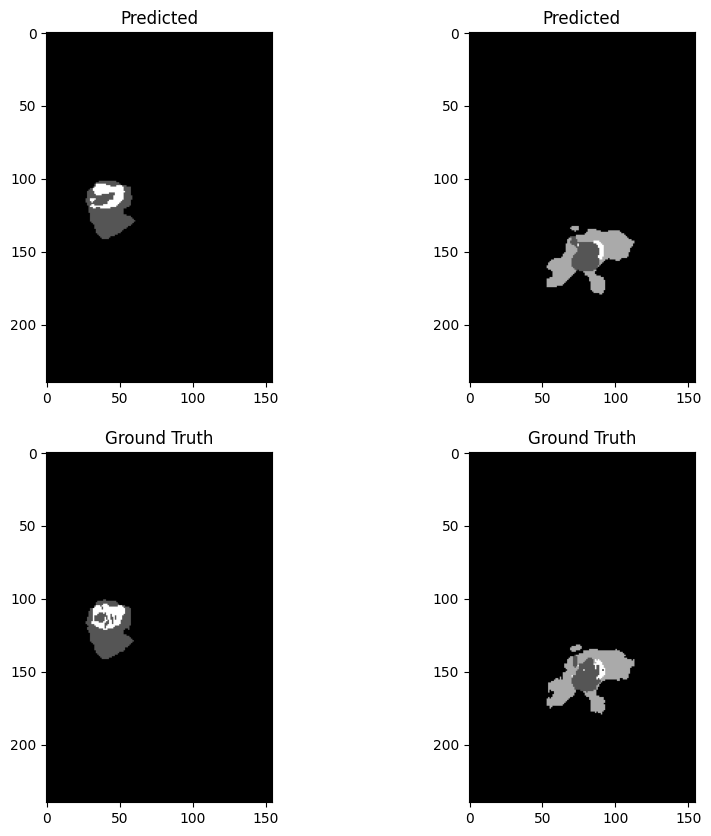

100%|██████████| 48/48 [04:50<00:00,  6.04s/it]


Average Validation Loss: 0.010298341532082608

Average Validation DSC: [0.99892865 0.88053625 0.92164768 0.76585182]
Average Validation ASSD: [ 0.11672702 20.69152087 13.2629401  22.67799404]
Epoch 75/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


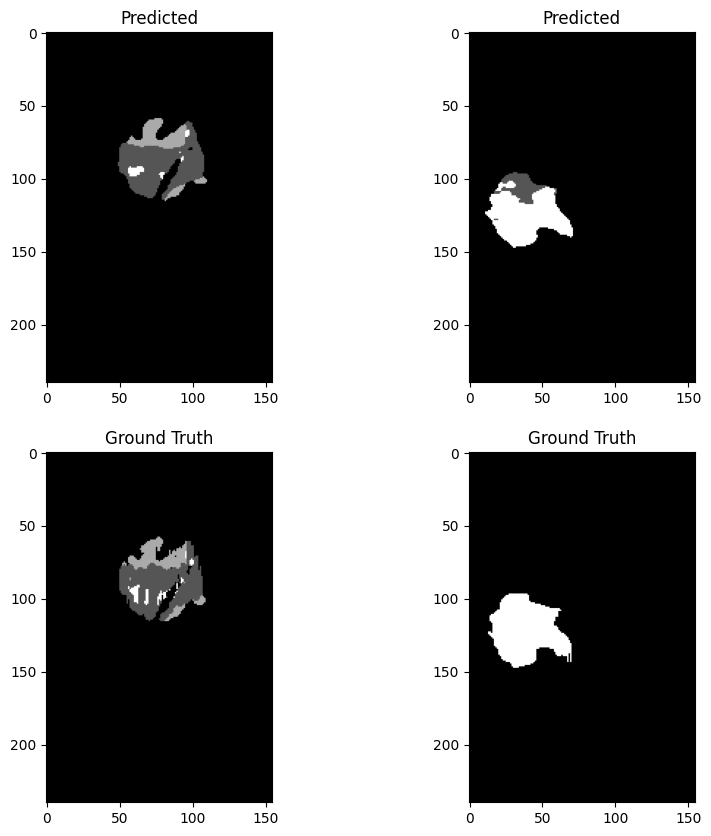

100%|██████████| 189/189 [19:29<00:00,  6.19s/it]



Average Training Loss: 0.0077850331438991125

Average Training DSC: [0.99912157 0.90849346 0.93608023 0.79275427]
Average Training ASSD: [ 0.09149379 13.03762969 10.7544704  20.24807786]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


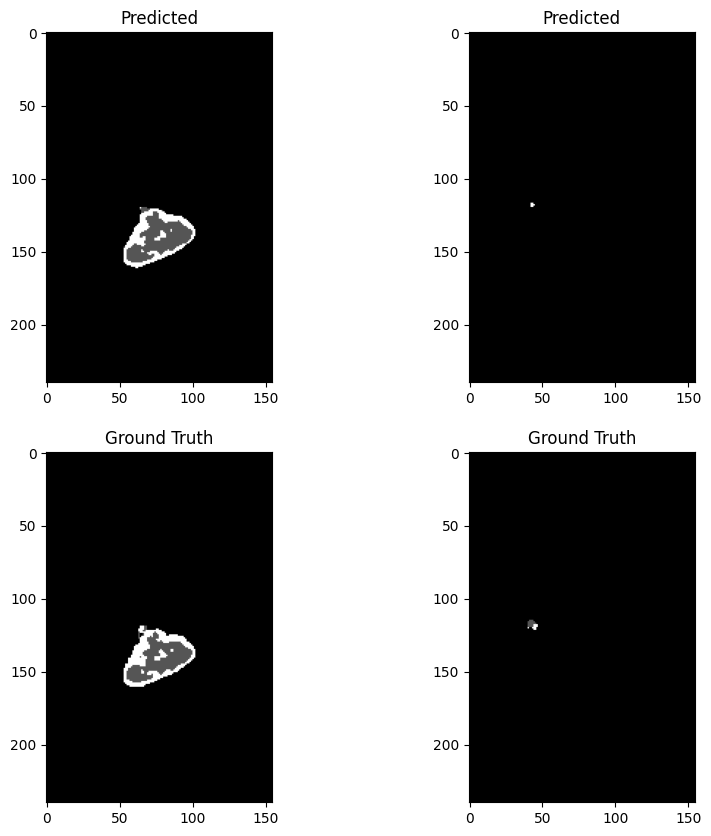

100%|██████████| 48/48 [04:28<00:00,  5.59s/it]


Average Validation Loss: 0.010838381761762625

Average Validation DSC: [0.9990127  0.89248183 0.93431341 0.75431253]
Average Validation ASSD: [ 0.09993939 16.23017065 10.36590802 27.18722682]
Epoch 76/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


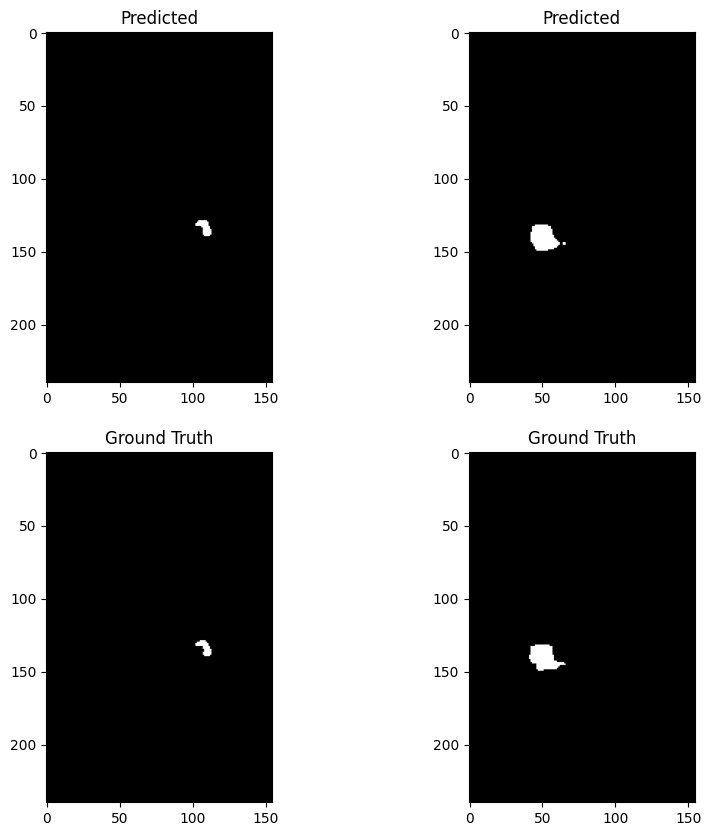

100%|██████████| 189/189 [19:51<00:00,  6.30s/it]



Average Training Loss: 0.00604526278385449

Average Training DSC: [0.99929809 0.93285471 0.95025549 0.82093254]
Average Training ASSD: [ 0.06926854  6.99129961  7.93239511 19.65929169]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


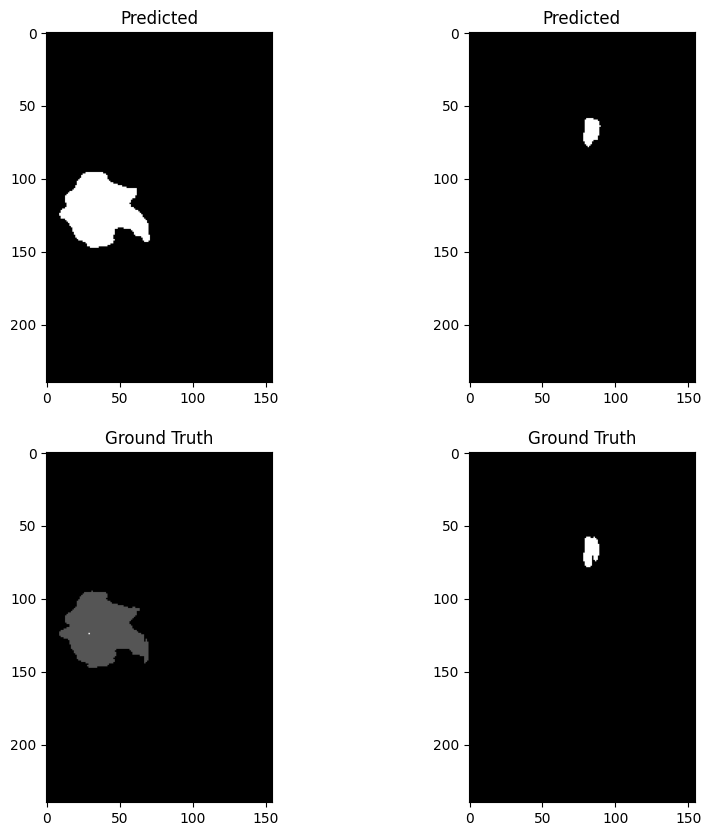

100%|██████████| 48/48 [04:51<00:00,  6.07s/it]


Average Validation Loss: 0.010687990628260499

Average Validation DSC: [0.99913908 0.9068729  0.94230882 0.79188747]
Average Validation ASSD: [ 0.0933233  15.63049375  9.83754774 24.31888285]
Epoch 77/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


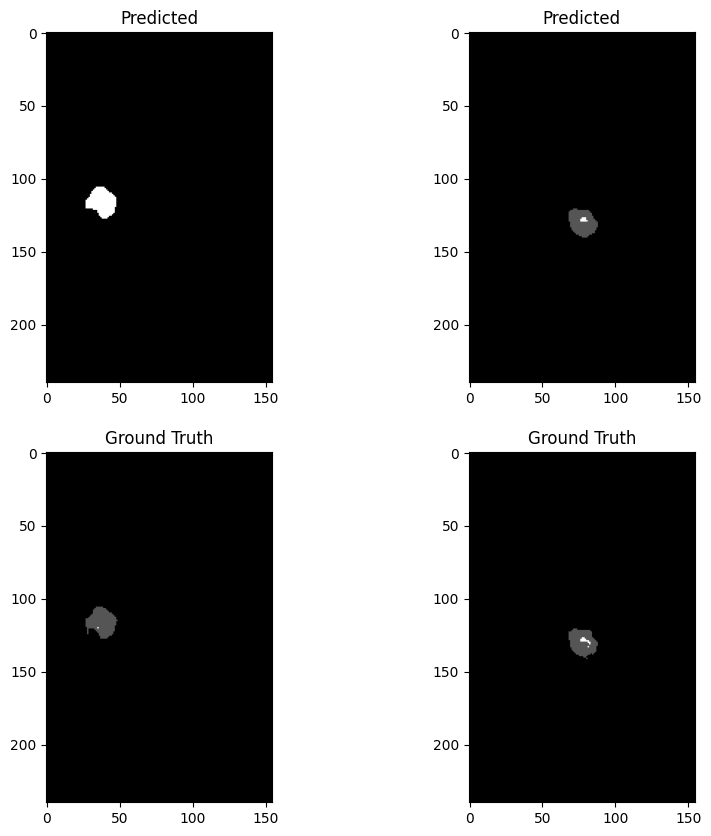

100%|██████████| 189/189 [19:27<00:00,  6.18s/it]



Average Training Loss: 0.005118045263563987

Average Training DSC: [0.9994188  0.9426877  0.95645367 0.83851202]
Average Training ASSD: [ 0.05520132  5.39728079  6.44151474 19.79121757]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


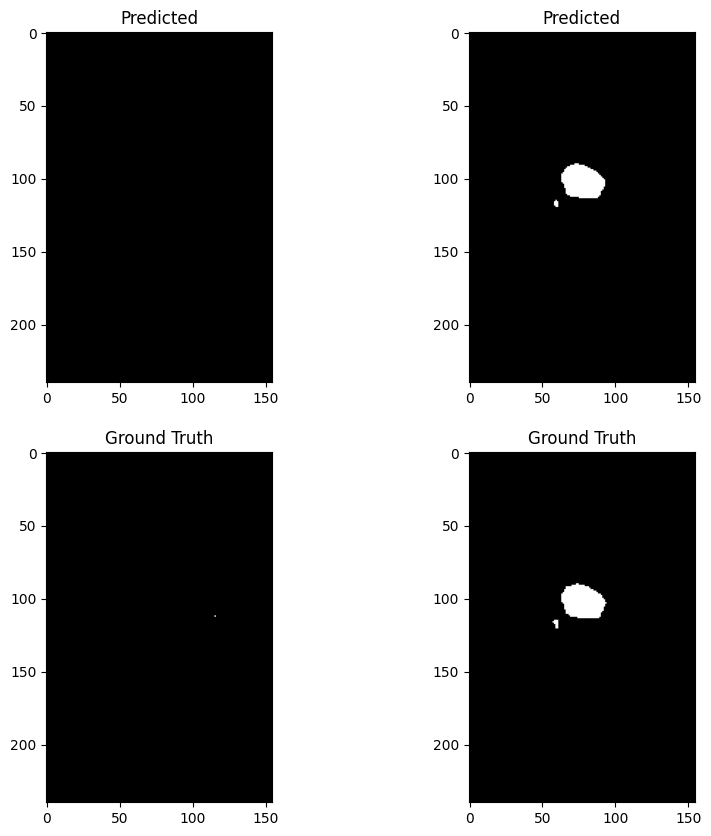

100%|██████████| 48/48 [04:31<00:00,  5.67s/it]


Average Validation Loss: 0.010624434469112506

Average Validation DSC: [0.99919884 0.90670501 0.94198772 0.7900865 ]
Average Validation ASSD: [ 0.07707302 14.47298365  9.38284507 24.24706575]
Epoch 78/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


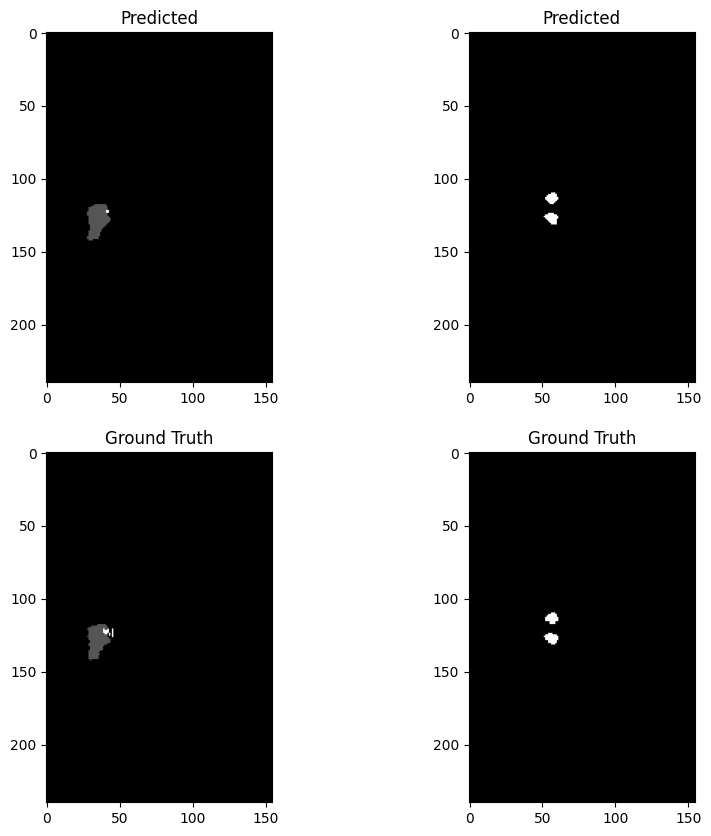

100%|██████████| 189/189 [18:33<00:00,  5.89s/it]



Average Training Loss: 0.005041109141770494

Average Training DSC: [0.99943019 0.94488165 0.95818888 0.84277669]
Average Training ASSD: [ 0.05344397  4.5552746   6.07883848 18.05599232]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


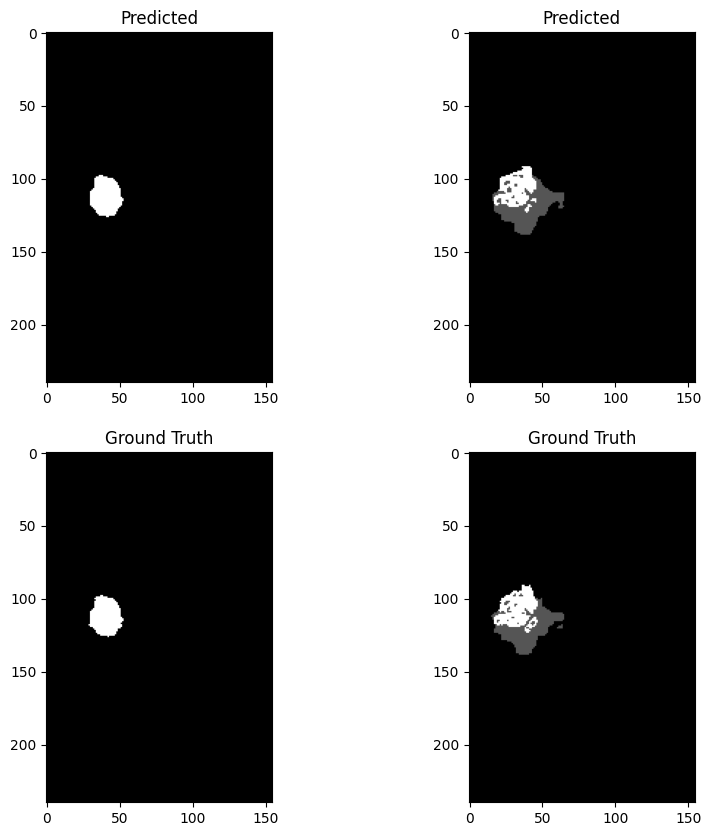

100%|██████████| 48/48 [04:28<00:00,  5.59s/it]


Average Validation Loss: 0.01123528098105453

Average Validation DSC: [0.99910006 0.89624235 0.93987552 0.77861639]
Average Validation ASSD: [ 0.08261552 17.79494564  9.31651447 23.63231416]
Epoch 79/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


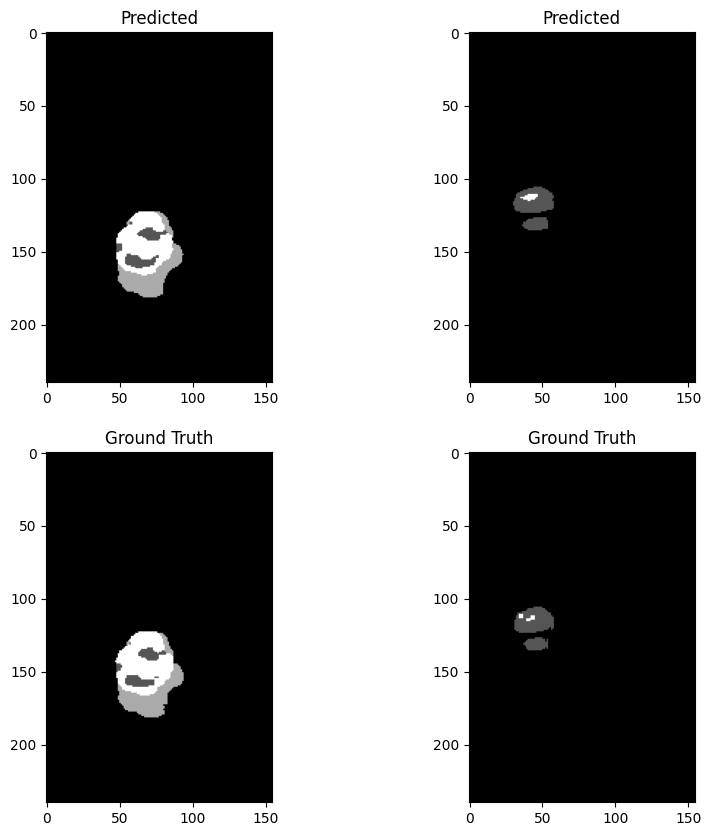

100%|██████████| 189/189 [19:03<00:00,  6.05s/it]



Average Training Loss: 0.0056931310118959536

Average Training DSC: [0.99934839 0.93079967 0.95235111 0.83087284]
Average Training ASSD: [ 0.06335663  8.23586598  7.50111959 19.18452814]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


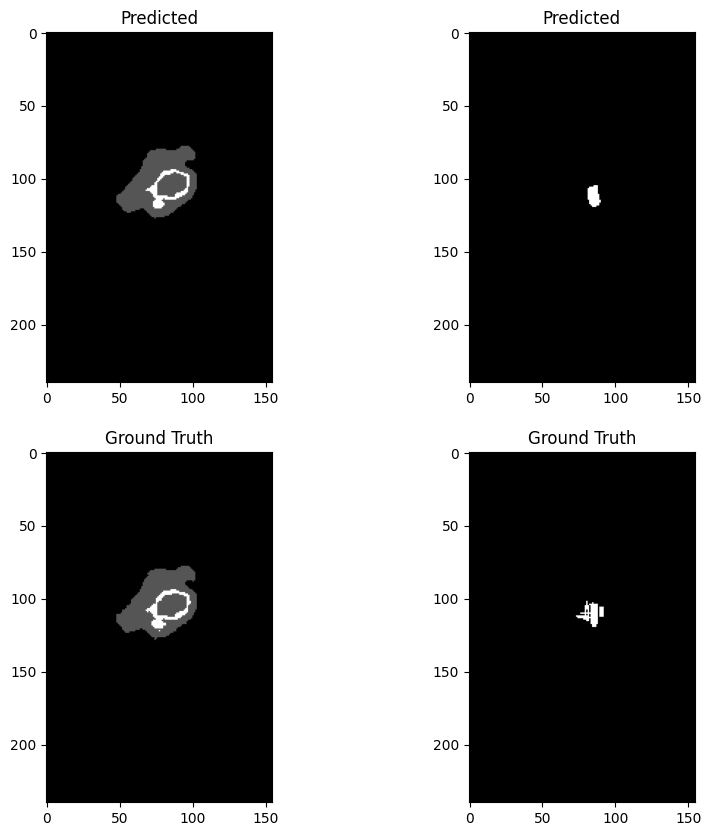

100%|██████████| 48/48 [04:33<00:00,  5.71s/it]


Average Validation Loss: 0.009673906742439916

Average Validation DSC: [0.99922875 0.90308837 0.9452542  0.80348046]
Average Validation ASSD: [ 0.07584269 17.03821993  7.96950415 21.65777153]
Epoch 80/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


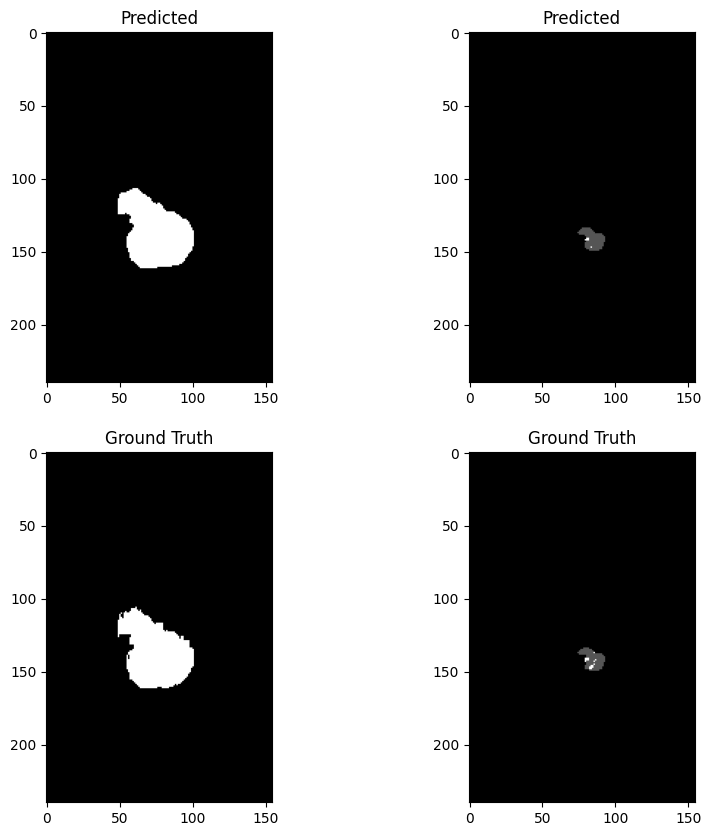

100%|██████████| 189/189 [19:02<00:00,  6.04s/it]



Average Training Loss: 0.004514501257627098

Average Training DSC: [0.99948738 0.94898533 0.95985112 0.85389402]
Average Training ASSD: [ 0.04712746  4.47594532  5.92414717 18.48528847]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


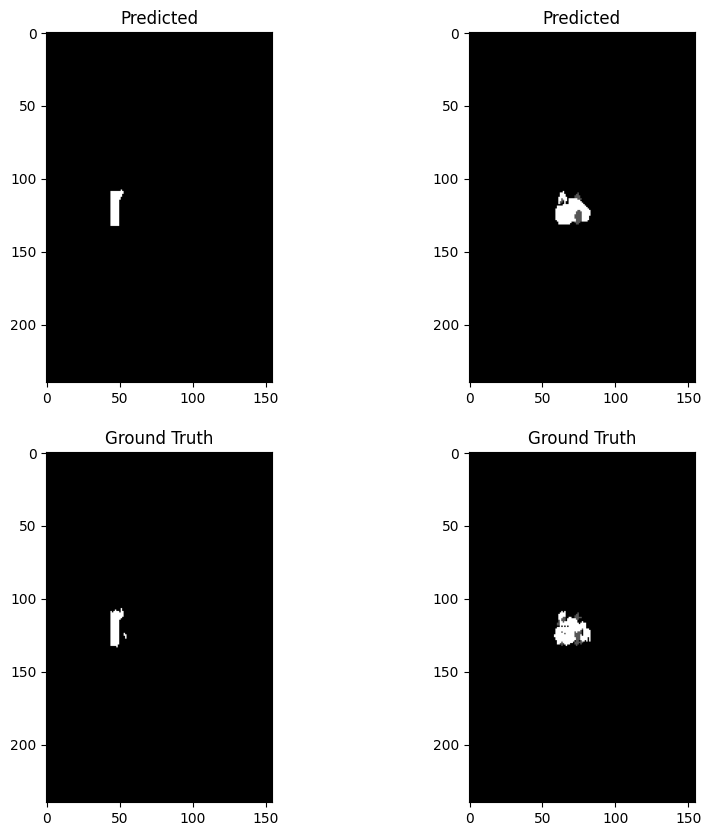

100%|██████████| 48/48 [04:30<00:00,  5.64s/it]


Average Validation Loss: 0.009405422460986301

Average Validation DSC: [0.99923335 0.92286989 0.94250839 0.82488886]
Average Validation ASSD: [ 0.07405044 11.34920204  9.85859275 15.97301561]
Epoch 81/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


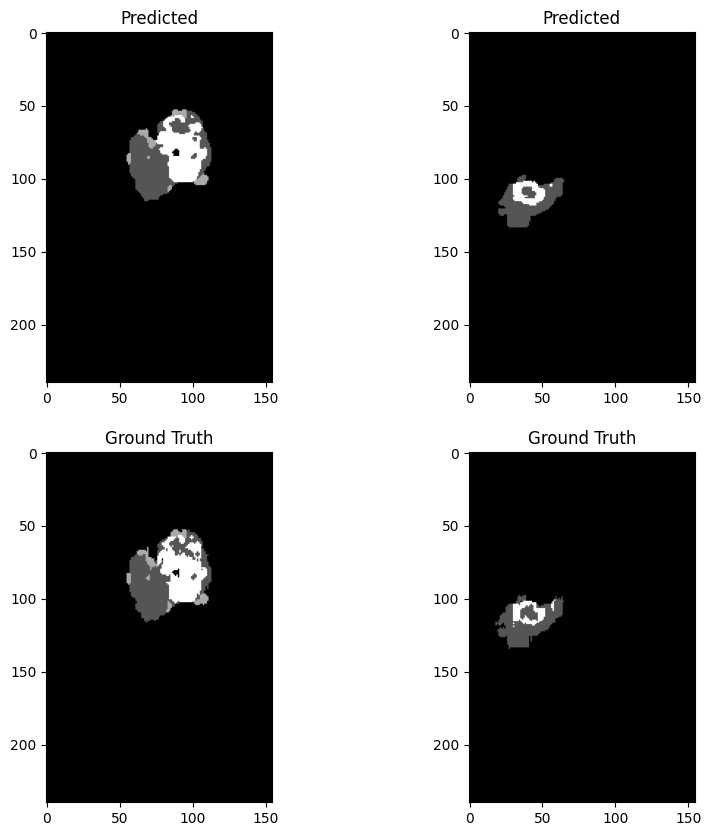

100%|██████████| 189/189 [19:12<00:00,  6.10s/it]



Average Training Loss: 0.00409984067525892

Average Training DSC: [0.99953308 0.95641327 0.96347649 0.86470344]
Average Training ASSD: [ 0.04167188  2.71760887  5.38479565 16.24460803]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


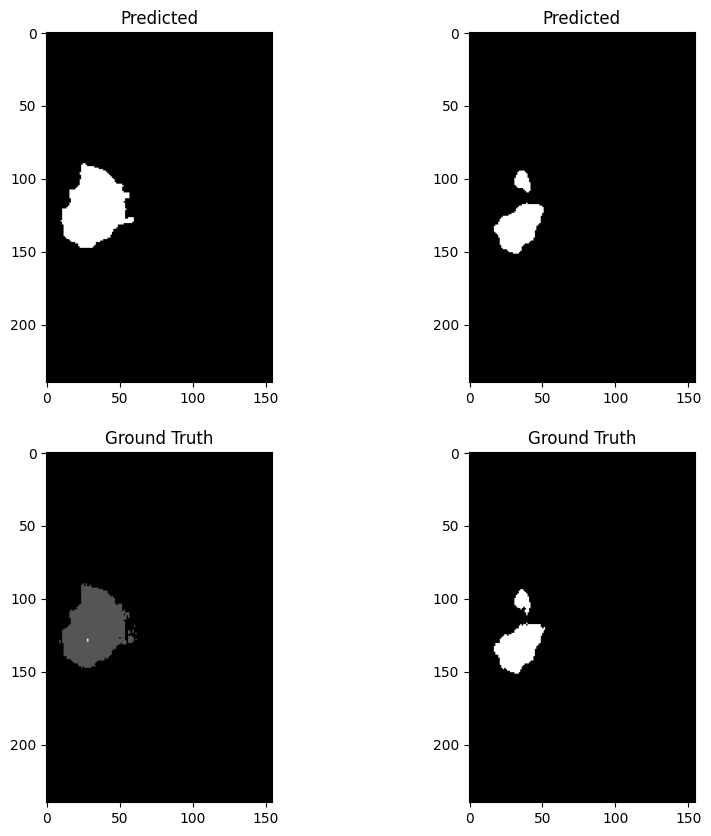

100%|██████████| 48/48 [04:34<00:00,  5.72s/it]


Average Validation Loss: 0.009894625686380701

Average Validation DSC: [0.99927239 0.92074266 0.9451643  0.83031141]
Average Validation ASSD: [ 0.0671316  11.72037623  9.28946104 15.50946798]
Epoch 82/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


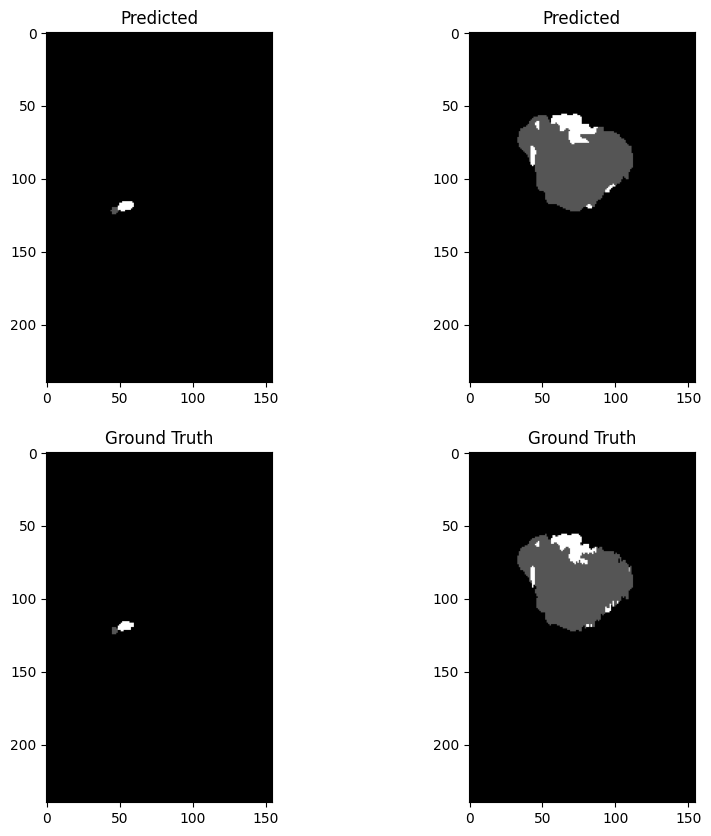

100%|██████████| 189/189 [19:30<00:00,  6.19s/it]



Average Training Loss: 0.003950582350303651

Average Training DSC: [0.99955192 0.95892696 0.96364901 0.86969094]
Average Training ASSD: [ 0.03931068  2.22953825  5.61019239 16.98326503]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


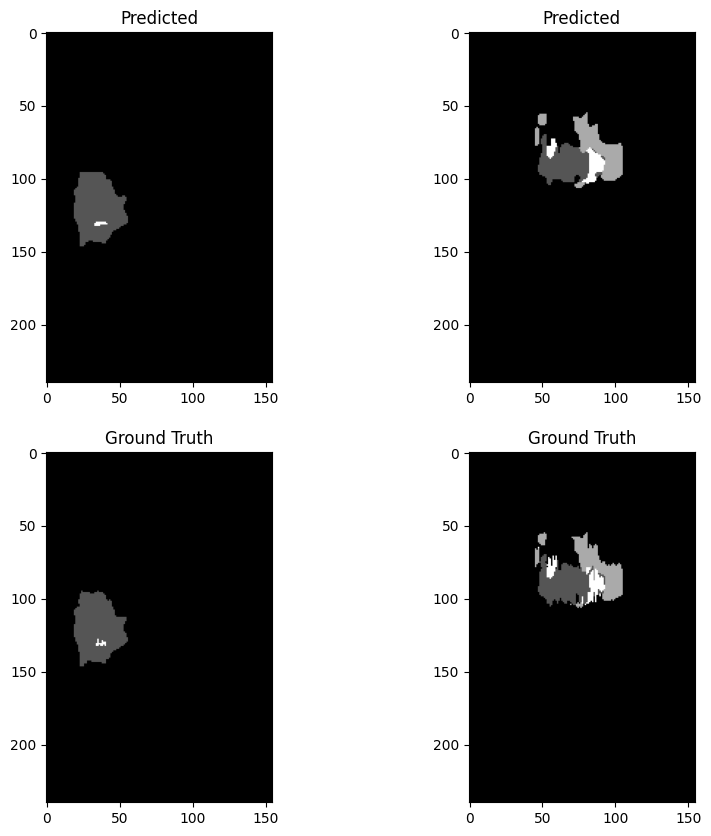

100%|██████████| 48/48 [04:10<00:00,  5.21s/it]


Average Validation Loss: 0.009811174667750796

Average Validation DSC: [0.99928461 0.92510453 0.94571224 0.83497481]
Average Validation ASSD: [ 0.06509588 10.63768447  8.42932948 14.43964708]
Epoch 83/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


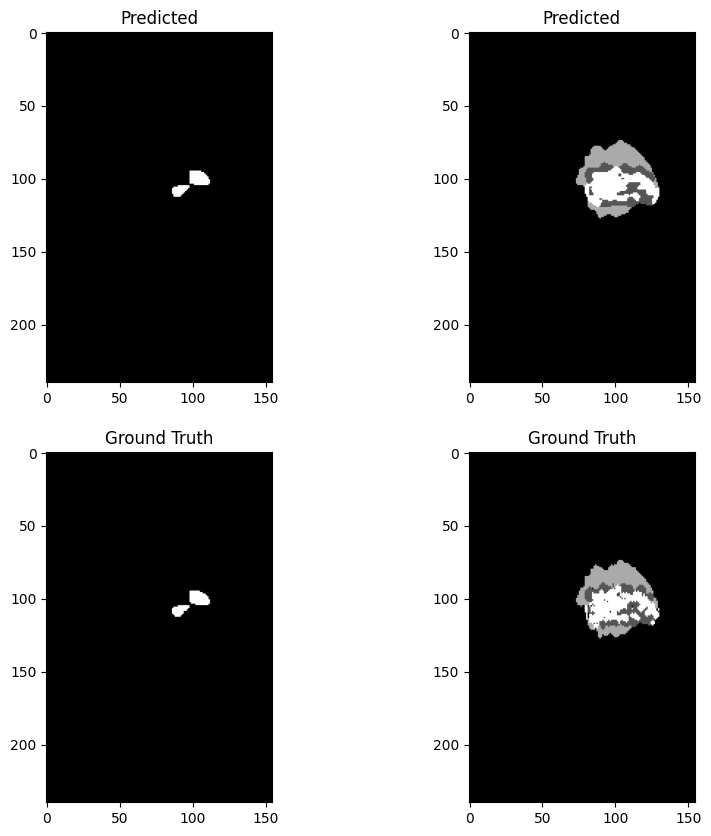

100%|██████████| 189/189 [08:44<00:00,  2.78s/it]



Average Training Loss: 0.003942958147033418

Average Training DSC: [0.99954667 0.95880709 0.96503534 0.87025866]
Average Training ASSD: [ 0.04038863  2.28781402  4.96015404 16.22207187]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


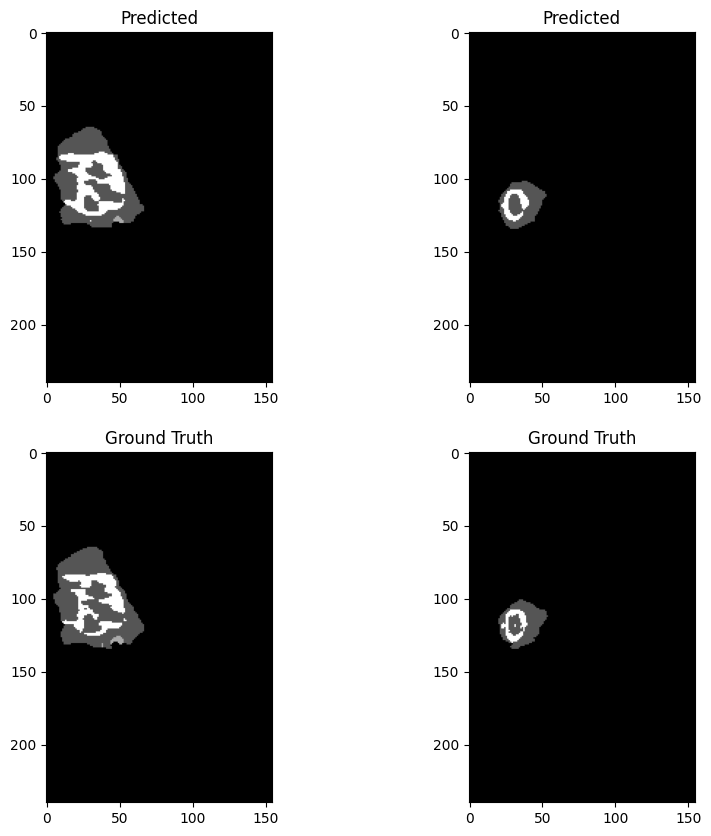

100%|██████████| 48/48 [01:06<00:00,  1.38s/it]


Average Validation Loss: 0.009835321829693081

Average Validation DSC: [0.99930136 0.9243285  0.94531861 0.84021951]
Average Validation ASSD: [ 0.06321335 10.39665776  8.80231185 12.66537315]
Epoch 84/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


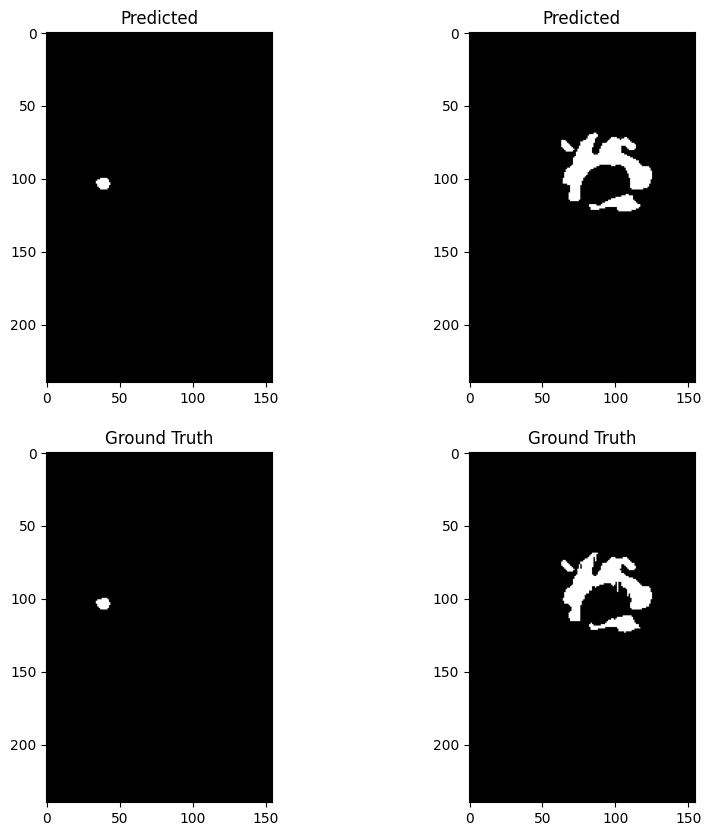

100%|██████████| 189/189 [05:08<00:00,  1.63s/it]



Average Training Loss: 0.00398017942570347

Average Training DSC: [0.99954516 0.95749682 0.96416051 0.86995888]
Average Training ASSD: [ 0.04059838  2.35225208  5.1889977  16.21747527]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


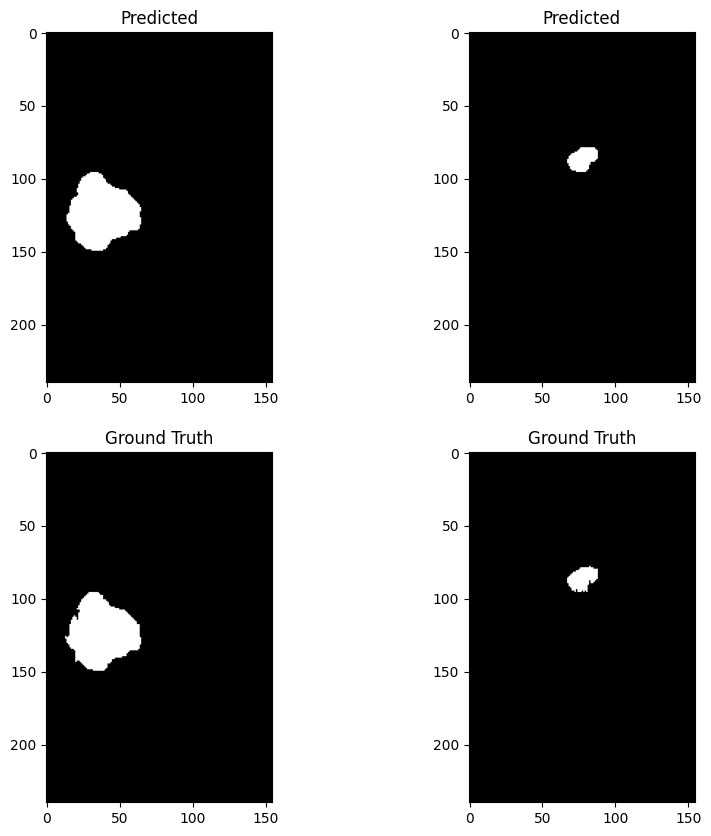

100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


Average Validation Loss: 0.009761332214111462

Average Validation DSC: [0.99929783 0.9215363  0.94244351 0.83827579]
Average Validation ASSD: [ 0.06090846 11.94227865  8.70113392 12.15300616]
Epoch 85/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


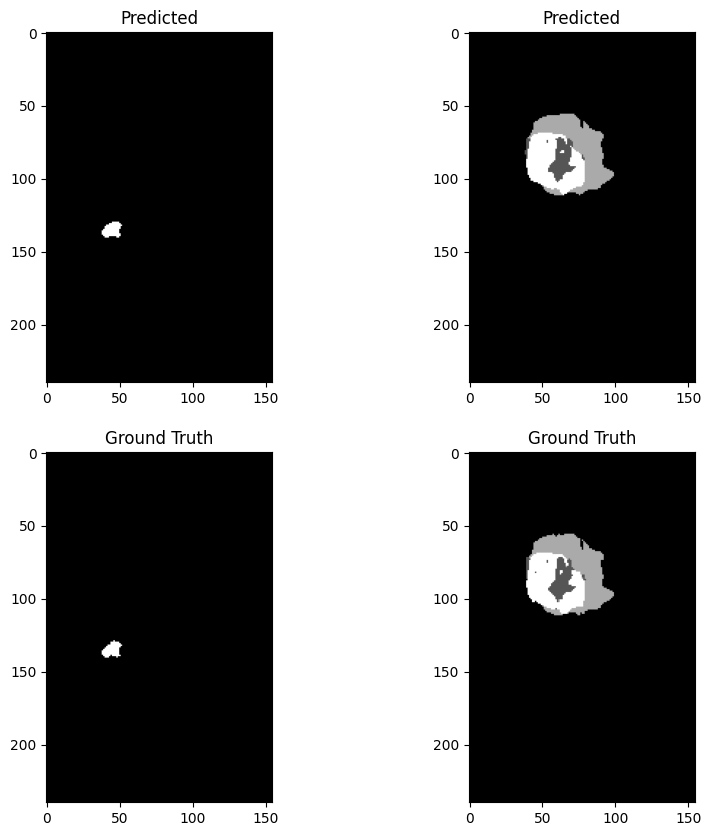

100%|██████████| 189/189 [05:08<00:00,  1.63s/it]



Average Training Loss: 0.003859868052627438

Average Training DSC: [0.9995608  0.95910715 0.96375911 0.87371326]
Average Training ASSD: [ 0.03873902  2.46504092  5.31776696 15.3577127 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


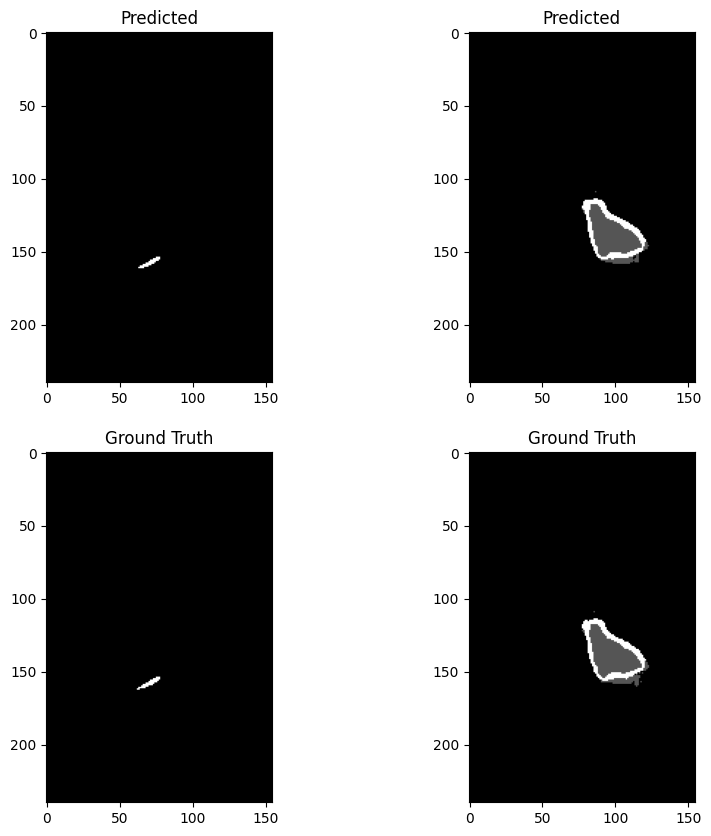

100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Average Validation Loss: 0.009952798602171242

Average Validation DSC: [0.99930298 0.92318679 0.94536933 0.83962248]
Average Validation ASSD: [ 0.06366867 10.40789452  8.67977267 13.57203967]
Epoch 86/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


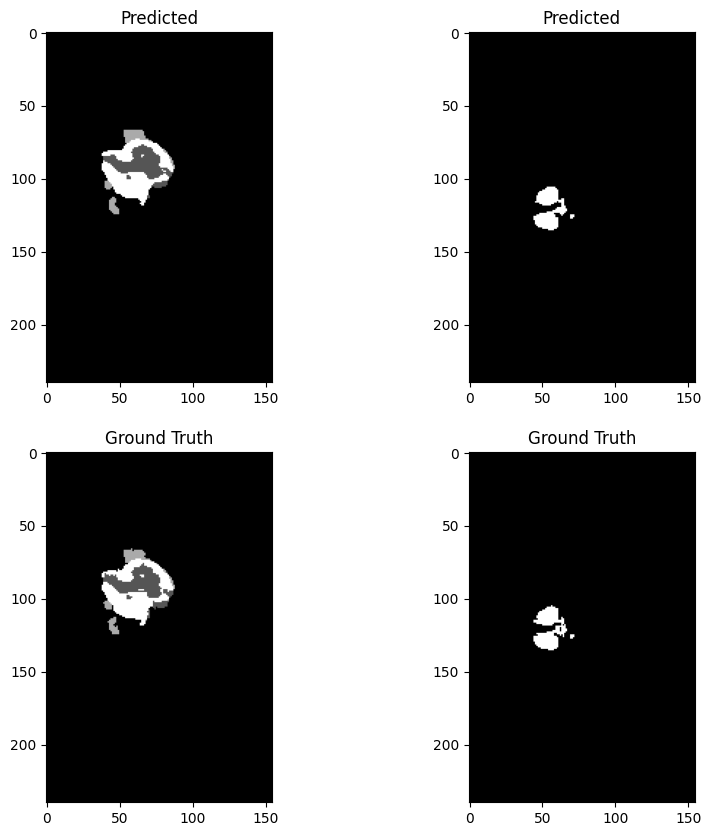

100%|██████████| 189/189 [05:13<00:00,  1.66s/it]



Average Training Loss: 0.003745986340892693

Average Training DSC: [0.99957444 0.96050662 0.9653782  0.87699976]
Average Training ASSD: [ 0.03673015  2.27656743  5.24407861 14.27872438]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


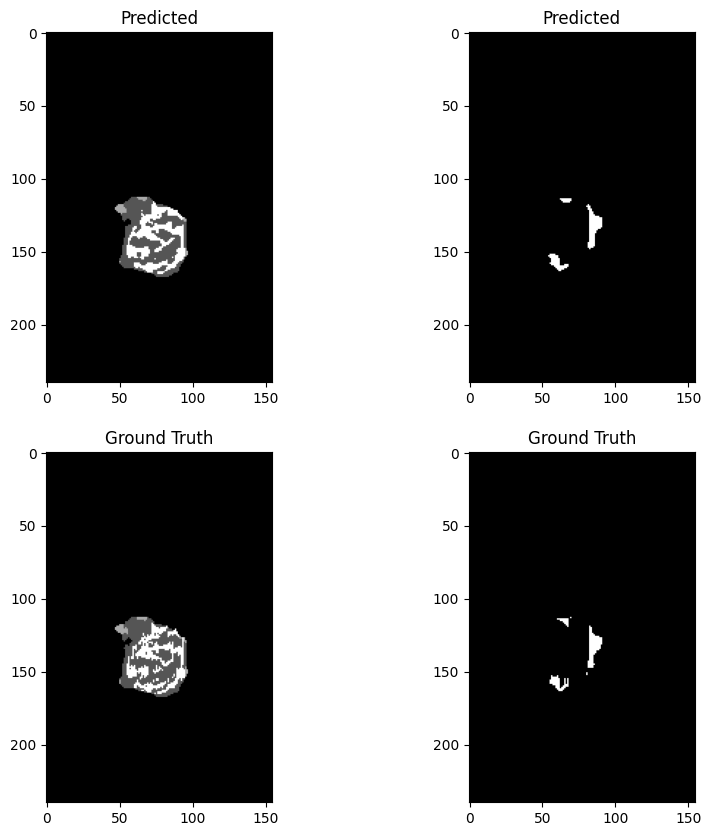

100%|██████████| 48/48 [01:07<00:00,  1.40s/it]


Average Validation Loss: 0.009905453587028509

Average Validation DSC: [0.99930954 0.92325776 0.94655655 0.8433204 ]
Average Validation ASSD: [ 0.06167492 11.33527766  8.50153455 10.30000644]
Epoch 87/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


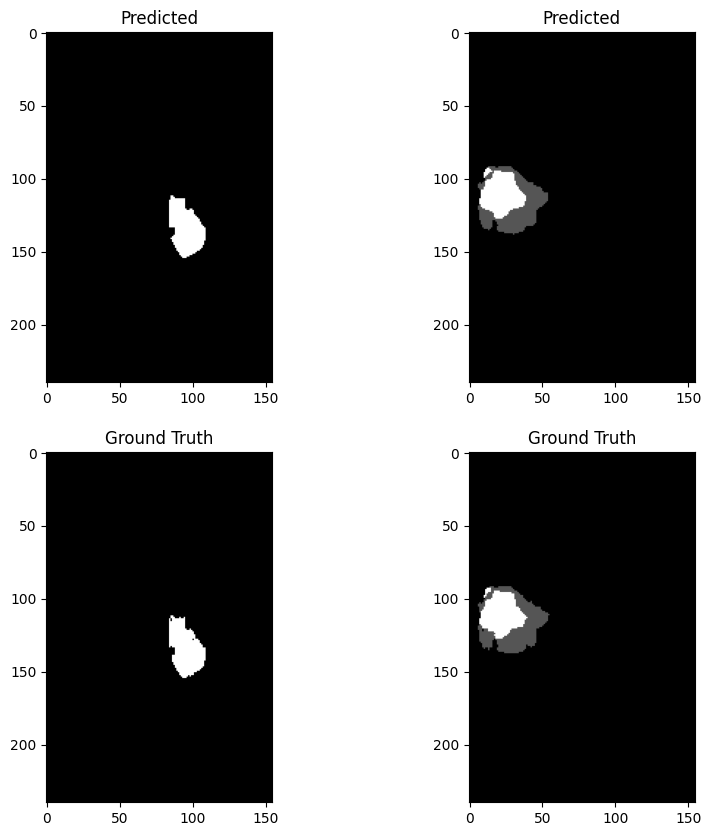

100%|██████████| 189/189 [05:08<00:00,  1.63s/it]



Average Training Loss: 0.0037574243482951294

Average Training DSC: [0.99957171 0.95945242 0.9652936  0.87670679]
Average Training ASSD: [ 0.03749805  2.51895237  4.82916209 15.0550886 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


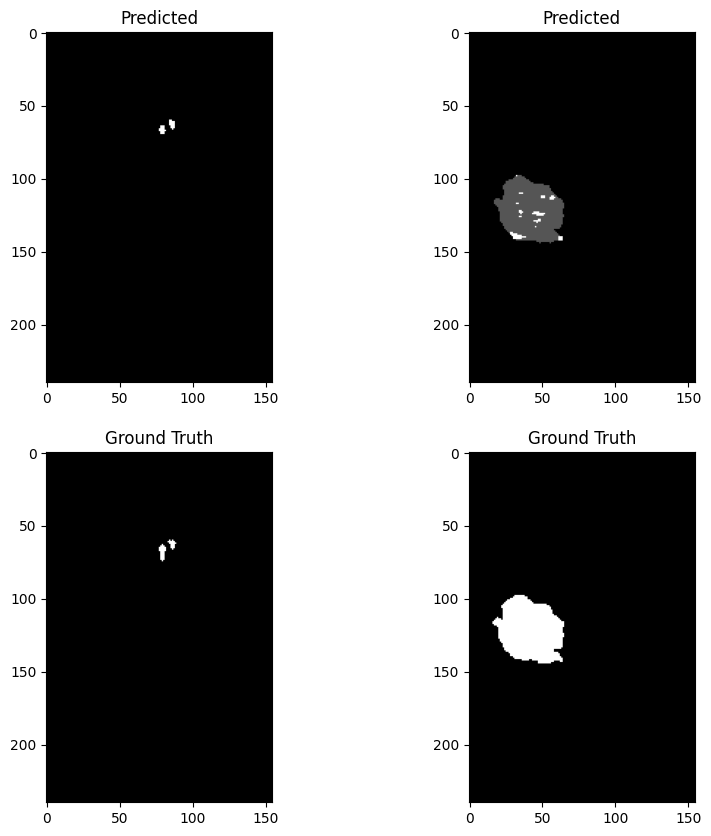

100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


Average Validation Loss: 0.010187922617963826

Average Validation DSC: [0.99927354 0.92140658 0.94751301 0.8362926 ]
Average Validation ASSD: [ 0.06622737 11.70934884  7.97216521 14.53231503]
Epoch 88/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


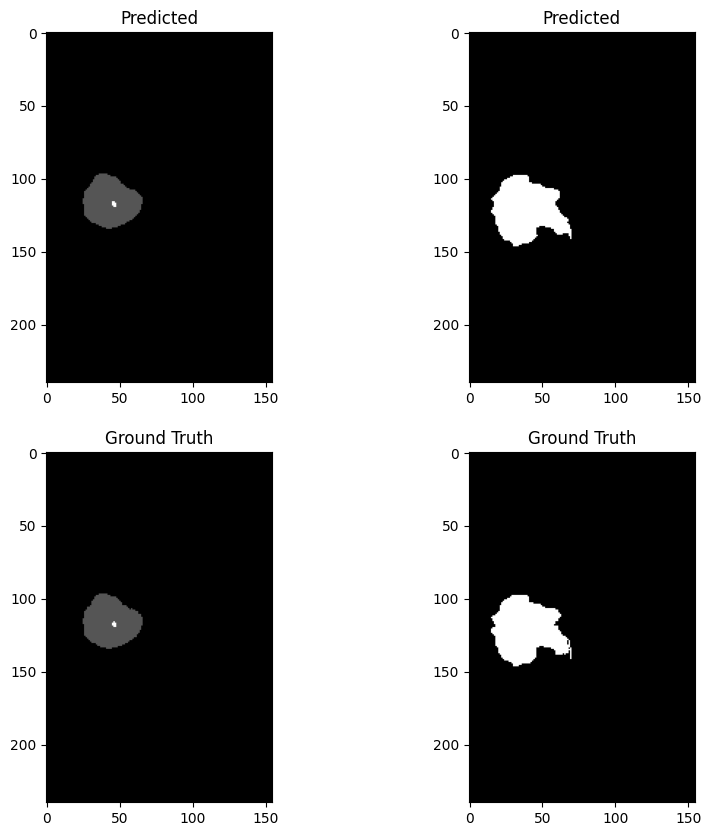

100%|██████████| 189/189 [05:08<00:00,  1.63s/it]



Average Training Loss: 0.003725005193643035

Average Training DSC: [0.99957041 0.96019147 0.96489896 0.8791159 ]
Average Training ASSD: [ 0.03735117  2.39827036  4.89018829 14.32669451]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


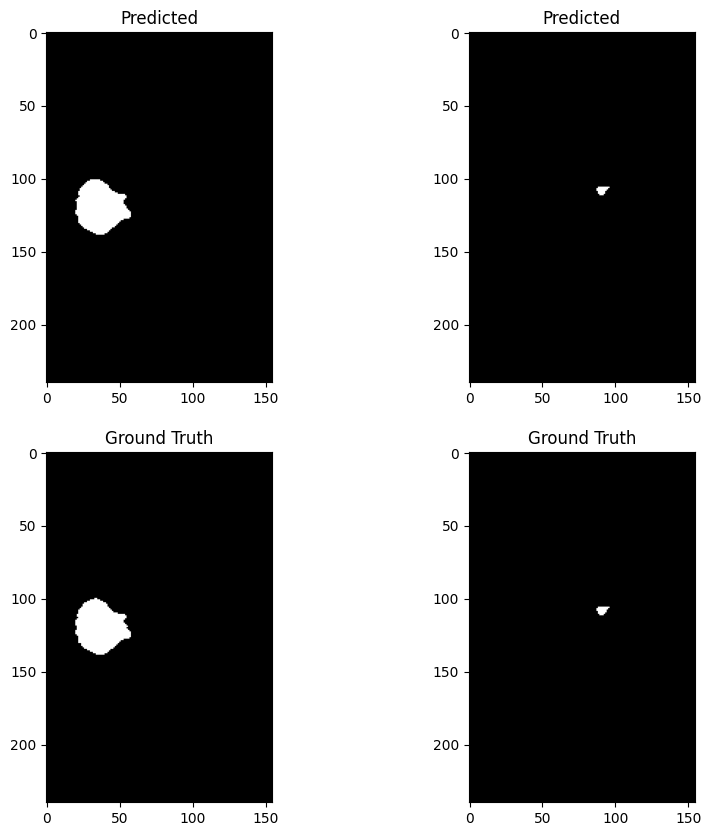

100%|██████████| 48/48 [01:07<00:00,  1.41s/it]


Average Validation Loss: 0.009965533861153139

Average Validation DSC: [0.999313   0.92242947 0.95098109 0.83731776]
Average Validation ASSD: [ 0.0636005  11.94201892  7.2420855  14.17415092]
Epoch 89/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


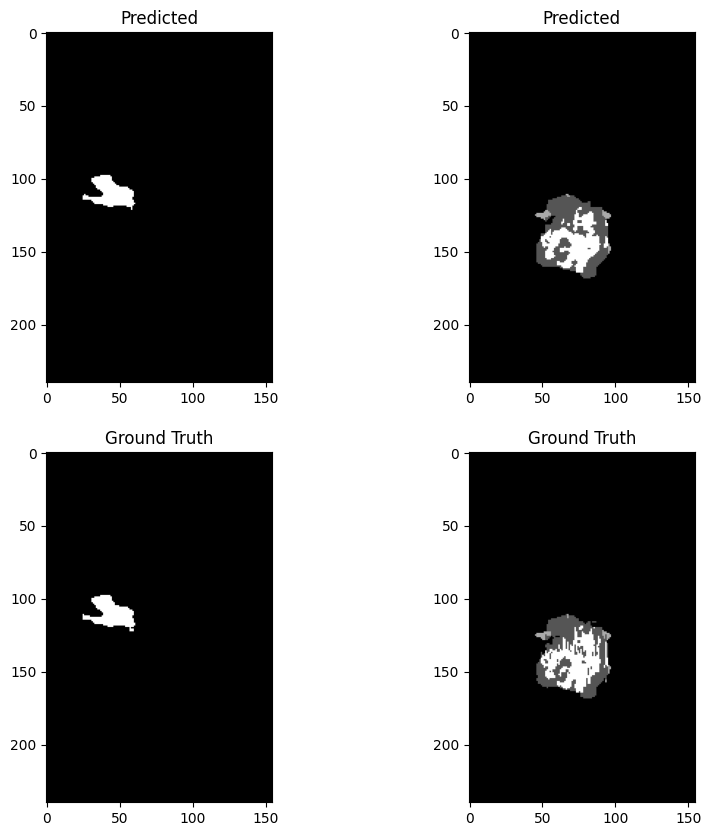

100%|██████████| 189/189 [05:12<00:00,  1.65s/it]



Average Training Loss: 0.0036750340787447475

Average Training DSC: [0.99958018 0.9599045  0.96535007 0.87965968]
Average Training ASSD: [ 0.0369174   2.57465528  4.88731477 14.44835747]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


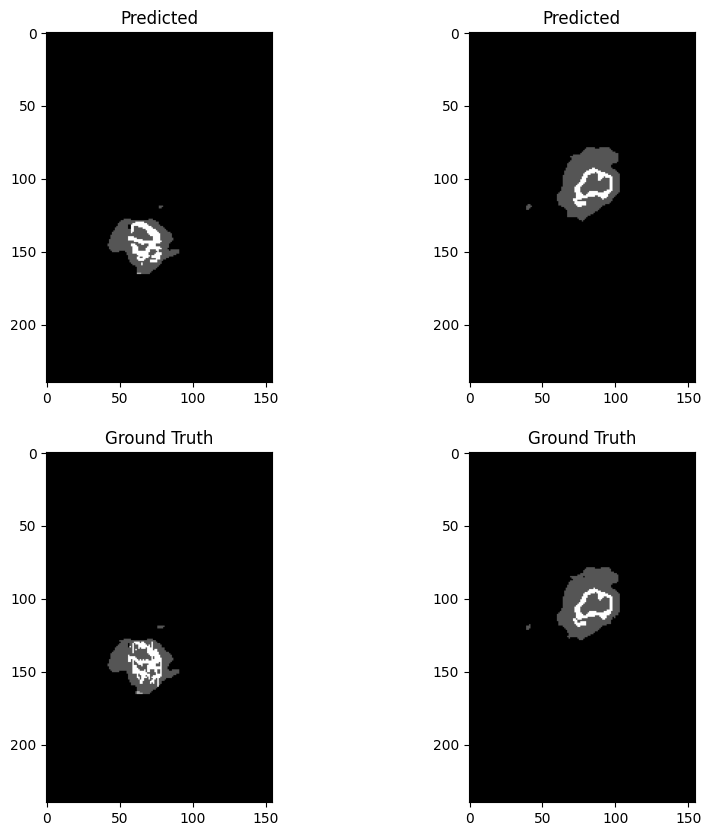

100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


Average Validation Loss: 0.0099397875504413

Average Validation DSC: [0.99930851 0.92204744 0.94617306 0.84362962]
Average Validation ASSD: [ 0.06152543 12.40779415  8.80159804 11.73492636]
Epoch 90/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


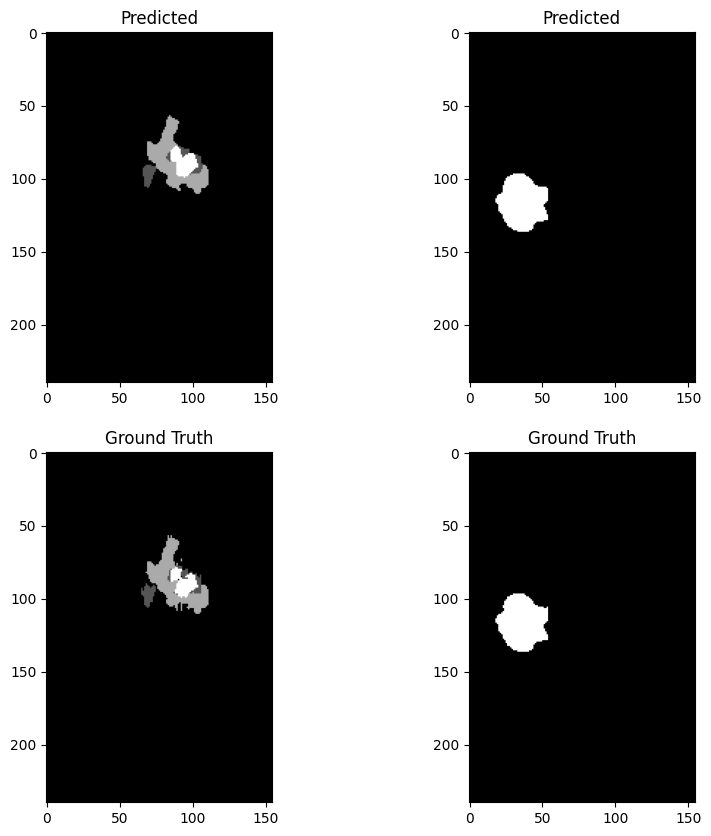

100%|██████████| 189/189 [05:10<00:00,  1.64s/it]



Average Training Loss: 0.0036372077175805336

Average Training DSC: [0.99958431 0.96128335 0.9663404  0.88165085]
Average Training ASSD: [ 0.03589717  2.27249665  4.99877373 13.9759391 ]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


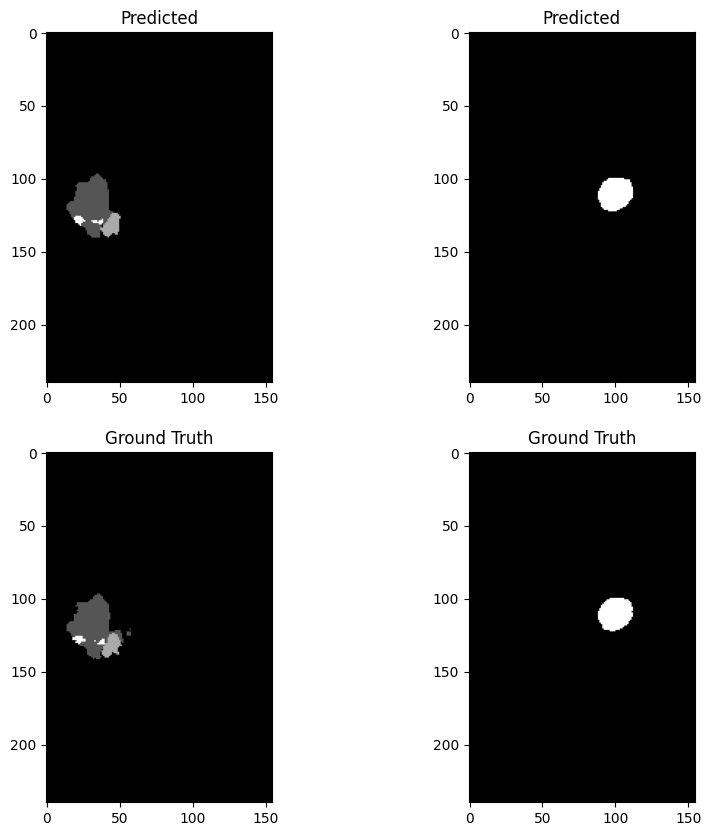

100%|██████████| 48/48 [01:05<00:00,  1.37s/it]


Average Validation Loss: 0.01006120355547561

Average Validation DSC: [0.99932843 0.92643285 0.94815509 0.84587856]
Average Validation ASSD: [ 0.06215371 10.62602161  8.41768695 12.88362955]
Epoch 91/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


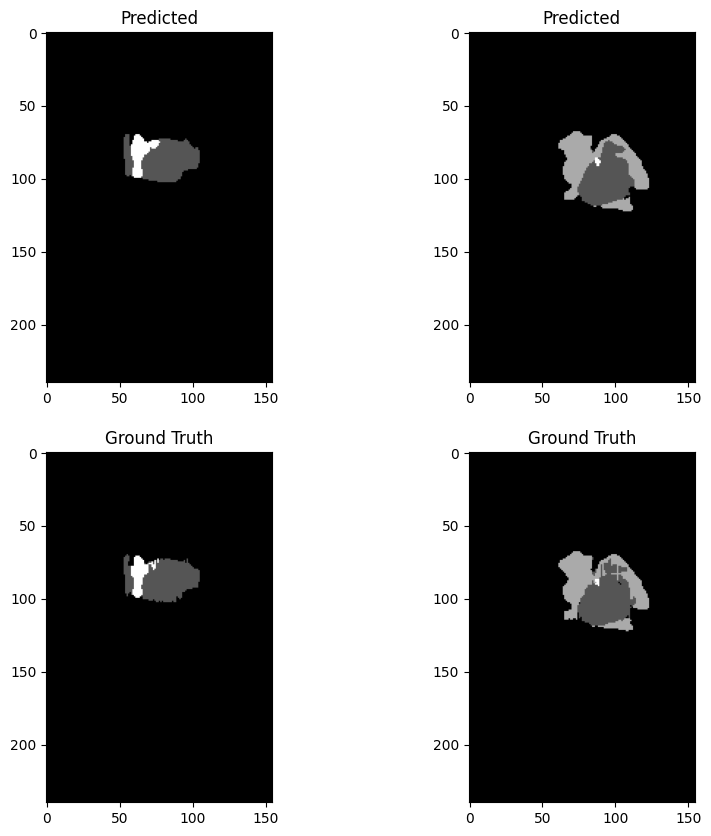

100%|██████████| 189/189 [05:06<00:00,  1.62s/it]



Average Training Loss: 0.003521542630291411

Average Training DSC: [0.99959835 0.96168032 0.96734345 0.88426166]
Average Training ASSD: [ 0.03464916  2.33045517  4.5226392  13.89739109]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


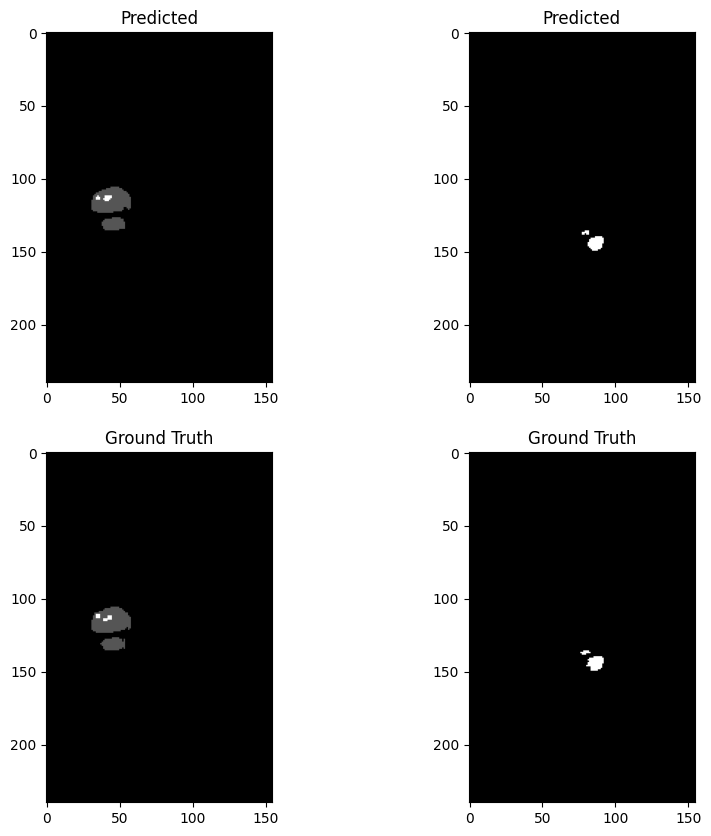

100%|██████████| 48/48 [01:02<00:00,  1.29s/it]


Average Validation Loss: 0.010333372357611855

Average Validation DSC: [0.99934061 0.92754213 0.94557155 0.84766041]
Average Validation ASSD: [ 0.05895394 10.8511219  10.0449739  10.99501519]
Epoch 92/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


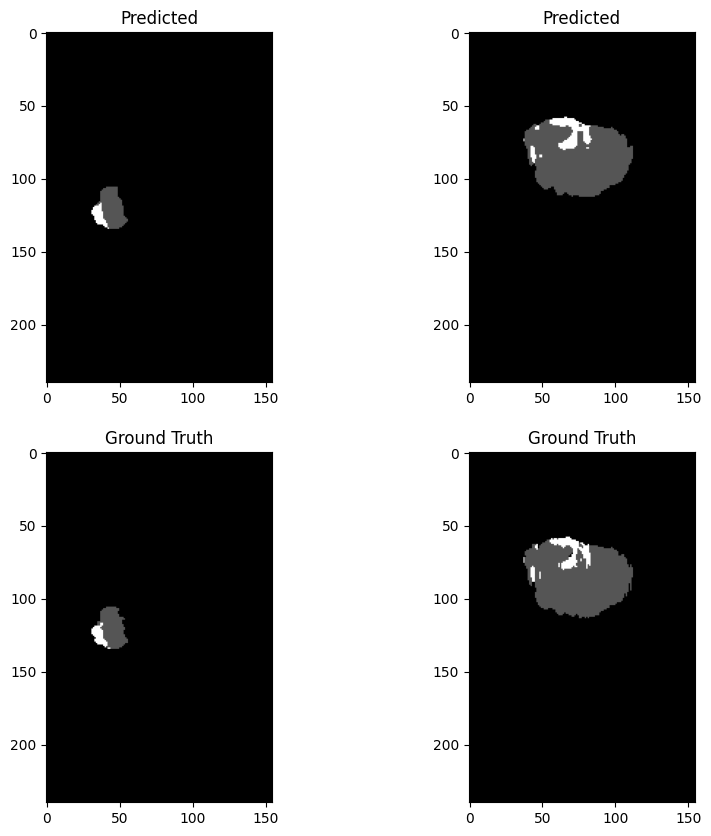

100%|██████████| 189/189 [04:50<00:00,  1.54s/it]



Average Training Loss: 0.0035198306099378635

Average Training DSC: [0.9996021  0.96248162 0.96592684 0.88653067]
Average Training ASSD: [ 0.03396993  2.08875526  5.17865947 12.53192365]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


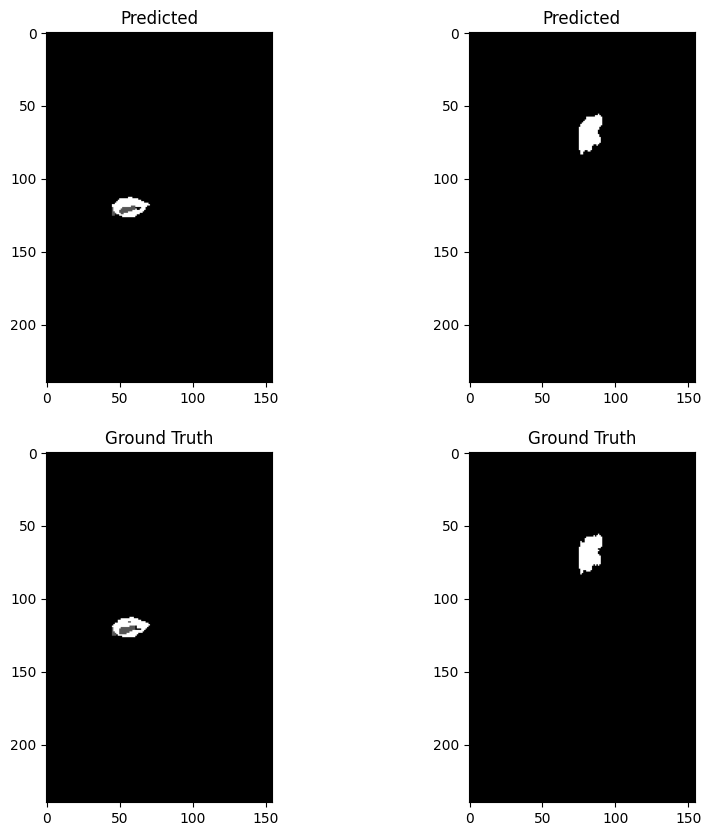

100%|██████████| 48/48 [01:02<00:00,  1.29s/it]


Average Validation Loss: 0.010003403382143006

Average Validation DSC: [0.99934281 0.92186816 0.95008405 0.84657762]
Average Validation ASSD: [ 0.06055302 12.86583125  8.18040633 11.7206746 ]
Epoch 93/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


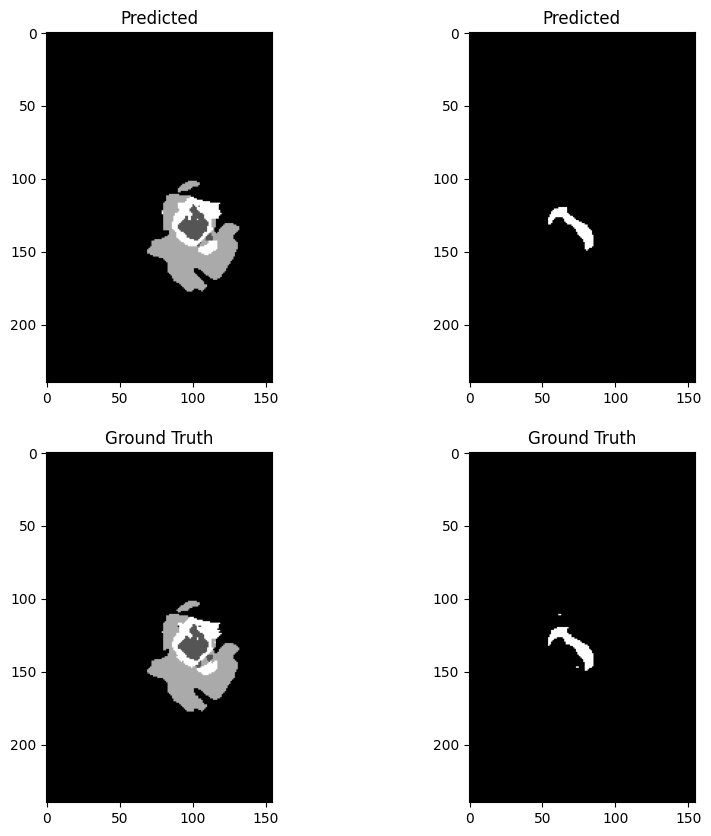

100%|██████████| 189/189 [04:49<00:00,  1.53s/it]



Average Training Loss: 0.003512965036043651

Average Training DSC: [0.99959728 0.96230031 0.96751804 0.88529422]
Average Training ASSD: [ 0.03483682  2.3843055   4.63795741 13.53469656]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


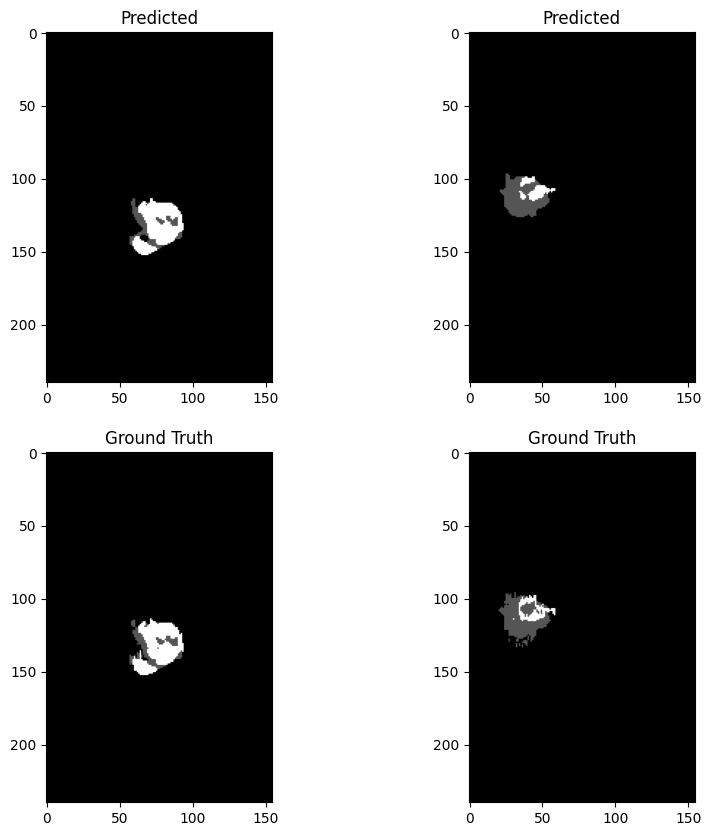

100%|██████████| 48/48 [01:02<00:00,  1.31s/it]


Average Validation Loss: 0.01005362545644554

Average Validation DSC: [0.99935402 0.92429749 0.95075404 0.84673959]
Average Validation ASSD: [ 0.05983088 12.39013889  7.25192352 12.32256918]
Epoch 94/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


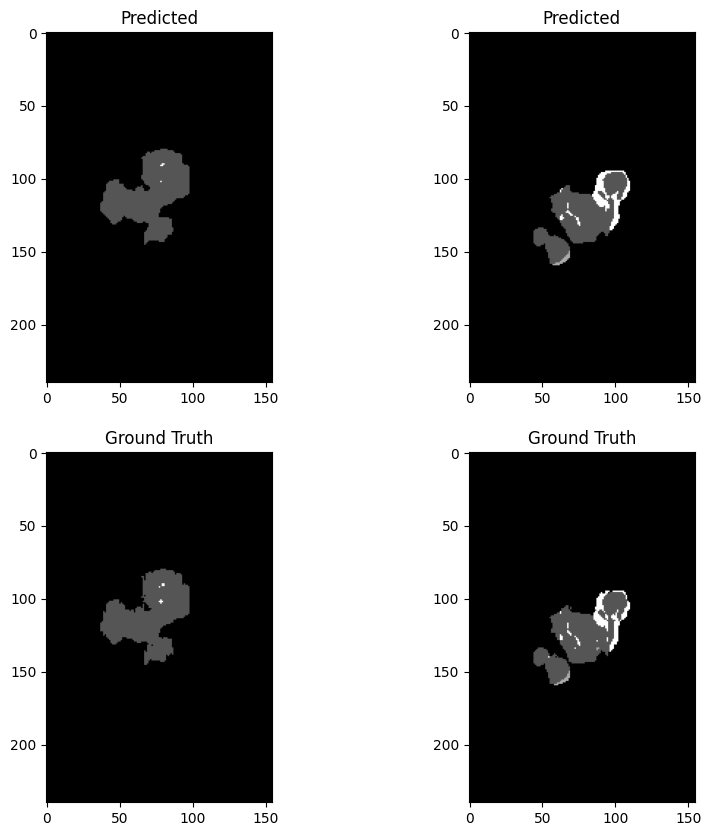

100%|██████████| 189/189 [04:53<00:00,  1.55s/it]



Average Training Loss: 0.0033862964797114568

Average Training DSC: [0.99960874 0.96378916 0.96944692 0.89061933]
Average Training ASSD: [ 0.03342212  2.14167979  4.16890918 12.56069808]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


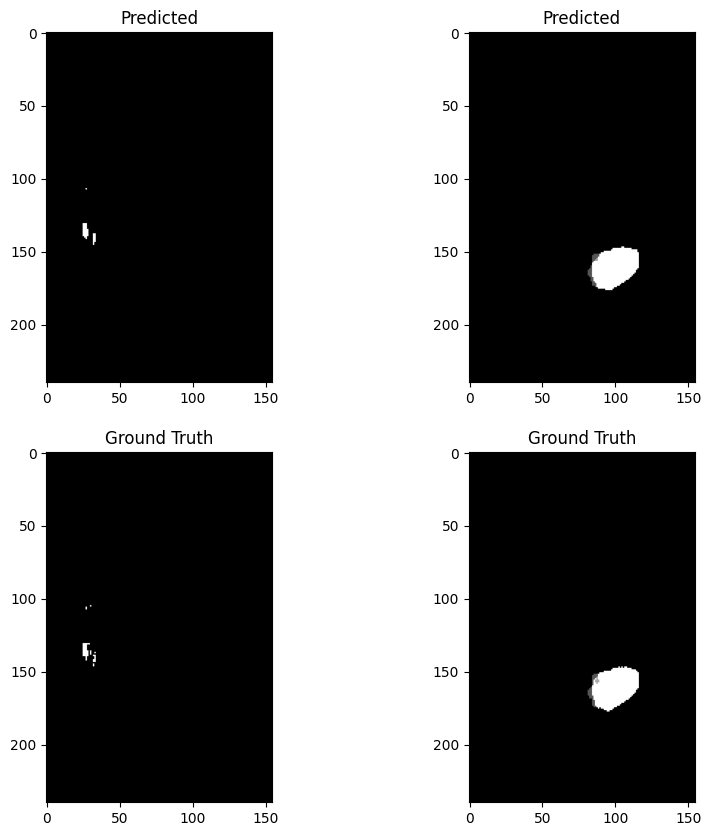

100%|██████████| 48/48 [01:02<00:00,  1.30s/it]


Average Validation Loss: 0.011222716488797838

Average Validation DSC: [0.9993107  0.92426439 0.94885027 0.83714748]
Average Validation ASSD: [ 0.06055098 12.29637323  8.23137284 15.08182749]
Epoch 95/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


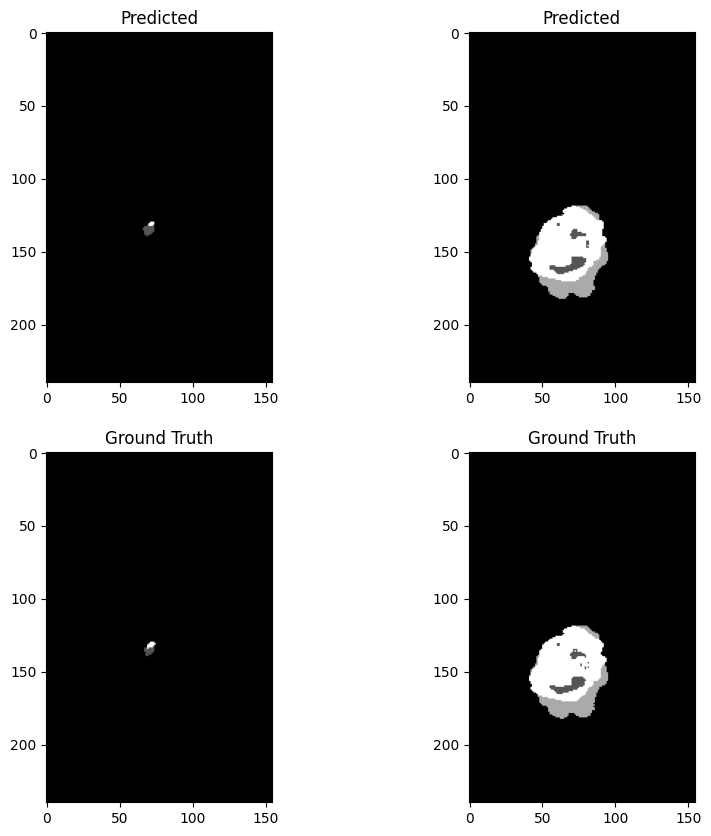

100%|██████████| 189/189 [04:51<00:00,  1.54s/it]



Average Training Loss: 0.0033249130815011328

Average Training DSC: [0.99962072 0.96401601 0.96899961 0.89120236]
Average Training ASSD: [ 0.03282882  2.31697491  4.09948665 12.21053728]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


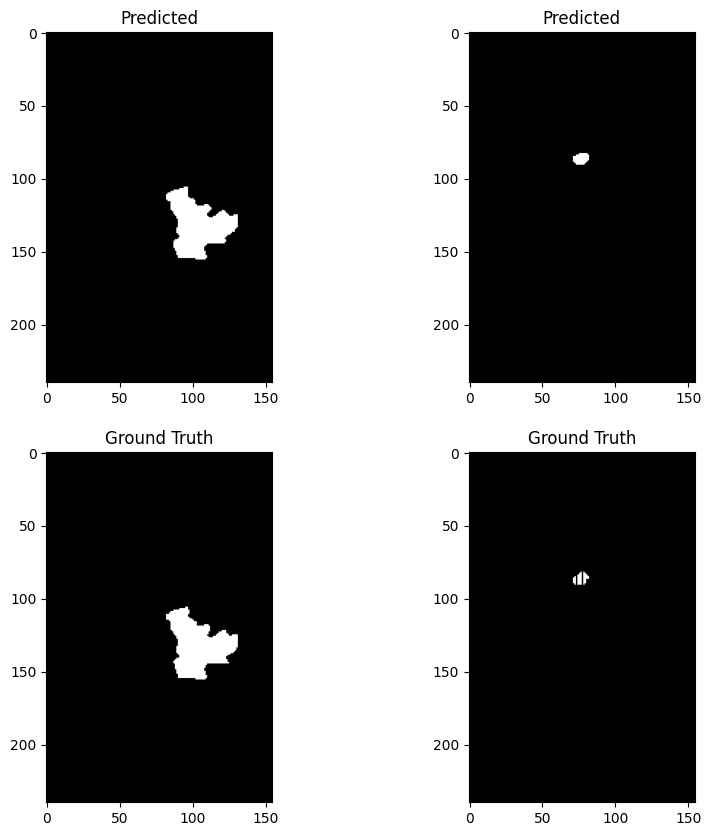

100%|██████████| 48/48 [01:02<00:00,  1.31s/it]


Average Validation Loss: 0.010722440424918508

Average Validation DSC: [0.99935129 0.9254633  0.94529085 0.82508876]
Average Validation ASSD: [ 0.06083158 11.10069144  8.87851481 18.16035685]
Epoch 96/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


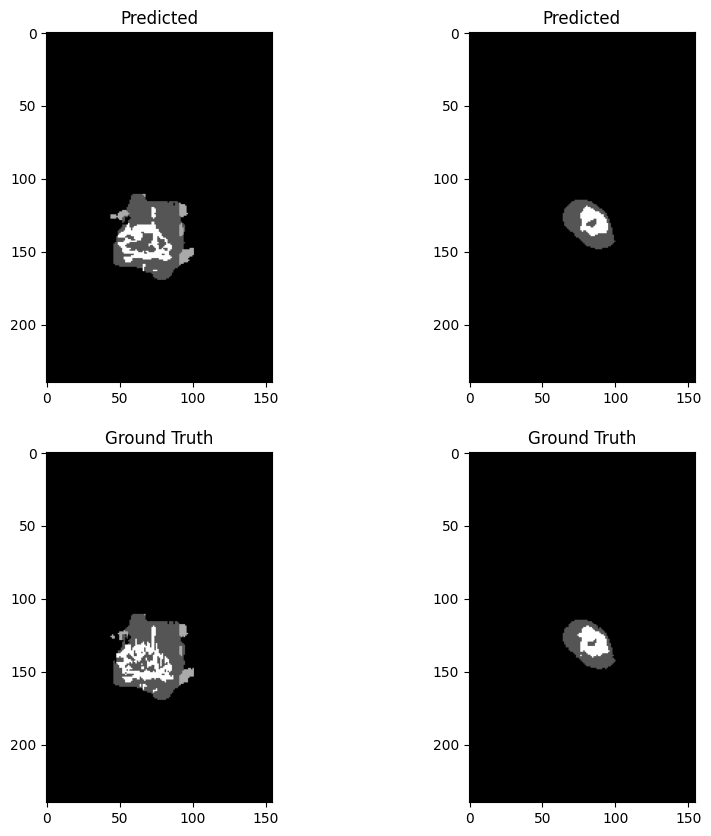

100%|██████████| 189/189 [04:52<00:00,  1.55s/it]



Average Training Loss: 0.0033067120676466004

Average Training DSC: [0.99962911 0.96391946 0.96821393 0.89254357]
Average Training ASSD: [ 0.03142553  2.13670265  4.4601845  12.26081022]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


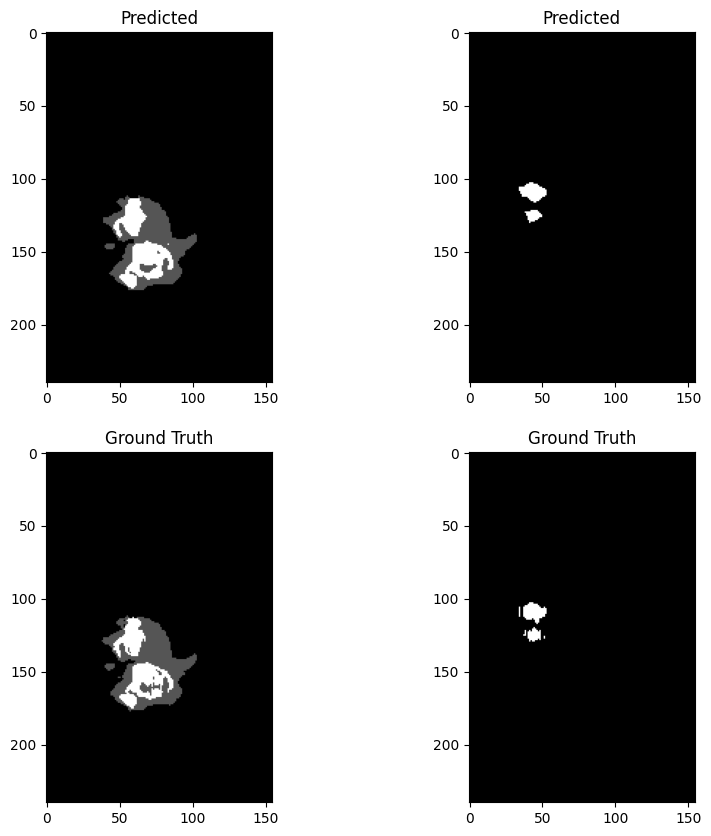

100%|██████████| 48/48 [01:02<00:00,  1.30s/it]


Average Validation Loss: 0.010196392220677808

Average Validation DSC: [0.99935501 0.92461663 0.95001855 0.84619771]
Average Validation ASSD: [ 0.05880963 12.26275074  8.18081088 11.74267948]
Epoch 97/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


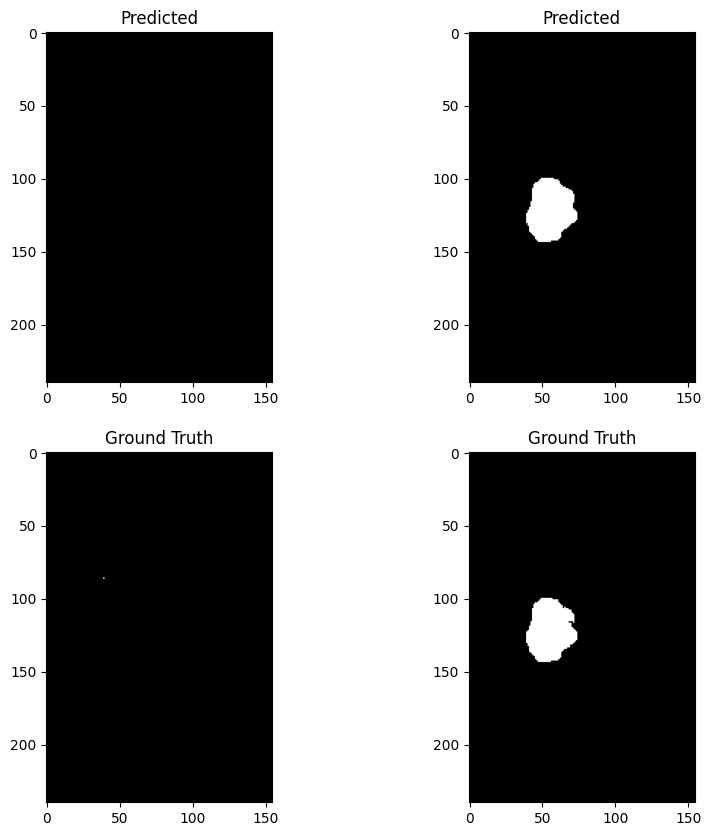

100%|██████████| 189/189 [04:52<00:00,  1.55s/it]



Average Training Loss: 0.0033062929447700896

Average Training DSC: [0.99962723 0.96383024 0.96797052 0.89250216]
Average Training ASSD: [ 0.03170406  2.20006968  4.51897135 11.72579464]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


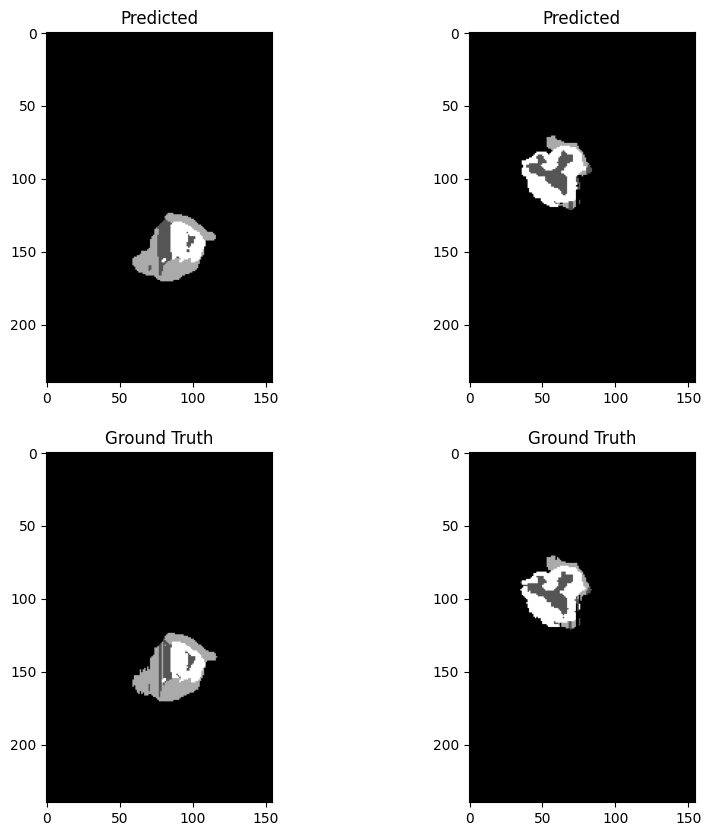

100%|██████████| 48/48 [01:02<00:00,  1.30s/it]


Average Validation Loss: 0.010289312752623422

Average Validation DSC: [0.9993513  0.92506248 0.94435732 0.84533113]
Average Validation ASSD: [ 0.05968454 11.55758179  8.93577054 12.84355641]
Epoch 98/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


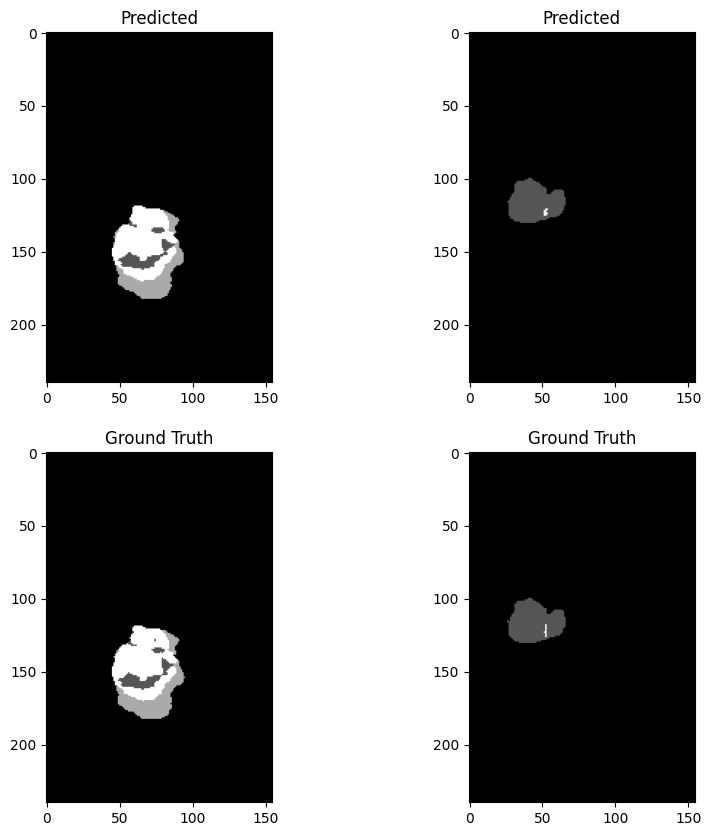

100%|██████████| 189/189 [04:50<00:00,  1.54s/it]



Average Training Loss: 0.00346051958862633

Average Training DSC: [0.99960157 0.96084298 0.96479883 0.88928066]
Average Training ASSD: [ 0.03474734  3.04068347  5.24510067 12.11573353]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


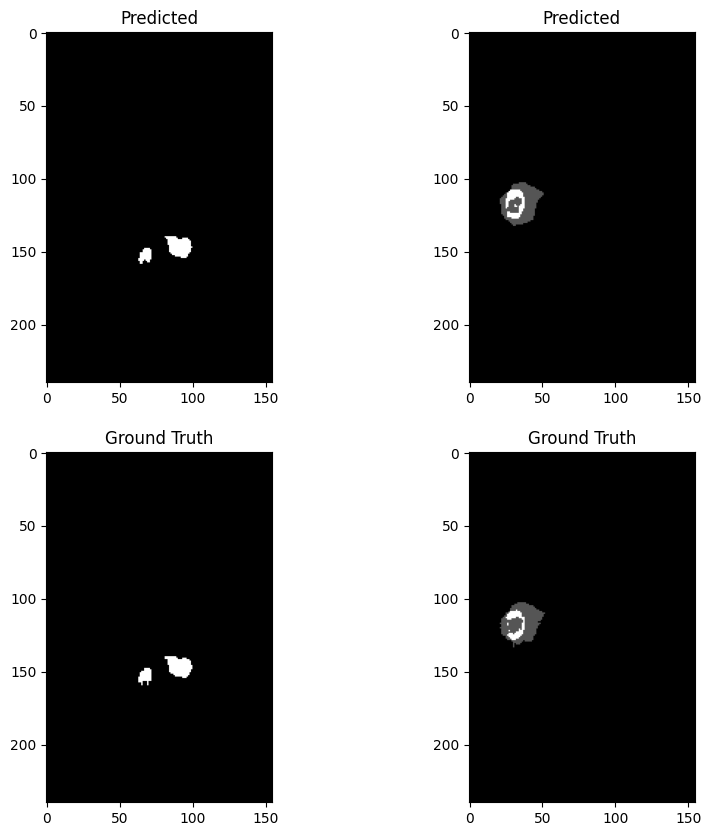

100%|██████████| 48/48 [01:02<00:00,  1.29s/it]


Average Validation Loss: 0.009896720638304638

Average Validation DSC: [0.99935411 0.9185654  0.94367806 0.85155913]
Average Validation ASSD: [ 0.05862898 13.36387058  8.80056181 12.78303121]
Epoch 99/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


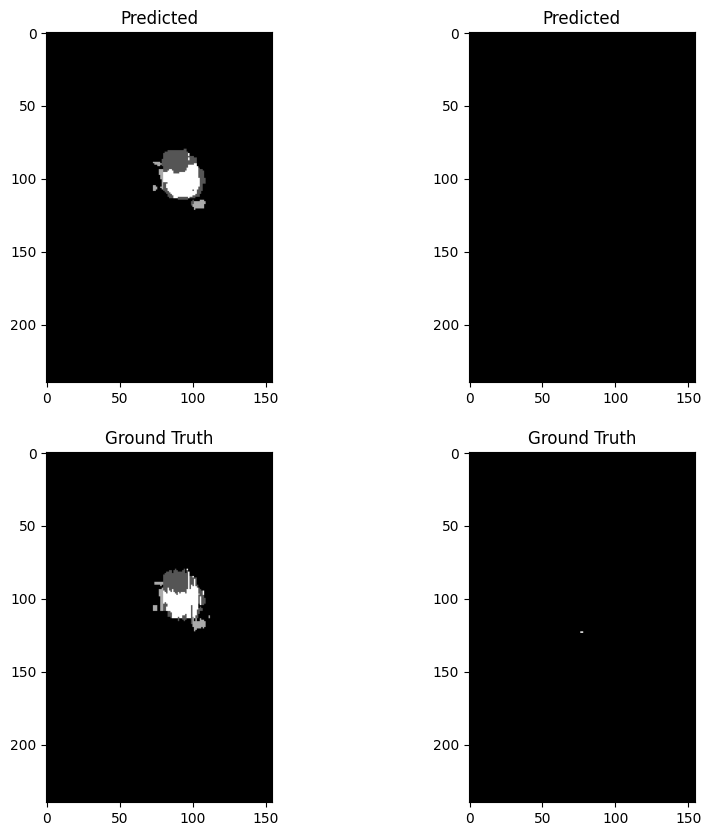

100%|██████████| 189/189 [04:51<00:00,  1.54s/it]



Average Training Loss: 0.003161045718967678

Average Training DSC: [0.99964172 0.96471664 0.96855718 0.89568316]
Average Training ASSD: [ 0.03084122  2.36835395  4.75727591 12.47967511]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


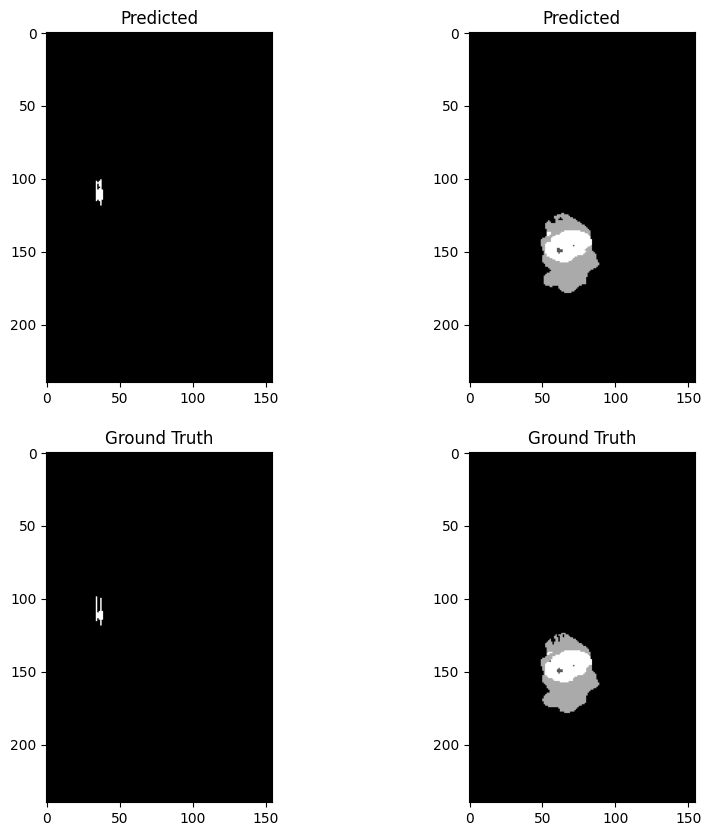

100%|██████████| 48/48 [01:02<00:00,  1.31s/it]


Average Validation Loss: 0.010308090054119626

Average Validation DSC: [0.99937003 0.92863135 0.95066928 0.85272006]
Average Validation ASSD: [ 0.05699451 11.53285916  7.94127144 12.35124416]
Epoch 100/100
-------------------------


  0%|          | 0/189 [00:00<?, ?it/s]

Training Prediction Visualization:


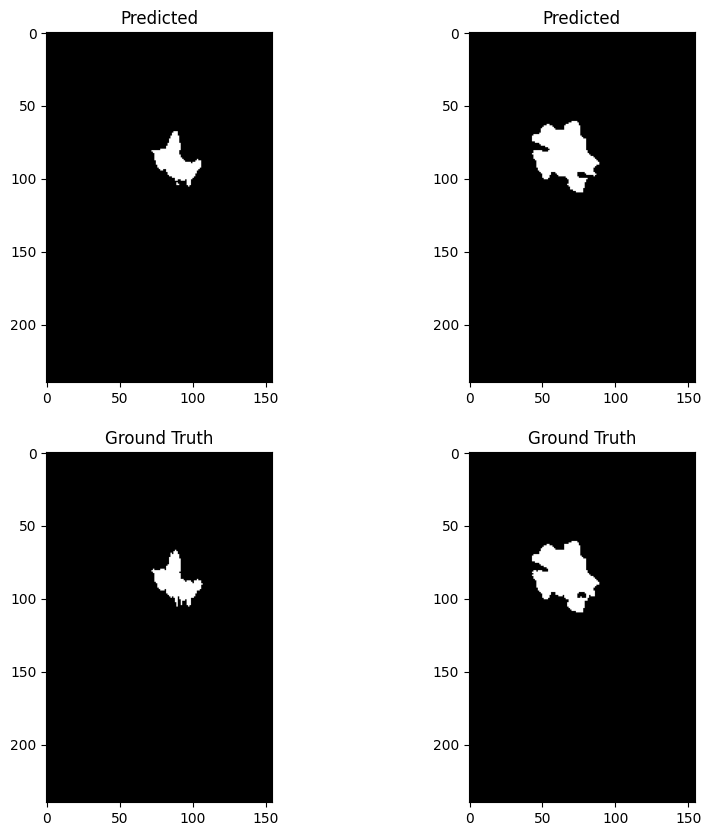

100%|██████████| 189/189 [06:38<00:00,  2.11s/it]



Average Training Loss: 0.003097219320590652

Average Training DSC: [0.99965025 0.96531272 0.97047744 0.89664598]
Average Training ASSD: [ 0.02977467  2.24509855  4.15254282 11.41232105]


  0%|          | 0/48 [00:00<?, ?it/s]

Validation Prediction Visualization:


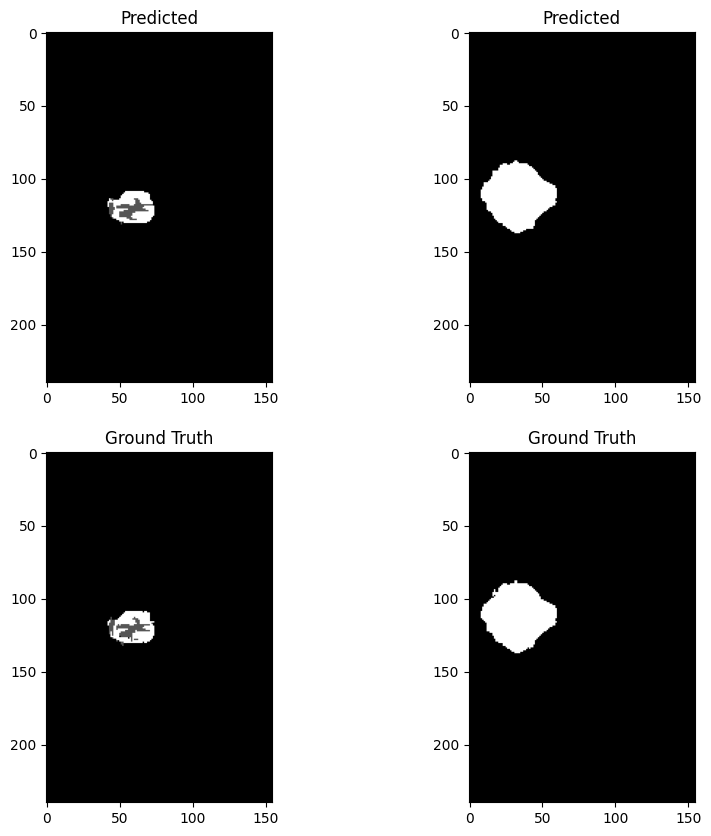

100%|██████████| 48/48 [01:26<00:00,  1.79s/it]


Average Validation Loss: 0.010346376177039929

Average Validation DSC: [0.99939028 0.93090432 0.95177345 0.85474707]
Average Validation ASSD: [ 0.056941   10.37817427  8.40821834 13.13116376]


In [17]:
model = train_model(num_epochs = 100)